# SEGMENTEZ DES CLIENTS D'UN SITE DE E-COMMERCE

## Contexte

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Données

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## Mission

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Analyse,  Nettoyage  et Jointure des 9 tables

## 1.1. La table de géolocalisation "olist_geolocation_dataset"

### 1. Informations générales sur le jeu de données

In [2]:
# Ouverture du fichier
df_1 = pd.read_csv("olist_geolocation_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_1.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [3]:
# Copie du fichier
geolocalisation = df_1.copy()

In [4]:
# Dimension du jeu de données
print(f'Cette 1ère table comprend {geolocalisation.shape[0]} lignes et {geolocalisation.shape[1]} variables.')

Cette 1ère table comprend 1000163 lignes et 5 variables.


In [5]:
# Infos sur le jeu de données
geolocalisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


**Cette table ne présente pas de donnée manquante.**

In [6]:
# Vérification du nombre de données uniques de la variable 'geolocation_zip_code_prefix' 
code = geolocalisation["geolocation_zip_code_prefix"].unique().tolist()
len(code)

19015

### 2. Vérification de l'absence d'anomalie du nombre d'états

Le Brésil possède 5 régions, 27 états (incluant un district fédéral abritant la capitale, Brasilia) et 10 017 villes.  Ce pays s'étend sur 4395 km du Nord au Sud (5°16'20" Nord à 33°44'32" Sud de latitude), de 4319 km d'Est en Ouest (34°47'30" Est à 73°59'32" Ouest de longitude) et couvre trois fuseaux horaires.

In [7]:
# Vérification du nombre d'états présents de la variable 'geolocation_state' 
etats = geolocalisation["geolocation_state"].unique().tolist()
len(etats)

27

**Absence d'anomalie au niveau du nombre d'états.**

### 3. Vérification de l'absence d'anomalie au niveau des latitudes et longitudes

In [8]:
geolocalisation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


**LES LATITUDES**

**Nous sommes en présence de certaines latitudes et longitudes aberrantes. Ces dernières seront éliminées de jeu de données.**

In [9]:
# Latitudes anormales
geo_anormale_lat =  geolocalisation[(geolocalisation["geolocation_lat"] >= 5.2722222) | (geolocalisation["geolocation_lat"] <= -33.7422222)]
geo_anormale_lat.head() 

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
387565,18243,28.008978,-15.536867,bom retiro da esperanca,SP
513631,28165,41.614052,-8.411675,vila nova de campos,RJ
513643,28155,-34.586422,-58.732101,santa maria,RJ
513754,28155,42.439286,13.820214,santa maria,RJ
514429,28333,38.381672,-6.328200,raposo,RJ


In [10]:
print(f'Cette anomalie concerne {geo_anormale_lat.shape[0]} lignes.')

Cette anomalie concerne 31 lignes.


**Il est indispensable de vérifier que certains codes postaux ne disparaissent pas avec l'élimination de ces valeurs aberrantes. En effet, ce dernier permet de relier cette table aux tables clients et vendeurs.**

In [11]:
# Liste des latitudes anormales
liste_latitude_anormale = geo_anormale_lat.index.tolist()

# Suppression du dataframe
geolocalisation = geolocalisation[~geolocalisation.index.isin(liste_latitude_anormale)]

# Vérification du nombre de lignes (attendu 1000132)
print(f'Après élimination de ce 31 lignes, le jeu de données en contient désormais {geolocalisation.shape[0]}.')

Après élimination de ce 31 lignes, le jeu de données en contient désormais 1000132.


In [12]:
# Vérification du nombre d'états après cette élimination (attendu 27)
etats_lat = geolocalisation["geolocation_state"].unique().tolist()
len(etats_lat)

27

In [13]:
# Vérification du nombre de codes postaux après cette élimination (attendu 19015)
code_lat = geolocalisation["geolocation_zip_code_prefix"].unique().tolist()
len(code_lat)

19011

**A NOTER: 4 codes postaux disparaissent, ces derniers pouvant très bien ne pas être utilisés lors des jointures avec les 2 autres tables... Ce notebook d'exploration n'étant pas le premier réalisé, je sais que ces codes postaux ne seront pas utiles lors de la jointure.**

**LES LONGITUDES**

In [14]:
# Les longitudes normales
longitudes_normales = geolocalisation[(geolocalisation["geolocation_lng"] <= -33.7422222) & (geolocalisation["geolocation_lng"] >= -73.99222222222222)]

# Nombre de longitudes anormales
print(f'Ce jeu de données présente {geolocalisation.shape[0]-longitudes_normales.shape[0]} anomalies au niveau des longitudes.')

Ce jeu de données présente 11 anomalies au niveau des longitudes.


**Comme précedemment, nous allons vérifier le nombre d'états et de codes postaux présents après élimination de ces 11 lignes.**

In [15]:
# Vérification du nombre d'états après cette élimination (attendu 27)
etats_lng = longitudes_normales["geolocation_state"].unique().tolist()
len(etats_lng)

27

In [16]:
# Vérification du nombre de codes postaux après cette élimination (attendu 19011)
code_lng = longitudes_normales["geolocation_zip_code_prefix"].unique().tolist()
len(code_lng)

19010

**A NOTER: Un autre code postal a disparu mais comme précédemment, ce dernier n'est pas utile.**

**CREATION DU NOUVEAU DATAFRAME**

In [17]:
# Liste des index de longitudes normales
liste_lng_normale = longitudes_normales.index.tolist()

# Création du nouveau dataframe
geolocalisation = geolocalisation[geolocalisation.index.isin(liste_lng_normale)]

# Vérification du nombre de lignes du nouveau jeu de données (attendu 1000121)
print(f'Après élimination des latitudes et longitudes anormales, le jeu de données comprend désormais {geolocalisation.shape[0]} lignes.')

Après élimination des latitudes et longitudes anormales, le jeu de données comprend désormais 1000121 lignes.


**VISUALISATION GRAPHIQUE DES DONNEES DE LOCALISATION EN FONcTION DU CODE POSTAL**

<Figure size 1000x1000 with 0 Axes>

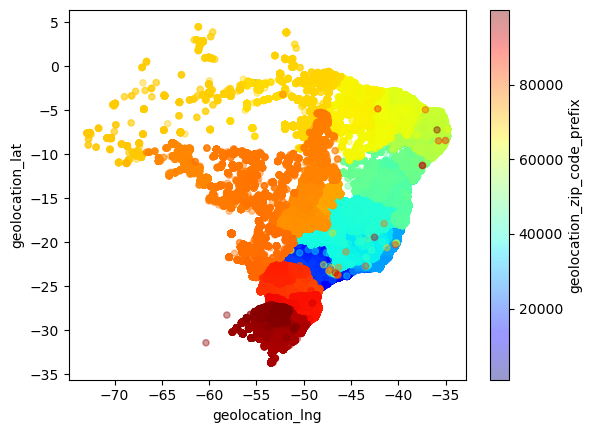

In [18]:
plt.figure(figsize=(10,10))
geolocalisation.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat",alpha=0.4, c="geolocation_zip_code_prefix", cmap=plt.get_cmap("jet"), colorbar=True)
plt.show()

**Globalement, cette visualisation via le code postal donne un bon aperçu non seulement de la forme de Brésil mais aussi des différents états.**

**A NOTER:**
- Les latitudes et longitudes à 6 digits donnent une précision d'environ 11 centimètres. Dans notre mission, ceci est trop précis et risque d'être problématique lors des jointures. De ce fait, je trouve plus judicieux de ne conserver qu'un code postal unique avec une moyenne pour la latitude et la longitude.
- Seules les 3 variables "geolocation_zip_code_prefix", "geolocation_lat" et "geolocation_lgn" seront utiles. En effet, les 2 autres variables sont déjà présentes dans les tables des acheteurs et des vendeurs (description des données sur le site Kaggle).
- Les villes ne seront donc pas analysées pour ce jeu de données.

**MOYENNE DE LA LATITUDE ET DE LA LONGITUDE POUR CHAQUE CODE POSTAL**

In [19]:
localisation = geolocalisation.groupby('geolocation_zip_code_prefix').agg({"geolocation_lat":"mean", "geolocation_lng" :"mean"}).reset_index()
localisation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [20]:
# Nombre de zip_code (attendu 19010)
print(f'La table contient {localisation.shape[0]} codes postaux.')

La table contient 19010 codes postaux.


In [21]:
# Changement du nom des colonnes
localisation.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix", "geolocation_lat": "latitude", "geolocation_lng": "longitude"}, inplace = True)
localisation.head()

,zip_code_prefix,latitude,longitude
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


## 1.2. La table des vendeurs "olist_sellers_dataset.csv"

### 1. Informations générales sur le jeu de données

In [22]:
# Ouverture du fichier
df_2 = pd.read_csv("olist_sellers_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_2.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [23]:
# Copie du fichier
vendeurs = df_2.copy()

In [24]:
# Dimension du jeu de données
print(f'Cette 2ème table comprend {vendeurs.shape[0]} vendeurs et {vendeurs.shape[1]} variables.')

Cette 2ème table comprend 3095 vendeurs et 4 variables.


In [25]:
# Infos sur le jeu de données
vendeurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


**Cette table ne contient aucune donnée manquante.**

In [26]:
# Vérification de l'absence de doublons
print(f'Cette table contient {vendeurs.duplicated().sum()} doublon(s).')

Cette table contient 0 doublon(s).


In [27]:
# Nombre de vendeurs uniques (attendu 3095)
nombre_vendeurs = vendeurs["seller_id"].unique().tolist()
len(nombre_vendeurs)

3095

In [28]:
# Nombre d'états présents
nombre_etats_vendeurs = vendeurs["seller_state"].unique().tolist()
len(nombre_etats_vendeurs)

23

**Quatre états ne possèdent pas de vendeurs présents sur le site d'olist.**

In [29]:
# Nombre de codes postaux
nombre_code_vendeurs = vendeurs["seller_zip_code_prefix"].unique().tolist()
len(nombre_code_vendeurs)

2246

### 2. Vérification de l'absence d'anomalie au niveau des villes

In [30]:
# Nombre de villes à priori présentes
nombre_villes_vendeurs = vendeurs["seller_city"].unique().tolist()
len(nombre_villes_vendeurs)

611

**Cette table recense 611 villes, le Brésil en comptant 10107 villes ce qui parait pertinent. Néanmoins, il est indispensable de vérifier qu'il n'y ait pas de problèmes de casse ou autres, ce qui est souvent le cas pour une telle variable.**

In [31]:
print(vendeurs["seller_city"].unique().tolist())

['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo', 'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis', 'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia', 'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio', 'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui', 'garopaba', 'camanducaia', 'tupa', 'guarulhos', 'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba', 'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos', 'joinville', 'saquarema', 'barra velha', 'petropolis', 'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba', 'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari', 'contagem', 'jaragua do sul', 'lages - sc', 'bento goncalves', 'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia', 'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol', 'birigui', 'assis', 'jaguariuna', 'araraquara', 'macae', 'rio claro', 'londrina', 'ribeirao preto', 'tres coracoes

**Dans cette table, il n'y a pas de problème d'accents. Néanmoins, certaines villes sont présentes plusieurs et ce pour de multiples raisons:**
- La présence de tirets, voire de double espace
- La présence de d ou d' ou do 
- Une mauvaise orthographie
- Des villes en abrégé...

**De ce fait, les principaux problèmes seront corrigés. Néamoins, il se peut que je passe à côté de certaines mauvaises nomenclature...**

**MODIFICATION DES ANOMALIES DETECTEES**

**Sao Paulo**

In [32]:
# Création du dataframe

sao_paulo = vendeurs[(vendeurs["seller_city"] == "sao pauo") | (vendeurs["seller_city"] == "sao paulo") | (vendeurs["seller_city"] == "sao paulo") |
                    (vendeurs["seller_city"] == "sao paulo / sao paulo") | (vendeurs["seller_city"]=="sao paulo - sp") | (vendeurs["seller_city"]=="são paulo")|
                    (vendeurs["seller_city"] == "sp / sp") | (vendeurs["seller_city"] == "sp") |(vendeurs["seller_city"] == "sao paulo sp") |
                    (vendeurs["seller_city"] == "sao  paulo") | (vendeurs["seller_city"] == "sao paluo") | (vendeurs["seller_city"] == "sao paulop")]

# Liste des index
liste_sao_paulo = sao_paulo.index.tolist()

# Modification de la table
for idx in liste_sao_paulo:
    vendeurs.loc[idx, "seller_city"] = "sao paulo"

**Sao Bernardo do Campo**

In [33]:
# Création du dataframe

sao_bernardo_do_campo = vendeurs[(vendeurs["seller_city"] == "sao bernardo do campo") | (vendeurs["seller_city"] == "sbc/sp") |
                                 (vendeurs["seller_city"] == "sbc") | (vendeurs["seller_city"] == "sao bernardo do capo")]

# Liste des index
liste_sao_bernardo_do_campo = sao_bernardo_do_campo.index.tolist()

# Modification de la table
for idx in liste_sao_bernardo_do_campo:
    vendeurs.loc[idx, "seller_city"] = "sao bernardo do campo"

**Rio de Janeiro**

In [34]:
# Création du dataframe

rio_de_janeiro = vendeurs[(vendeurs["seller_city"] == "rio de janeiro") | (vendeurs["seller_city"] == "rio de janeiro \\rio de janeiro")|
                          (vendeurs["seller_city"] == "rio de janeiro / rio de janeiro") | (vendeurs["seller_city"] == "rio de janeiro, rio de janeiro, brasil") |
                          (vendeurs["seller_city"] == "04482255")]

# Liste des index
liste_rio_de_janeiro = rio_de_janeiro.index.tolist()

# Modification de la table
for idx in liste_rio_de_janeiro:
    vendeurs.loc[idx, "seller_city"] = "rio de janeiro"

**Imbituba**

In [35]:
# Création du dataframe

imbituba = vendeurs[(vendeurs["seller_city"] == "imbituba") | (vendeurs["seller_city"] == "imbituva")]

# Liste des index
liste_imbituba = imbituba.index.tolist()

# Modification de la table
for idx in liste_imbituba:
    vendeurs.loc[idx, "seller_city"] = "imbituba"

**Brasilia**

In [36]:
# Création du dataframe

brasilia = vendeurs[(vendeurs["seller_city"] == "brasilia df") | (vendeurs["seller_city"] == "brasilia")]

# Liste des index
liste_brasilia = brasilia.index.tolist()

# Modification de la table
for idx in liste_brasilia:
    vendeurs.loc[idx, "seller_city"] = "brasilia"

**Belo horizonte**

In [37]:
# Création du dataframe

belo_horizonte = vendeurs[(vendeurs["seller_city"] == "belo horizonte") | (vendeurs["seller_city"] == "belo horizont")]

# Liste des index
liste_belo_horizonte = belo_horizonte.index.tolist()

# Modification de la table
for idx in liste_belo_horizonte:
    vendeurs.loc[idx, "seller_city"] = "belo horizonte"

**Sao jose do rio preto**

In [38]:
# Création du dataframe

sao_jose_do_rio_preto = vendeurs[(vendeurs["seller_city"] == "sao jose do rio preto") | (vendeurs["seller_city"] == "s jose do rio preto")]

# Liste des index
liste_sao_jose_do_rio_preto = sao_jose_do_rio_preto.index.tolist()

# Modification de la table
for idx in liste_sao_jose_do_rio_preto:
    vendeurs.loc[idx, "seller_city"] = "sao jose do rio preto"

**Sao jose dos pinhais**

In [39]:
# Création du dataframe

sao_jose_dos_pinhais = vendeurs[(vendeurs["seller_city"] == "sao jose dos pinhais") | (vendeurs["seller_city"] == "sao jose dos pinhas")]

# Liste des index
liste_sao_jose_dos_pinhais = sao_jose_dos_pinhais.index.tolist()

# Modification de la table
for idx in liste_sao_jose_dos_pinhais:
    vendeurs.loc[idx, "seller_city"] = "sao jose dos pinhais"

**Porto alegre**

In [40]:
# Création du dataframe

porto_alegre = vendeurs[(vendeurs["seller_city"] == "porto alegre") | (vendeurs["seller_city"] == "poa")]

# Liste des index
liste_porto_alegre = porto_alegre.index.tolist()

# Modification de la table
for idx in liste_porto_alegre:
    vendeurs.loc[idx, "seller_city"] = "porto alegre"

**Congonhas**

In [41]:
# Création du dataframe

congonhas = vendeurs[(vendeurs["seller_city"] == "congonhas") | (vendeurs["seller_city"] == "congonhal")]

# Liste des index
liste_congonhas = congonhas.index.tolist()

# Modification de la table
for idx in liste_congonhas:
    vendeurs.loc[idx, "seller_city"] = "congonhas"

**Santo andre**

In [42]:
# Création du dataframe

santo_andre = vendeurs[(vendeurs["seller_city"] == "santo andre") | (vendeurs["seller_city"] == "santo andre/sao paulo")]

# Liste des index
liste_santo_andre = santo_andre.index.tolist()

# Modification de la table
for idx in liste_santo_andre:
    vendeurs.loc[idx, "seller_city"] = "santo andre"

**Jacarei**

In [43]:
# Création du dataframe

jacarei = vendeurs[(vendeurs["seller_city"] == "jacarei") | (vendeurs["seller_city"] == "jacarei / sao paulo")]

# Liste des index
liste_jacarei = jacarei.index.tolist()

# Modification de la table
for idx in liste_jacarei:
    vendeurs.loc[idx, "seller_city"] = "jacarei"

**Jaragua do sul**

In [44]:
# Création du dataframe

jaragua_do_sul = vendeurs[(vendeurs["seller_city"] == "jaragua do sul") | (vendeurs["seller_city"] == "jaragua")]

# Liste des index
liste_jaragua_do_sul = jaragua_do_sul.index.tolist()

# Modification de la table
for idx in liste_jaragua_do_sul:
    vendeurs.loc[idx, "seller_city"] = "jaragua do sul"

**Lages**

In [45]:
# Création du dataframe

lages = vendeurs[(vendeurs["seller_city"] == "lages") | (vendeurs["seller_city"] == "lages - sc")]

# Liste des index
liste_lages = lages.index.tolist()

# Modification de la table
for idx in liste_lages:
    vendeurs.loc[idx, "seller_city"] = "lages"

**Ribeirao preto**

In [46]:
# Création du dataframe

ribeirao_preto = vendeurs[(vendeurs["seller_city"] == "ribeirao preto") | (vendeurs["seller_city"] == "ribeirao pretp") | (vendeurs["seller_city"] == "ribeirao preto / sao paulo")]

# Liste des index
liste_ribeirao_preto = ribeirao_preto.index.tolist()

# Modification de la table
for idx in liste_ribeirao_preto:
    vendeurs.loc[idx, "seller_city"] = "ribeirao preto"

**Tres coracoes**

In [47]:
# Création du dataframe

tres_coracoes = vendeurs[(vendeurs["seller_city"] == "tres coracoes") | (vendeurs["seller_city"] == "tres coroas")]

# Liste des index
liste_tres_coracoes = tres_coracoes.index.tolist()

# Modification de la table
for idx in liste_tres_coracoes:
    vendeurs.loc[idx, "seller_city"] = "tres coracoes"

**Formosa do oeste**

In [48]:
# Création du dataframe

formosa_do_oeste = vendeurs[(vendeurs["seller_city"] == "formosa do oeste") | (vendeurs["seller_city"] == "formosa")]

# Liste des index
liste_formosa_do_oeste = formosa_do_oeste.index.tolist()

# Modification de la table
for idx in liste_formosa_do_oeste:
    vendeurs.loc[idx, "seller_city"] = "formosa do oeste"

**Carapicuiba**

In [49]:
# Création du dataframe

carapicuiba = vendeurs[(vendeurs["seller_city"] == "carapicuiba") | (vendeurs["seller_city"] == "carapicuiba / sao paulo")]

# Liste des index
liste_carapicuiba = carapicuiba.index.tolist()

# Modification de la table
for idx in liste_carapicuiba:
    vendeurs.loc[idx, "seller_city"] = "carapicuiba"

**Ferraz de vasconcelos**

In [50]:
# Création du dataframe

ferraz_de_vasconcelos = vendeurs[(vendeurs["seller_city"] == "ferraz de vasconcelos") | (vendeurs["seller_city"] == "ferraz de  vasconcelos")]

# Liste des index
liste_ferraz_de_vasconcelos = ferraz_de_vasconcelos.index.tolist()

# Modification de la table
for idx in liste_ferraz_de_vasconcelos:
    vendeurs.loc[idx, "seller_city"] = "ferraz de vasconcelos"

**Afonso claudio**

In [51]:
# Création du dataframe

afonso_claudio = vendeurs[(vendeurs["seller_city"] == "afonso claudio") | (vendeurs["seller_city"] == "claudio")]

# Liste des index
liste_afonso_claudio = afonso_claudio.index.tolist()

# Modification de la table
for idx in liste_afonso_claudio:
    vendeurs.loc[idx, "seller_city"] = "afonso claudio"

**Itapeva**

In [52]:
# Création du dataframe

itapeva = vendeurs[(vendeurs["seller_city"] == "itapeva") | (vendeurs["seller_city"] == "itapev1")]

# Liste des index
liste_itapeva = itapeva.index.tolist()

# Modification de la table
for idx in liste_itapeva:
    vendeurs.loc[idx, "seller_city"] = "itapeva"

**Maua**

In [53]:
# Création du dataframe

maua = vendeurs[(vendeurs["seller_city"] == "maua") | (vendeurs["seller_city"] == "maua/sao paulo")]

# Liste des index
liste_maua = maua.index.tolist()

# Modification de la table
for idx in liste_maua:
    vendeurs.loc[idx, "seller_city"] = "maua"

**Auriflama**

In [54]:
# Création du dataframe

auriflama = vendeurs[(vendeurs["seller_city"] == "auriflama") | (vendeurs["seller_city"] == "auriflama/sp")]

# Liste des index
liste_auriflama = auriflama.index.tolist()

# Modification de la table
for idx in liste_auriflama:
    vendeurs.loc[idx, "seller_city"] = "auriflama"

**Sao jose do rio preto**

In [55]:
# Création du dataframe

sao_jose_do_rio_preto = vendeurs[(vendeurs["seller_city"] == "sao jose do rio preto") | (vendeurs["seller_city"] == "sao jose do rio pret")]

# Liste des index
liste_sao_jose_do_rio_preto = sao_jose_do_rio_preto.index.tolist()

# Modification de la table
for idx in liste_sao_jose_do_rio_preto:
    vendeurs.loc[idx, "seller_city"] = "sao jose do rio preto"

**Mogi das cruzes**

In [56]:
# Création du dataframe

mogi_das_cruzes = vendeurs[(vendeurs["seller_city"] == "mogi das cruzes")  | (vendeurs["seller_city"] == 'mogi das cruzes / sp')]

# Liste des index
liste_mogi_das_cruzes = mogi_das_cruzes.index.tolist()

# Modification de la table
for idx in liste_mogi_das_cruzes:
    vendeurs.loc[idx, "seller_city"] = "mogi das cruzes"

**Cascavel**

In [57]:
# Création du dataframe

cascavel = vendeurs[(vendeurs["seller_city"] == "cascavel") | (vendeurs["seller_city"] == "cascavael")]

# Liste des index
liste_cascavel = cascavel.index.tolist()

# Modification de la table
for idx in liste_cascavel:
    vendeurs.loc[idx, "seller_city"] = "cascavel"

**Santa barbara d oeste**

In [58]:
# Création du dataframe

santa_barbara_d_oeste = vendeurs[(vendeurs["seller_city"] == "santa barbara d oeste") | (vendeurs["seller_city"] == "santa barbara d´oeste") | (vendeurs["seller_city"] == "santa barbara d'oeste")]

# Liste des index
liste_santa_barbara_d_oeste = santa_barbara_d_oeste.index.tolist()

# Modification de la table
for idx in liste_santa_barbara_d_oeste:
    vendeurs.loc[idx, "seller_city"] = "santa barbara d oeste"

**Rio grande do sul**

In [59]:
# Création du dataframe

rio_grande_do_sul = vendeurs[(vendeurs["seller_city"] == "rio grande do sul") | (vendeurs["seller_city"] == "rio grande")]

# Liste des index
liste_rio_grande_do_sul = rio_grande_do_sul.index.tolist()

# Modification de la table
for idx in liste_rio_grande_do_sul:
    vendeurs.loc[idx, "seller_city"] = "rio grande do sul"

**Cariacica**

In [60]:
# Création du dataframe

cariacica = vendeurs[(vendeurs["seller_city"] == "cariacica") | (vendeurs["seller_city"] == "cariacica / es")]

# Liste des index
liste_cariacica = cariacica.index.tolist()

# Modification de la table
for idx in liste_cariacica:
    vendeurs.loc[idx, "seller_city"] = "cariacica"

**Sao miguel do oeste**

In [61]:
# Création du dataframe

sao_miguel_do_oeste = vendeurs[(vendeurs["seller_city"] == "sao miguel do oeste") | (vendeurs["seller_city"] == "sao miguel d'oeste")]

# Liste des index
liste_sao_miguel_do_oeste = sao_miguel_do_oeste.index.tolist()

# Modification de la table
for idx in liste_sao_miguel_do_oeste:
    vendeurs.loc[idx, "seller_city"] = "sao miguel do oeste"

**Pinhais**

In [62]:
# Création du dataframe

pinhais = vendeurs[(vendeurs["seller_city"] == "pinhais") | (vendeurs["seller_city"] == "pinhais/pr")]

# Liste des index
liste_pinhais = pinhais.index.tolist()

# Modification de la table
for idx in liste_pinhais:
    vendeurs.loc[idx, "seller_city"] = "pinhais"

**Sao sebastiao da grama**

In [63]:
# Création du dataframe

sao_sebastiao_da_grama = vendeurs[(vendeurs["seller_city"] == "sao sebastiao da grama/sp")]

# Liste des index
liste_sao_sebastiao_da_grama = sao_sebastiao_da_grama.index.tolist()

# Modification de la table
for idx in liste_sao_sebastiao_da_grama:
    vendeurs.loc[idx, "seller_city"] = "sao sebastiao da grama"

**Ubatuba**

In [64]:
# Création du dataframe

ubatuba = vendeurs[(vendeurs["seller_city"] == "ubatuba") | (vendeurs["seller_city"] == "uba")]

# Liste des index
liste_ubatuba = ubatuba.index.tolist()

# Modification de la table
for idx in liste_ubatuba:
    vendeurs.loc[idx, "seller_city"] = "ubatuba"

**Angra dos reis**

In [65]:
# Création du dataframe

angra_dos_reis = vendeurs[(vendeurs["seller_city"] == "angra dos reis") | (vendeurs["seller_city"] == "angra dos reis rj")]

# Liste des index
liste_angra_dos_reis = angra_dos_reis.index.tolist()

# Modification de la table
for idx in liste_angra_dos_reis:
    vendeurs.loc[idx, "seller_city"] = "angra dos reis"

**Lambari**

In [66]:
# Création du dataframe

lambari = vendeurs[(vendeurs["seller_city"] == "lambari") | (vendeurs["seller_city"] == "alambari")]

# Liste des index
liste_lambari = lambari.index.tolist()

# Modification de la table
for idx in liste_lambari:
    vendeurs.loc[idx, "seller_city"] = "lambari"

**Andira**

In [67]:
# Création du dataframe

andira = vendeurs[(vendeurs["seller_city"] == "andira") | (vendeurs["seller_city"] == "andira-pr")]

# Liste des index
liste_andira = andira.index.tolist()

# Modification de la table
for idx in liste_andira:
    vendeurs.loc[idx, "seller_city"] = "andira"

**Aparecida de goiania**

In [68]:
# Création du dataframe

aparecida_de_goiania = vendeurs[(vendeurs["seller_city"] == "aparecida de goiania") | (vendeurs["seller_city"] == "aparecida")]

# Liste des index
liste_aparecida_de_goiania = aparecida_de_goiania.index.tolist()

# Modification de la table
for idx in liste_aparecida_de_goiania:
    vendeurs.loc[idx, "seller_city"] = "aparecida de goiania"

**Sao jose do rio pardo**

In [69]:
# Création du dataframe

sao_jose_do_rio_pardo = vendeurs[(vendeurs["seller_city"] == "sao jose do rio pardo") | (vendeurs["seller_city"] == "scao jose do rio pardo")]

# Liste des index
liste_sao_jose_do_rio_pardo = sao_jose_do_rio_pardo.index.tolist()

# Modification de la table
for idx in liste_sao_jose_do_rio_pardo:
    vendeurs.loc[idx, "seller_city"] = "sao jose do rio pardo"

**Aguas claras**

In [70]:
# Création du dataframe

aguas_claras = vendeurs[(vendeurs["seller_city"] == "aguas claras df")]

# Liste des index
liste_aguas_claras = aguas_claras.index.tolist()

# Modification de la table
for idx in liste_aguas_claras:
    vendeurs.loc[idx, "seller_city"] = "aguas claras"

**Barbacena**

In [71]:
# Création du dataframe

barbacena = vendeurs[(vendeurs["seller_city"] == "barbacena") | (vendeurs["seller_city"] == "barbacena/ minas gerais") ]

# Liste des index
liste_barbacena = barbacena.index.tolist()

# Modification de la table
for idx in liste_barbacena:
    vendeurs.loc[idx, "seller_city"] = "barbacena"

**Novo hamburgo**

In [72]:
# Création du dataframe

novo_hamburgo = vendeurs[(vendeurs["seller_city"] == "novo hamburgo") | (vendeurs["seller_city"] == "novo hamburgo, rio grande do sul, bra") ]

# Liste des index
liste_novo_hamburgo = novo_hamburgo.index.tolist()

# Modification de la table
for idx in liste_novo_hamburgo:
    vendeurs.loc[idx, "seller_city"] = "novo hamburgo"

**Elimination des tirets et des doubles espaces pouvant persister**

In [73]:
vendeurs["seller_city"] = vendeurs["seller_city"].str.replace("-", " ", regex=True)
vendeurs["seller_city"] = vendeurs["seller_city"].str.replace("  ", " ", regex=True)

**Elimination des éventuels accents**

In [74]:
import unidecode
vendeurs["seller_city"] = vendeurs["seller_city"].apply(unidecode.unidecode)

**Vérification du contenu de la variable et analyse du nombre de villes présentes après modification**

In [75]:
print(vendeurs["seller_city"].unique().tolist())

['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo', 'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis', 'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia', 'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio', 'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui', 'garopaba', 'camanducaia', 'tupa', 'guarulhos', 'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba', 'porto alegre', 'congonhas', 'santo andre', 'osasco', 'valinhos', 'joinville', 'saquarema', 'barra velha', 'petropolis', 'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba', 'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari', 'contagem', 'jaragua do sul', 'lages', 'bento goncalves', 'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia', 'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol', 'birigui', 'assis', 'jaguariuna', 'araraquara', 'macae', 'rio claro', 'londrina', 'ribeirao preto', 'tres coracoes', 'n

In [76]:
# Nombre de villes présentes
len(vendeurs["seller_city"].unique().tolist())

559

Les vendeurs sont désormais répartis dans 558 villes.

### 3. La répartition des vendeurs par état

In [77]:
# Création d'un dataframe
vendeur_par_etat = vendeurs.groupby("seller_state")["seller_id"].count()
vendeur_par_etat = vendeur_par_etat.reset_index()

# Renommage des colonnes
vendeur_par_etat.columns = ["Etat", "Nombre de vendeurs"]
vendeur_par_etat.head()

,Etat,Nombre de vendeurs
0,AC,1
1,AM,1
2,BA,19
3,CE,13
4,DF,30


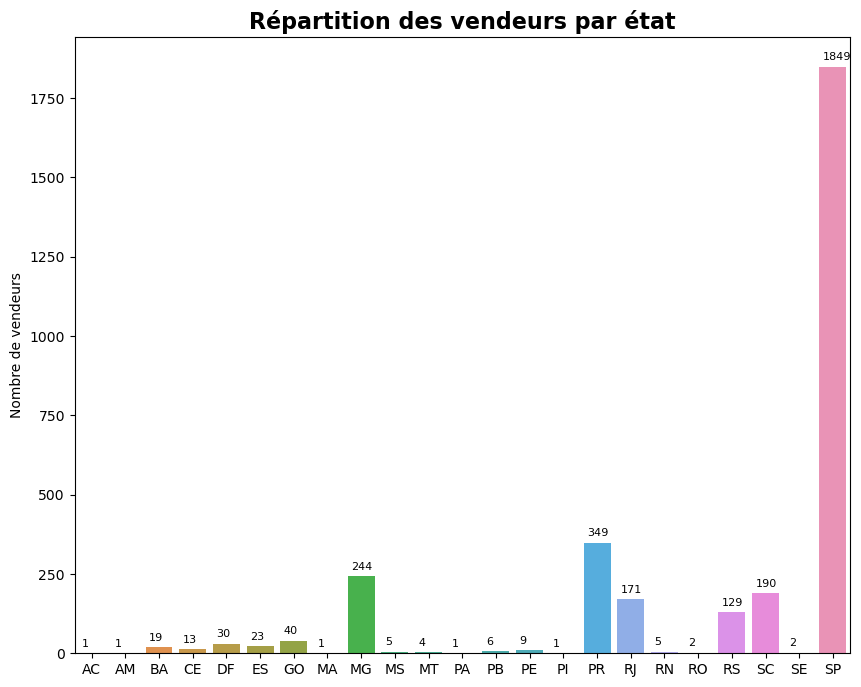

In [78]:
# Visualisation par histogramme

plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=vendeur_par_etat, x="Etat", y="Nombre de vendeurs")
    plt.xlabel('')
    plt.title("Répartition des vendeurs par état", fontname = 'Sans-serif', fontsize= 16, fontweight="bold")

nb = vendeur_par_etat["Nombre de vendeurs"]
for i, v in enumerate(nb):
    plt.text(i-0.3,v+20, int(v), fontsize=8, fontname="sans-serif")

plt.show()      

**Les 3095 vendeurs sont majoritairement localisés dans l'état de Sau Paulo (67%), suivi des états de Parana et Minas Gerais.**

### 4. Jointure avec la table de géolocalisation

**RENOMMAGE DE LA VARIABLE 'seller_zip_code_prefix' POUR FACILITER LA JOINTURE**

In [79]:
# Elimination du seller_
vendeurs.rename(columns={"seller_zip_code_prefix": "zip_code_prefix"}, inplace = True)
vendeurs.head()

,seller_id,zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


**JOINTURE**

In [80]:
jointure_1 = pd.merge(vendeurs, localisation, on='zip_code_prefix', how='left')
jointure_1.head()

,seller_id,zip_code_prefix,seller_city,seller_state,latitude,longitude
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.964803,-46.534419


**RENOMMAGE DES COLONNES POUR LA SUITE DES JOINTURES**

In [81]:
jointure_1.rename(columns= {"zip_code_prefix": "zip_vendeur", "seller_city" : "ville_vendeur", 
                            "seller_state":"etat_vendeur", "latitude": "lat_vendeur", "longitude": "lng_vendeur"}, inplace= True)

jointure_1.head()

,seller_id,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.964803,-46.534419


**INFORMATIONS SUR LE JEU DE DONNEES**

In [82]:
jointure_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seller_id      3095 non-null   object 
 1   zip_vendeur    3095 non-null   int64  
 2   ville_vendeur  3095 non-null   object 
 3   etat_vendeur   3095 non-null   object 
 4   lat_vendeur    3088 non-null   float64
 5   lng_vendeur    3088 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 169.3+ KB


**Nous sommes en présence de données manquantes concernant les latitudes et longitudes de 7 vendeurs. Comme le problème sera le même pour les clients et que pour ces derniers l'imputation sera réalisée via la variable 'customer_state', nous ferons de même ici afin d'être homogène.**

**NB: Je sais d'avance que ce problème sera rencontré car ce notebook provient d'un autre notebook moins bien agencé.**

**IMPUTATION DES DONNEES MANQUANTES**

In [83]:
# Les latitudes
jointure_1["lat_vendeur"] = jointure_1.groupby("etat_vendeur")["lat_vendeur"].transform(lambda x: x.fillna(x.mean()))

# Les longitudes
jointure_1["lng_vendeur"] = jointure_1.groupby("etat_vendeur")["lng_vendeur"].transform(lambda x: x.fillna(x.mean()))

**INFORMATIONS SUR LE JEU DE DONNEES APRES IMPUTATION**

In [84]:
jointure_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seller_id      3095 non-null   object 
 1   zip_vendeur    3095 non-null   int64  
 2   ville_vendeur  3095 non-null   object 
 3   etat_vendeur   3095 non-null   object 
 4   lat_vendeur    3095 non-null   float64
 5   lng_vendeur    3095 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 169.3+ KB


**Le jeu de données issue de la première jointure ne présente aucune donnée manquante.**

## 1.3. La table des acheteurs "olist_customers_dataset.csv"

### 1. Informations générales sur le jeu de données

In [85]:
# Ouverture du fichier
df_3 = pd.read_csv("olist_customers_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [86]:
# Copie du fichier
customer = df_3.copy()

In [87]:
# Dimension du jeu de données
print(f'Cette 3ème table comprend {customer.shape[0]} commandes et {customer.shape[1]} variables.')

Cette 3ème table comprend 99441 commandes et 5 variables.


In [88]:
# Infos sur le jeu de données
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


**Ce fichier clients ne présente aucune valeur manquante.**

In [89]:
# Vérification de l'absence de doublon
print(f'Cette table contient {customer.duplicated().sum()} doublon(s).')

Cette table contient 0 doublon(s).


In [90]:
# Nombre de clients (attendu 96096 d'après Kaggle)
nombre_clients = customer["customer_unique_id"].unique().tolist()
len(nombre_clients)

96096

In [91]:
# Nombre d'états présents
nombre_etats = customer["customer_state"].unique().tolist()
len(nombre_etats)

27

**Les clients sont répartis dans les 27 états.**

### 2. Vérification de l'absence d'anomalie au niveau des villes

In [92]:
# Nombre de villes à priori présentes
nombre_villes = customer["customer_city"].unique().tolist()
len(nombre_villes)

4119

**Cette table recense 4419 villes, le Brésil en comptant 10107 villes, ceci semble donc tout à fait pertinent. Néanmoins, ayant de gros risques de se retrouver avec les mêmes anomalies que pour les vendeurs, toutes les modifications réalisées sur ces derniers seront 'rejouées' sur ce jeu de données.**

**Sao Paulo**

In [93]:
# Création du dataframe

customer_sao_paulo = customer[(customer["customer_city"] == "sao pauo") | (customer["customer_city"] == "sao paulo") | (customer["customer_city"] == "sao paulo") |
                    (customer["customer_city"] == "sao paulo / sao paulo") | (customer["customer_city"]=="sao paulo - sp") | (customer["customer_city"]=="são paulo")|
                    (customer["customer_city"] == "sp / sp") | (customer["customer_city"] == "sp") |(customer["customer_city"] == "sao paulo sp") |
                    (customer["customer_city"] == "sao  paulo") | (customer["customer_city"] == "sao paluo") | (customer["customer_city"] == "sao paulop")]

# Liste des index
customer_liste_sao_paulo = customer_sao_paulo.index.tolist()

# Modification de la table
for idx in customer_liste_sao_paulo:
    customer.loc[idx, "customer_city"] = "sao paulo"

**Sao Bernardo do Campo**

In [94]:
# Création du dataframe

customer_sao_bernardo_do_campo = customer[(customer["customer_city"] == "sao bernardo do campo") | (customer["customer_city"] == "sbc/sp") |
                                 (customer["customer_city"] == "sbc") | (customer["customer_city"] == "sao bernardo do capo")]

# Liste des index
customer_liste_sao_bernardo_do_campo = customer_sao_bernardo_do_campo.index.tolist()

# Modification de la table
for idx in customer_liste_sao_bernardo_do_campo:
    customer.loc[idx, "customer_city"] = "sao bernardo do campo"

**Rio de Janeiro**

In [95]:
# Création du dataframe

customer_rio_de_janeiro = customer[(customer["customer_city"] == "rio de janeiro") | (customer["customer_city"] == "rio de janeiro \\rio de janeiro")|
                          (customer["customer_city"] == "rio de janeiro / rio de janeiro") | (customer["customer_city"] == "rio de janeiro, rio de janeiro, brasil") |
                          (customer["customer_city"] == "04482255")]

# Liste des index
customer_liste_rio_de_janeiro = customer_rio_de_janeiro.index.tolist()

# Modification de la table
for idx in customer_liste_rio_de_janeiro:
    customer.loc[idx, "customer_city"] = "rio de janeiro"

**Imbituba**

In [96]:
# Création du dataframe

customer_imbituba = customer[(customer["customer_city"] == "imbituba") | (customer["customer_city"] == "imbituva")]

# Liste des index
customer_liste_imbituba = customer_imbituba.index.tolist()

# Modification de la table
for idx in customer_liste_imbituba:
    customer.loc[idx, "customer_city"] = "imbituba"

**Brasilia**

In [97]:
# Création du dataframe

customer_brasilia = customer[(customer["customer_city"] == "brasilia df") | (customer["customer_city"] == "brasilia")]

# Liste des index
customer_liste_brasilia = customer_brasilia.index.tolist()

# Modification de la table
for idx in customer_liste_brasilia:
    customer.loc[idx, "customer_city"] = "brasilia"

**Belo horizonte**

In [98]:
# Création du dataframe

customer_belo_horizonte = customer[(customer["customer_city"] == "belo horizonte") | (customer["customer_city"] == "belo horizont")]

# Liste des index
customer_liste_belo_horizonte = customer_belo_horizonte.index.tolist()

# Modification de la table
for idx in customer_liste_belo_horizonte:
    customer.loc[idx, "customer_city"] = "belo horizonte"

**Sao jose do rio preto**

In [99]:
# Création du dataframe

customer_sao_jose_do_rio_preto = customer[(customer["customer_city"] == "sao jose do rio preto") | (customer["customer_city"] == "s jose do rio preto")]

# Liste des index
customer_liste_sao_jose_do_rio_preto = customer_sao_jose_do_rio_preto.index.tolist()

# Modification de la table
for idx in customer_liste_sao_jose_do_rio_preto:
    customer.loc[idx, "customer_city"] = "sao jose do rio preto"

**Sao jose dos pinhais**

In [100]:
# Création du dataframe

customer_sao_jose_dos_pinhais = customer[(customer["customer_city"] == "sao jose dos pinhais") | (customer["customer_city"] == "sao jose dos pinhas")]

# Liste des index
customer_liste_sao_jose_dos_pinhais = customer_sao_jose_dos_pinhais.index.tolist()

# Modification de la table
for idx in customer_liste_sao_jose_dos_pinhais:
    customer.loc[idx, "customer_city"] = "sao jose dos pinhais"

**Porto alegre**

In [101]:
# Création du dataframe

customer_porto_alegre = customer[(customer["customer_city"] == "porto alegre") | (customer["customer_city"] == "poa")]

# Liste des index
customer_liste_porto_alegre = customer_porto_alegre.index.tolist()

# Modification de la table
for idx in customer_liste_porto_alegre:
    customer.loc[idx, "customer_city"] = "porto alegre"

**Congonhas**

In [102]:
# Création du dataframe

customer_congonhas = customer[(customer["customer_city"] == "congonhas") | (customer["customer_city"] == "congonhal")]

# Liste des index
customer_liste_congonhas = customer_congonhas.index.tolist()

# Modification de la table
for idx in customer_liste_congonhas:
    customer.loc[idx, "customer_city"] = "congonhas"

**Santo andre**

In [103]:
# Création du dataframe

customer_santo_andre = customer[(customer["customer_city"] == "santo andre") | (customer["customer_city"] == "santo andre/sao paulo")]

# Liste des index
customer_liste_santo_andre = customer_santo_andre.index.tolist()

# Modification de la table
for idx in customer_liste_santo_andre:
    customer.loc[idx, "customer_city"] = "santo andre"

**Jacarei**

In [104]:
# Création du dataframe

customer_jacarei = customer[(customer["customer_city"] == "jacarei") | (customer["customer_city"] == "jacarei / sao paulo")]

# Liste des index
customer_liste_jacarei = customer_jacarei.index.tolist()

# Modification de la table
for idx in customer_liste_jacarei:
    customer.loc[idx, "customer_city"] = "jacarei"

**Jaragua do sul**

In [105]:
# Création du dataframe

customer_jaragua_do_sul = customer[(customer["customer_city"] == "jaragua do sul") | (customer["customer_city"] == "jaragua")]

# Liste des index
customer_liste_jaragua_do_sul = customer_jaragua_do_sul.index.tolist()

# Modification de la table
for idx in customer_liste_jaragua_do_sul:
    customer.loc[idx, "customer_city"] = "jaragua do sul"

**Lages**

In [106]:
# Création du dataframe

customer_lages = customer[(customer["customer_city"] == "lages") | (customer["customer_city"] == "lages - sc")]

# Liste des index
customer_liste_lages = customer_lages.index.tolist()

# Modification de la table
for idx in customer_liste_lages:
    customer.loc[idx, "customer_city"] = "lages"

**Ribeirao preto**

In [107]:
# Création du dataframe

customer_ribeirao_preto = customer[(customer["customer_city"] == "ribeirao preto") | (customer["customer_city"] == "ribeirao pretp") | (customer["customer_city"] == "ribeirao preto / sao paulo")]

# Liste des index
customer_liste_ribeirao_preto = customer_ribeirao_preto.index.tolist()

# Modification de la table
for idx in customer_liste_ribeirao_preto:
    customer.loc[idx, "customer_city"] = "ribeirao preto"

**Tres coracoes**

In [108]:
# Création du dataframe

customer_tres_coracoes = customer[(customer["customer_city"] == "tres coracoes") | (customer["customer_city"] == "tres coroas")]

# Liste des index
customer_liste_tres_coracoes = customer_tres_coracoes.index.tolist()

# Modification de la table
for idx in customer_liste_tres_coracoes:
    customer.loc[idx, "customer_city"] = "tres coracoes"

**Formosa do oeste**

In [109]:
# Création du dataframe

customer_formosa_do_oeste = customer[(customer["customer_city"] == "formosa do oeste") | (customer["customer_city"] == "formosa")]

# Liste des index
customer_liste_formosa_do_oeste = customer_formosa_do_oeste.index.tolist()

# Modification de la table
for idx in customer_liste_formosa_do_oeste:
    customer.loc[idx, "customer_city"] = "formosa do oeste"

**Carapicuiba**

In [110]:
# Création du dataframe

customer_carapicuiba = customer[(customer["customer_city"] == "carapicuiba") | (customer["customer_city"] == "carapicuiba / sao paulo")]

# Liste des index
customer_liste_carapicuiba = customer_carapicuiba.index.tolist()

# Modification de la table
for idx in customer_liste_carapicuiba:
    customer.loc[idx, "customer_city"] = "carapicuiba"

**Ferraz de vasconcelos**

In [111]:
# Création du dataframe

customer_ferraz_de_vasconcelos = customer[(customer["customer_city"] == "ferraz de vasconcelos") | (customer["customer_city"] == "ferraz de  vasconcelos")]

# Liste des index
customer_liste_ferraz_de_vasconcelos = customer_ferraz_de_vasconcelos.index.tolist()

# Modification de la table
for idx in customer_liste_ferraz_de_vasconcelos:
    customer.loc[idx, "customer_city"] = "ferraz de vasconcelos"

**Afonso claudio**

In [112]:
# Création du dataframe

customer_afonso_claudio = customer[(customer["customer_city"] == "afonso claudio") | (customer["customer_city"] == "claudio")]

# Liste des index
customer_liste_afonso_claudio = customer_afonso_claudio.index.tolist()

# Modification de la table
for idx in customer_liste_afonso_claudio:
    customer.loc[idx, "customer_city"] = "afonso claudio"

**Itapeva**

In [113]:
# Création du dataframe

customer_itapeva = customer[(customer["customer_city"] == "itapeva") | (customer["customer_city"] == "itapev1")]

# Liste des index
customer_liste_itapeva = customer_itapeva.index.tolist()

# Modification de la table
for idx in customer_liste_itapeva:
    customer.loc[idx, "customer_city"] = "itapeva"

**Maua**

In [114]:
# Création du dataframe

customer_maua = customer[(customer["customer_city"] == "maua") | (customer["customer_city"] == "maua/sao paulo")]

# Liste des index
customer_liste_maua = customer_maua.index.tolist()

# Modification de la table
for idx in customer_liste_maua:
    customer.loc[idx, "customer_city"] = "maua"

**Auriflama**

In [115]:
# Création du dataframe

customer_auriflama = customer[(customer["customer_city"] == "auriflama") | (customer["customer_city"] == "auriflama/sp")]

# Liste des index
customer_liste_auriflama = customer_auriflama.index.tolist()

# Modification de la table
for idx in customer_liste_auriflama:
    customer.loc[idx, "customer_city"] = "auriflama"

**Sao jose do rio preto**

In [116]:
# Création du dataframe

customer_sao_jose_do_rio_preto = customer[(customer["customer_city"] == "sao jose do rio preto") | (customer["customer_city"] == "sao jose do rio pret")]

# Liste des index
customer_liste_sao_jose_do_rio_preto = customer_sao_jose_do_rio_preto.index.tolist()

# Modification de la table
for idx in customer_liste_sao_jose_do_rio_preto:
    customer.loc[idx, "customer_city"] = "sao jose do rio preto"

**Mogi das cruzes**

In [117]:
# Création du dataframe

customer_mogi_das_cruzes = customer[(customer["customer_city"] == "mogi das cruzes")  | (customer["customer_city"] == 'mogi das cruzes / sp')]

# Liste des index
customer_liste_mogi_das_cruzes = customer_mogi_das_cruzes.index.tolist()

# Modification de la table
for idx in customer_liste_mogi_das_cruzes:
    customer.loc[idx, "customer_city"] = "mogi das cruzes"

**Cascavel**

In [118]:
# Création du dataframe

customer_cascavel = customer[(customer["customer_city"] == "cascavel") | (customer["customer_city"] == "cascavael")]

# Liste des index
customer_liste_cascavel = customer_cascavel.index.tolist()

# Modification de la table
for idx in customer_liste_cascavel:
    customer.loc[idx, "customer_city"] = "cascavel"

**Santa barbara d oeste**

In [119]:
# Création du dataframe

customer_santa_barbara_d_oeste = customer[(customer["customer_city"] == "santa barbara d oeste") | (customer["customer_city"] == "santa barbara d´oeste") | (customer["customer_city"] == "santa barbara d'oeste") | (customer["customer_city"] == "santa barbara do oeste") | (customer["customer_city"] == '"santa barbara d\'oeste"')]

# Liste des index
customer_liste_santa_barbara_d_oeste = customer_santa_barbara_d_oeste.index.tolist()

# Modification de la table
for idx in customer_liste_santa_barbara_d_oeste:
    customer.loc[idx, "customer"] = "santa barbara d oeste"

**Rio grande do sul**

In [120]:
# Création du dataframe

customer_rio_grande_do_sul = customer[(customer["customer_city"] == "rio grande do sul") | (customer["customer_city"] == "rio grande")]

# Liste des index
customer_liste_rio_grande_do_sul =customer_rio_grande_do_sul.index.tolist()

# Modification de la table
for idx in customer_liste_rio_grande_do_sul:
    customer.loc[idx, "customer_city"] = "rio grande do sul"

**Cariacica**

In [121]:
# Création du dataframe

customer_cariacica = customer[(customer["customer_city"] == "cariacica") | (customer["customer_city"] == "cariacica / es")]

# Liste des index
customer_liste_cariacica = customer_cariacica.index.tolist()

# Modification de la table
for idx in customer_liste_cariacica:
    customer.loc[idx, "customer_city"] = "cariacica"

**Sao miguel do oeste**

In [122]:
# Création du dataframe

customer_sao_miguel_do_oeste = customer[(customer["customer_city"] == "sao miguel do oeste") | (customer["customer_city"] == "sao miguel d'oeste")]

# Liste des index
customer_liste_sao_miguel_do_oeste = customer_sao_miguel_do_oeste.index.tolist()

# Modification de la table
for idx in customer_liste_sao_miguel_do_oeste:
    customer.loc[idx, "customer_city"] = "sao miguel do oeste"

**Pinhais**

In [123]:
# Création du dataframe

customer_pinhais = customer[(customer["customer_city"] == "pinhais") | (customer["customer_city"] == "pinhais/pr")]

# Liste des index
customer_liste_pinhais = customer_pinhais.index.tolist()

# Modification de la table
for idx in customer_liste_pinhais:
    customer.loc[idx, "customer_city"] = "pinhais"

**Sao sebastiao da grama**

In [124]:
# Création du dataframe

customer_sao_sebastiao_da_grama = customer[(customer["customer_city"] == "sao sebastiao da grama/sp")]

# Liste des index
customer_liste_sao_sebastiao_da_grama = customer_sao_sebastiao_da_grama.index.tolist()

# Modification de la table
for idx in customer_liste_sao_sebastiao_da_grama:
    customer.loc[idx, "customer_city"] = "sao sebastiao da grama"

**Ubatuba**

In [125]:
# Création du dataframe

customer_ubatuba = customer[(customer["customer_city"] == "ubatuba") | (customer["customer_city"] == "uba")]

# Liste des index
customer_liste_ubatuba = customer_ubatuba.index.tolist()

# Modification de la table
for idx in customer_liste_ubatuba:
    customer.loc[idx, "customer_city"] = "ubatuba"

**Angra dos reis**

In [126]:
# Création du dataframe

customer_angra_dos_reis = customer[(customer["customer_city"] == "angra dos reis") | (customer["customer_city"] == "angra dos reis rj")]

# Liste des index
customer_liste_angra_dos_reis =customer_angra_dos_reis.index.tolist()

# Modification de la table
for idx in customer_liste_angra_dos_reis:
    customer.loc[idx, "customer_city"] = "angra dos reis"

**Lambari**

In [127]:
# Création du dataframe

customer_lambari = customer[(customer["customer_city"] == "lambari") | (customer["customer_city"] == "alambari")]

# Liste des index
customer_liste_lambari = customer_lambari.index.tolist()

# Modification de la table
for idx in customer_liste_lambari:
    customer.loc[idx, "customer_city"] = "lambari"

**Andira**

In [128]:
# Création du dataframe

customer_andira = customer[(customer["customer_city"] == "andira") | (customer["customer_city"] == "andira-pr")]

# Liste des index
customer_liste_andira = customer_andira.index.tolist()

# Modification de la table
for idx in customer_liste_andira:
    customer.loc[idx, "customer_city"] = "andira"

**Aparecida de goiania**

In [129]:
# Création du dataframe

customer_aparecida_de_goiania = customer[(customer["customer_city"] == "aparecida de goiania") | (customer["customer_city"] == "aparecida")]

# Liste des index
customer_liste_aparecida_de_goiania = customer_aparecida_de_goiania.index.tolist()

# Modification de la table
for idx in customer_liste_aparecida_de_goiania:
    customer.loc[idx, "customer_city"] = "aparecida de goiania"

**Sao jose do rio pardo**

In [130]:
# Création du dataframe

customer_sao_jose_do_rio_pardo = customer[(customer["customer_city"] == "sao jose do rio pardo") | (customer["customer_city"] == "scao jose do rio pardo")]

# Liste des index
customer_liste_sao_jose_do_rio_pardo = customer_sao_jose_do_rio_pardo.index.tolist()

# Modification de la table
for idx in customer_liste_sao_jose_do_rio_pardo:
    customer.loc[idx, "customer_city"] = "sao jose do rio pardo"

**Aguas claras**

In [131]:
# Création du dataframe

customer_aguas_claras = customer[(customer["customer_city"] == "aguas claras df")]

# Liste des index
customer_liste_aguas_claras = customer_aguas_claras.index.tolist()

# Modification de la table
for idx in customer_liste_aguas_claras:
    customer.loc[idx, "customer_city"] = "aguas claras"

**Barbacena**

In [132]:
# Création du dataframe

customer_barbacena = customer[(customer["customer_city"] == "barbacena") | (customer["customer_city"] == "barbacena/ minas gerais") ]

# Liste des index
customer_liste_barbacena = customer_barbacena.index.tolist()

# Modification de la table
for idx in customer_liste_barbacena:
    customer.loc[idx, "customer_city"] = "barbacena"

**Novo hamburgo**

In [133]:
# Création du dataframe

customer_novo_hamburgo = customer[(customer["customer_city"] == "novo hamburgo") | (customer["customer_city"] == "novo hamburgo, rio grande do sul, bra") ]

# Liste des index
customer_liste_novo_hamburgo = customer_novo_hamburgo.index.tolist()

# Modification de la table
for idx in customer_liste_novo_hamburgo:
    customer.loc[idx, "customer_city"] = "novo hamburgo"

**Sao jorge d'oeste**

In [134]:
# Création du dataframe
sao_jorge_oeste = customer[(["customer_city"] == "sao jorge d'oeste") | (customer["customer_city"] == "sao jorge do oeste")]

# Liste des index
liste_sao_jorge_oeste = sao_jorge_oeste.index.tolist()

# Modification de la table
for idx in liste_sao_jorge_oeste:
    customer.loc[idx, "customer_city"] = "sao jorge d oeste"

**Estrela d'oeste**

In [135]:
# Création du dataframe
estrela_oeste = customer[(["customer_city"] == "estrela d'oeste") | (customer["customer_city"] == "estrela d oeste")]

# Liste des index
liste_estrela_oeste = estrela_oeste.index.tolist()

# Modification de la table
for idx in liste_estrela_oeste:
    customer.loc[idx, "customer_city"] = "estrela d'oeste"

**Elimination des tirets et des doubles espaces pouvant persister**

In [136]:
customer["customer_city"] = customer["customer_city"].str.replace("-", " ", regex=True)
customer["customer_city"] = customer["customer_city"].str.replace("  ", " ", regex=True)

**Elimination des éventuels accents**

In [137]:
customer["customer_city"] = customer["customer_city"].apply(unidecode.unidecode)

**Vérification du contenu de la variable et analyse du nombre de villes présentes après modification**

In [138]:
print(customer["customer_city"].unique().tolist())

['franca', 'sao bernardo do campo', 'sao paulo', 'mogi das cruzes', 'campinas', 'jaragua do sul', 'timoteo', 'curitiba', 'belo horizonte', 'montes claros', 'rio de janeiro', 'lencois paulista', 'caxias do sul', 'piracicaba', 'guarulhos', 'pacaja', 'florianopolis', 'aparecida de goiania', 'santo andre', 'goiania', 'cachoeiro de itapemirim', 'sao jose dos campos', 'sao roque', 'camacari', 'resende', 'sumare', 'novo hamburgo', 'sao luis', 'sao jose', 'santa barbara', 'ribeirao preto', 'ituiutaba', 'taquarituba', 'sao jose dos pinhais', 'barrinha', 'parati', 'dourados', 'trindade', 'cascavel', 'fortaleza', 'brasilia', 'pelotas', 'porto alegre', 'salto', 'jundiai', 'cacapava', 'sao vicente', 'uberlandia', 'botelhos', 'sao goncalo', 'araucaria', 'nova iguacu', 'areia branca', 'campos dos goytacazes', 'sao carlos', 'itajuba', 'cruz das almas', 'vassouras', 'feira de santana', 'niteroi', 'sobral', 'divinopolis', 'paraiba do sul', 'paulista', 'carapicuiba', 'bom principio', 'astolfo dutra', 'ma

Après analyse du contenu, il n'y a rien un "santa barbara d'oeste" persistant du aux doubles guillemets. Ce dernier sera corrigé avant la jointure avec le table de géolocalisation. 

In [139]:
# Elimination des caractères spéciaux
customer['customer_city'] = customer['customer_city'].str.replace('[^\w\s]', ' ', regex=True)

In [140]:
print(customer["customer_city"].unique().tolist())

['franca', 'sao bernardo do campo', 'sao paulo', 'mogi das cruzes', 'campinas', 'jaragua do sul', 'timoteo', 'curitiba', 'belo horizonte', 'montes claros', 'rio de janeiro', 'lencois paulista', 'caxias do sul', 'piracicaba', 'guarulhos', 'pacaja', 'florianopolis', 'aparecida de goiania', 'santo andre', 'goiania', 'cachoeiro de itapemirim', 'sao jose dos campos', 'sao roque', 'camacari', 'resende', 'sumare', 'novo hamburgo', 'sao luis', 'sao jose', 'santa barbara', 'ribeirao preto', 'ituiutaba', 'taquarituba', 'sao jose dos pinhais', 'barrinha', 'parati', 'dourados', 'trindade', 'cascavel', 'fortaleza', 'brasilia', 'pelotas', 'porto alegre', 'salto', 'jundiai', 'cacapava', 'sao vicente', 'uberlandia', 'botelhos', 'sao goncalo', 'araucaria', 'nova iguacu', 'areia branca', 'campos dos goytacazes', 'sao carlos', 'itajuba', 'cruz das almas', 'vassouras', 'feira de santana', 'niteroi', 'sobral', 'divinopolis', 'paraiba do sul', 'paulista', 'carapicuiba', 'bom principio', 'astolfo dutra', 'ma

In [141]:
# Nombre de villes après ces modifications
nombre_villes_clients = customer["customer_city"].unique().tolist()
len(nombre_villes_clients)

4102

In [142]:
# Vérification du dataframe d'origine
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
 5   customer                  124 non-null    object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


In [143]:
# Contenu de la variable customer apparue
print(customer["customer"].unique().tolist())

[nan, 'santa barbara d oeste']


In [144]:
# Création du dataframe
santa_barbara = customer[(customer["customer"] == 'santa barbara d oeste')]
santa_barbara.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer
2801,9039a6869b1432fabcc921c86c8ed4cb,2a9c9f508e13aa83b70b744554866bae,13450,santa barbara d oeste,SP,santa barbara d oeste
3232,950f5ae7202ebb07431ee23e539e8b33,2d81b697523636d18b7ac4e7397aebd5,13455,santa barbara d oeste,SP,santa barbara d oeste
6871,8830eaba57f7db8ff493f4e2c3da5df2,a79d550defbe2232aefb4a509c61df55,13455,santa barbara d oeste,SP,santa barbara d oeste
8234,932dc3b0da4e1489a9f2c57b2b1741be,87a67f4c4b54d137da86878699560df2,13456,santa barbara d oeste,SP,santa barbara d oeste
8705,70fbbcd5673a81a5827edcbb5d3f2e59,9ba69e0a247c5bd5fd3fc66900939782,13451,santa barbara d oeste,SP,santa barbara d oeste


**Nous sommes en présence d'un duplicat pour la ville 'santa barbara d oeste'. Par conséquent, par précaution, un remplacement de cette ville sera réalisée dans la variable 'customer_city' puis la variable 'customer' sera éliminée.**

In [145]:
#Liste des index
liste_santa_barbara = santa_barbara.index.tolist()

# Modification de la table
for idx in liste_santa_barbara:
    customer.loc[idx, "customer_city"] = "santa barbara d oeste"
    
# Elimination de la colonne "customer"
customer = customer.drop("customer", axis=1)
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [146]:
# Nombre de villes finales
nombre_villes_clients = customer["customer_city"].unique().tolist()
len(nombre_villes_clients)

4102

**Au final, concernant les clients, plus de 100 villes ont été éliminées, et ce du à divers problèmes de casse ou d'orthographe...**

### 3. Jointure avec la table de géolocalisation

Afin de faciliter la jointure, le customer_ du zip_code_prefix sera éliminé.

**Elimination du customer_**

In [147]:
customer.rename(columns={"customer_zip_code_prefix": "zip_code_prefix"}, inplace = True)
customer.head()

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**Jointure**

In [148]:
jointure_2 = pd.merge(customer, localisation, on='zip_code_prefix', how='left')
jointure_2.head()

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925


**Informations sur le jeu de données**

In [149]:
jointure_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         99441 non-null  object 
 1   customer_unique_id  99441 non-null  object 
 2   zip_code_prefix     99441 non-null  int64  
 3   customer_city       99441 non-null  object 
 4   customer_state      99441 non-null  object 
 5   latitude            99162 non-null  float64
 6   longitude           99162 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.1+ MB


In [150]:
# Nombre de villes concernées
villes_sans_lat_lgn = jointure_2[(jointure_2["latitude"].isna()) & (jointure_2["longitude"].isna())]
liste_villes_sans_lat_lgn = villes_sans_lat_lgn["customer_city"].unique().tolist()
len(liste_villes_sans_lat_lgn)

87

Cette jointure conduit à des latitudes et longitudes manquantes. Ceci est du au fait que les codes postaux de certaines villes n'apparaissent pas dans la table de géolocalisation. Ainsi, afin d'imputer des valeurs de manière homogène, l'imputation sera réalisée via la variable 'customer_state'. Au début, je souhaitais la réaliser sur la variable 'customer_city' mais cette dernière ne comblait les données que pour 41 villes sur les 87 villes concernées. 

### 4. Imputation des valeurs manquantes

In [151]:
# Les latitudes
jointure_2["latitude"] = jointure_2.groupby("customer_state")["latitude"].transform(lambda x: x.fillna(x.mean()))

# Les longitudes
jointure_2["longitude"] = jointure_2.groupby("customer_state")["longitude"].transform(lambda x: x.fillna(x.mean()))

In [152]:
# Informations sur le nouveau jeu de données
jointure_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         99441 non-null  object 
 1   customer_unique_id  99441 non-null  object 
 2   zip_code_prefix     99441 non-null  int64  
 3   customer_city       99441 non-null  object 
 4   customer_state      99441 non-null  object 
 5   latitude            99441 non-null  float64
 6   longitude           99441 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.1+ MB


**Le jeu de données est complet.**

### 5. Renommage des colonnes

**Ce renommage est nécessaire pour l'obtention d'un dataframe le plus compréhensible possible.**

In [153]:
jointure_2.rename(columns={"zip_code_prefix": "zip_client", "customer_city": "ville_client", "customer_state": "etat_client", "latitude":"lat_client", "longitude":"lng_client"}, inplace = True)
jointure_2.head()

,customer_id,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925


## 1.4. La table des commandes "olist_orders_dataset"

### 1. Informations générales sur le jeu de données

In [154]:
# Ouverture du fichier
df_4 = pd.read_csv("olist_orders_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_4.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [155]:
# Copie du fichier
orders = df_4.copy()

In [156]:
# Dimension du jeu de données
print(f'Cette 4ème table comprend {orders.shape[0]} lignes et {orders.shape[1]} variables.')

Cette 4ème table comprend 99441 lignes et 8 variables.


In [157]:
# Infos sur le jeu de données
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


**Cette table présente des valeurs manquantes pour 3 variables sur 8. Dans notre mission, de mon point de vue, les variables 'order_approved_at' et 'order_delivered_carrier_date' n'ont pas d'intérêt. C'est pourquoi, ces dernières seront éliminées.**

**Concernant le type de variables, les 3 variables faisant référence à des dates sont de mauvais type. Cette anomalie sera tout de suite rectifiée.**

**Concernant les données manquantes sur la variable "order_delivered_customer_date", une imputation par le délai de livraison médian entre le moment de livraison et le moment de passage de la commande sera réalisée.**

### 2. Elimination des 2 variables non pertinentes

In [158]:
orders = orders.drop(["order_approved_at", "order_delivered_carrier_date"], axis = 1)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00


### 3. Conversion en date

In [159]:
# Liste des variables à convertir
conversion_date_client = ["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"]

# Conversion
for col in conversion_date_client:
    orders[col] = pd.to_datetime(orders[col], format= "%Y-%m-%d %H:%M:%S")
    
# Vérification
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 4.6+ MB


**La conversion a bien été réalisée.**

### 4. L'intervalle de dates du jeu de données à notre disposition

In [160]:
orders["order_purchase_timestamp"].describe()

C:\Users\colin\AppData\Local\Temp\ipykernel_16564\2984543314.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders["order_purchase_timestamp"].describe()


count                   99441
unique                  98875
top       2018-04-11 10:48:14
freq                        3
first     2016-09-04 21:15:19
last      2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: object

**Nous disposons de commandes passées entre le 4 septembre 2016 et le 17 octobre 2018.**

### 5. Le statut des commandes

**CREATION DU DATAFRAME**

In [161]:
# Création d'un dataframe
commande_statut = orders.groupby("order_status")["order_id"].count().reset_index()

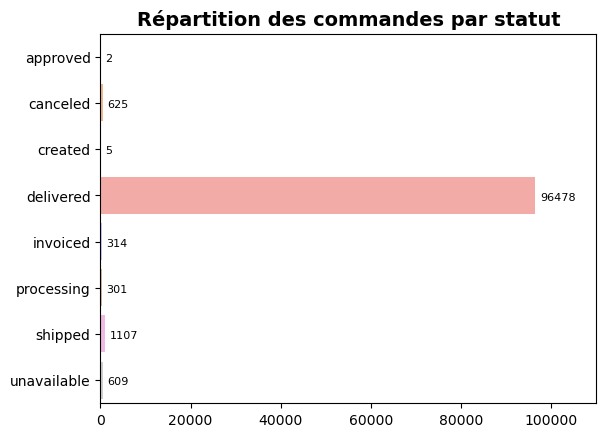

In [162]:
# Visualisation graphique
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=commande_statut, x="order_id", y="order_status")
    plt.xlabel('')
    plt.xlim(0,110000)
    plt.ylabel('')
    plt.title("Répartition des commandes par statut", fontname = 'Sans-serif', fontsize= 14, fontweight="bold")

nb_statut_commandes = commande_statut["order_id"]
for i, v in enumerate(nb_statut_commandes):
    plt.text(v+1000,i+0.1, int(v), fontsize=8, fontname="sans-serif")

plt.show()      

**Cette analyse a permis de mettre en évidence non seulement que la majorité des commandes sont délivrées mais aussi qu'il y a des commandes annulées et indisponibles...**

**LES COMMANDES INDISPONIBLES**

**Création du dataframe**

In [163]:
# Création d'un dataframe pour les commandes indisponibles
commandes_indisponibles = orders[(orders["order_status"]=="unavailable")]
commandes_indisponibles.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,NaT,2017-10-27


**Description de la variable "order_purchase_timestamp" pour les commandes indisponibles**

In [164]:
commandes_indisponibles["order_purchase_timestamp"].describe()

C:\Users\colin\AppData\Local\Temp\ipykernel_16564\3731212578.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  commandes_indisponibles["order_purchase_timestamp"].describe()


count                     609
unique                    607
top       2017-11-03 22:26:44
freq                        2
first     2016-10-05 14:16:28
last      2018-08-21 12:21:00
Name: order_purchase_timestamp, dtype: object

**Nous pouvons remarquer que la commande indisponible la plus récente date du 21 aout 2018, soit 2 mois avant la fin de notre jeu de données. Par conséquent, je trouve pertinent d'éliminer ces commandes du jeu d'analyse, mais de les conserver dans un dataframe contenant également les commandes annulées. La création de ce dataframe permettra un éventuel retour en arrière...**

**CREATION DU DATAFRAME CONTENANT LES COMMANDES ANNULEES ET INDISPONIBLES**

**Création du dataframe et vérification du nombre de lignes**

In [165]:
commandes_non_exploitables = orders[(orders["order_status"]=="canceled") | (orders["order_status"]=="unavailable")]
commandes_non_exploitables.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,NaT,2017-09-05


In [166]:
# Vérification du nombre de lignes (attendu 1234)
print(f'Ce jeu de données possèdent {commandes_non_exploitables.shape[0]} lignes.')

Ce jeu de données possèdent 1234 lignes.


**Elimination de ces commandes du jeu de données**

In [167]:
# Liste des index des commandes concernées
liste_commandes_non_exploitables = commandes_non_exploitables.index.tolist()

# Elimination du jeu de données
orders = orders[~orders.index.isin(liste_commandes_non_exploitables)]
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26


In [168]:
# Vérification du nombre de lignes (attendu 98207)
print(f'Le jeu de données possèdent désormais {orders.shape[0]} lignes.')

Le jeu de données possèdent désormais 98207 lignes.


In [169]:
# Informations sur le nouveau jeu de données
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98207 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98207 non-null  object        
 1   customer_id                    98207 non-null  object        
 2   order_status                   98207 non-null  object        
 3   order_purchase_timestamp       98207 non-null  datetime64[ns]
 4   order_delivered_customer_date  96470 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98207 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 5.2+ MB


**Le jeu de données présente des valeurs manquantes au niveau de la variable 'order_delivered_customer_date'. Ces dernières seront tout de suite imputées.**

### 6. L'imputation des valeurs manquantes

**CREATION D'UN DATAFRAME NE CONTENANT PAS LES VALEURS MANQUANTES**

In [170]:
# Création du dataframe
date_de_livraison_presente = orders[(orders["order_delivered_customer_date"].notna())]

# Information sur le dataframe
date_de_livraison_presente.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96470 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96470 non-null  object        
 1   customer_id                    96470 non-null  object        
 2   order_status                   96470 non-null  object        
 3   order_purchase_timestamp       96470 non-null  datetime64[ns]
 4   order_delivered_customer_date  96470 non-null  datetime64[ns]
 5   order_estimated_delivery_date  96470 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 5.2+ MB


**DELAI DE LIVRAISON**

**1. Création de la variable**

In [171]:
# Création d'une variable délai de livraison
date_de_livraison_presente["delai_livraison"] = (date_de_livraison_presente["order_delivered_customer_date"] - date_de_livraison_presente["order_purchase_timestamp"]).dt.round('1d').dt.days
date_de_livraison_presente.head()

C:\Users\colin\AppData\Local\Temp\ipykernel_16564\2211332037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_de_livraison_presente["delai_livraison"] = (date_de_livraison_presente["order_delivered_customer_date"] - date_de_livraison_presente["order_purchase_timestamp"]).dt.round('1d').dt.days


,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3


**2. Description de la nouvelle variable**

In [172]:
date_de_livraison_presente["delai_livraison"].describe()

count    96470.000000
mean        12.517052
std          9.550133
min          1.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        210.000000
Name: delai_livraison, dtype: float64

**La médiane et la moyenne étant très proche, l'imputation par la médiane à savoir 10 jours sera réalisée après quelques analyses graphiques.**

**3. Visualisation graphique du délai de livraison**

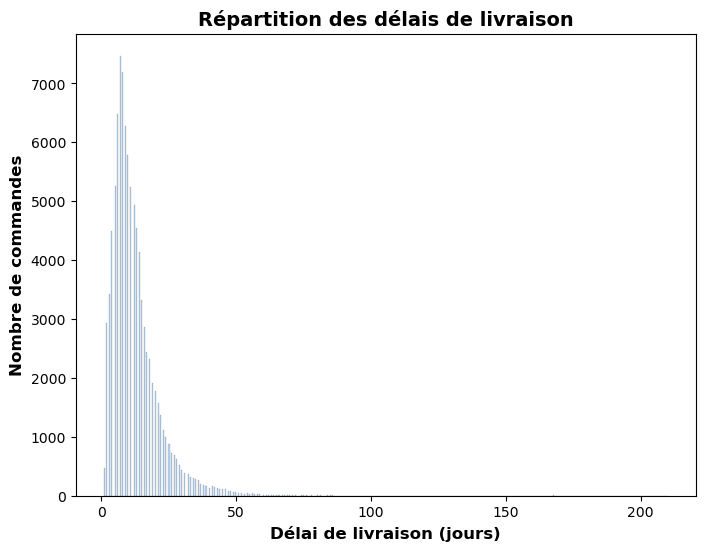

In [173]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=date_de_livraison_presente, x="delai_livraison")
    plt.xlabel('Délai de livraison (jours)', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('Nombre de commandes', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition des délais de livraison", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

**DIFFERENCE ENTRE LA DATE DE LIVRAISON ESTIMEE ET LA DATE DE LIVRAISON**

**1. Création d'une variable ecart_date**

In [174]:
date_de_livraison_presente["ecart_date"] = (date_de_livraison_presente["order_estimated_delivery_date"] - date_de_livraison_presente["order_delivered_customer_date"]).dt.round('1d').dt.days
date_de_livraison_presente.head()

C:\Users\colin\AppData\Local\Temp\ipykernel_16564\2029007729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_de_livraison_presente["ecart_date"] = (date_de_livraison_presente["order_estimated_delivery_date"] - date_de_livraison_presente["order_delivered_customer_date"]).dt.round('1d').dt.days


,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9


**2. Description de cette nouvelle variable**

In [175]:
date_de_livraison_presente["ecart_date"].describe()

count    96470.000000
mean        11.007660
std         10.188854
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: ecart_date, dtype: float64

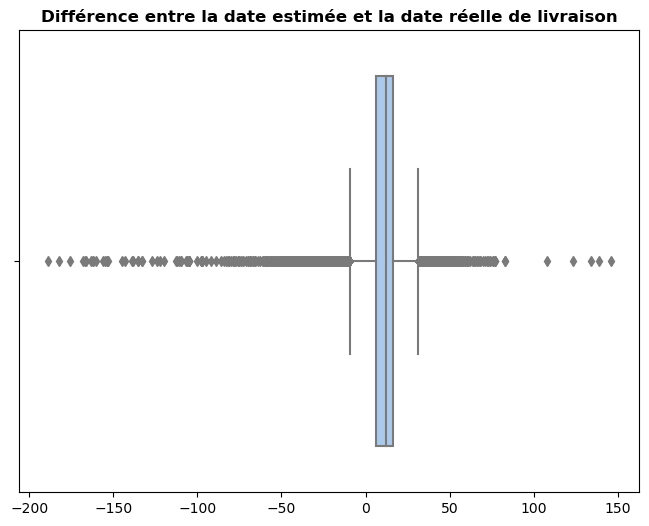

In [176]:
# Visualisation par histogramme

plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=date_de_livraison_presente, x="ecart_date")
    plt.xlabel('')
    plt.title("Différence entre la date estimée et la date réelle de livraison", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    
plt.show()

Les commandes sont davantage livrées avant la date estimée de livraison. Néanmoins, nous pouvons constater qu'il y a tout de même beauconp de retard de livraisons.

**IMPUTATION DES VALEURS MANQUANTES**

**1. Création d'une variable provisoire ajoutant 10 jours à toutes les commandes**

In [177]:
orders["10_jours"] = orders['order_purchase_timestamp'] + pd.to_timedelta(10, unit='d')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,10_jours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2017-10-12 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,2018-08-03 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,2018-08-18 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,2017-11-28 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,2018-02-23 21:18:39


**2. Création d'un dataframe dont la date de livraison n'est pas renseignée**

In [178]:
date_de_livraison_manquante = orders[orders["order_delivered_customer_date"].isna()]
date_de_livraison_manquante.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,10_jours
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,NaT,2017-05-09,2017-04-21 12:22:08
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,NaT,2018-06-28,2018-06-14 16:44:48
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,NaT,2018-08-21,2018-08-13 17:44:42
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,NaT,2017-10-03,2017-09-13 14:22:03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,NaT,2018-02-07,2018-01-20 11:33:07


In [179]:
# Vérification du nombre de lignes (attendu 1737)
print(f'La date de livraison n\'est pas renseignée sur {date_de_livraison_manquante.shape[0]} lignes.')

La date de livraison n'est pas renseignée sur 1737 lignes.


**3. Récupération des index de ces lignes**

In [180]:
liste_date_de_livraison_manquante = date_de_livraison_manquante.index.tolist()

**4. Attribution des valeurs**

In [181]:
for idx in liste_date_de_livraison_manquante:
    orders.loc[idx, "order_delivered_customer_date"] = orders.loc[idx, "10_jours"]
    
orders.head(7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,10_jours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2017-10-12 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,2018-08-03 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,2018-08-18 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,2017-11-28 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,2018-02-23 21:18:39
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-26 10:57:55,2017-08-01,2017-07-19 21:57:05
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-21 12:22:08,2017-05-09,2017-04-21 12:22:08


**5. Ajout des variables 'delai_livraison' et 'ecart_livraison' au jeu de données 'orders'**

In [182]:
# delai_livraison
orders["delai_livraison"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.round('1d').dt.days

# ecart_livraison
orders["ecart_livraison"] = (orders["order_estimated_delivery_date"] - orders["order_delivered_customer_date"]).dt.round('1d').dt.days

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,10_jours,delai_livraison,ecart_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2017-10-12 10:56:33,8,7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,2018-08-03 20:41:37,14,5
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,2018-08-18 08:38:49,9,17
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,2017-11-28 19:28:06,13,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,2018-02-23 21:18:39,3,9


In [183]:
# Informations sur le nouveau jeu de données
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98207 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98207 non-null  object        
 1   customer_id                    98207 non-null  object        
 2   order_status                   98207 non-null  object        
 3   order_purchase_timestamp       98207 non-null  datetime64[ns]
 4   order_delivered_customer_date  98207 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98207 non-null  datetime64[ns]
 6   10_jours                       98207 non-null  datetime64[ns]
 7   delai_livraison                98207 non-null  int64         
 8   ecart_livraison                98207 non-null  int64         
dtypes: datetime64[ns](4), int64(2), object(3)
memory usage: 9.5+ MB


L'imputation s'est correctement réalisée. De ce fait, la variable provisoire peut-être éliminée...

In [184]:
orders = orders.drop("10_jours", axis=1)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9


### 7. L'évolution des commandes dans le jeu de données

**CREATION D'UN DATAFRAME SPECIAL POUR CETTE ANALYSE**

In [185]:
commande_evolution = orders.groupby(orders["order_purchase_timestamp"].dt.date).count()["order_id"].reset_index()
commande_evolution.columns = ['Jour de la commande', 'Nombre de commandes']
commande_evolution.head()

,Jour de la commande,Nombre de commandes
0,2016-09-04,1
1,2016-09-15,1
2,2016-10-03,7
3,2016-10-04,58
4,2016-10-05,42


**VISUALISATION DE L'EVOLUTION DES COMMANDES**

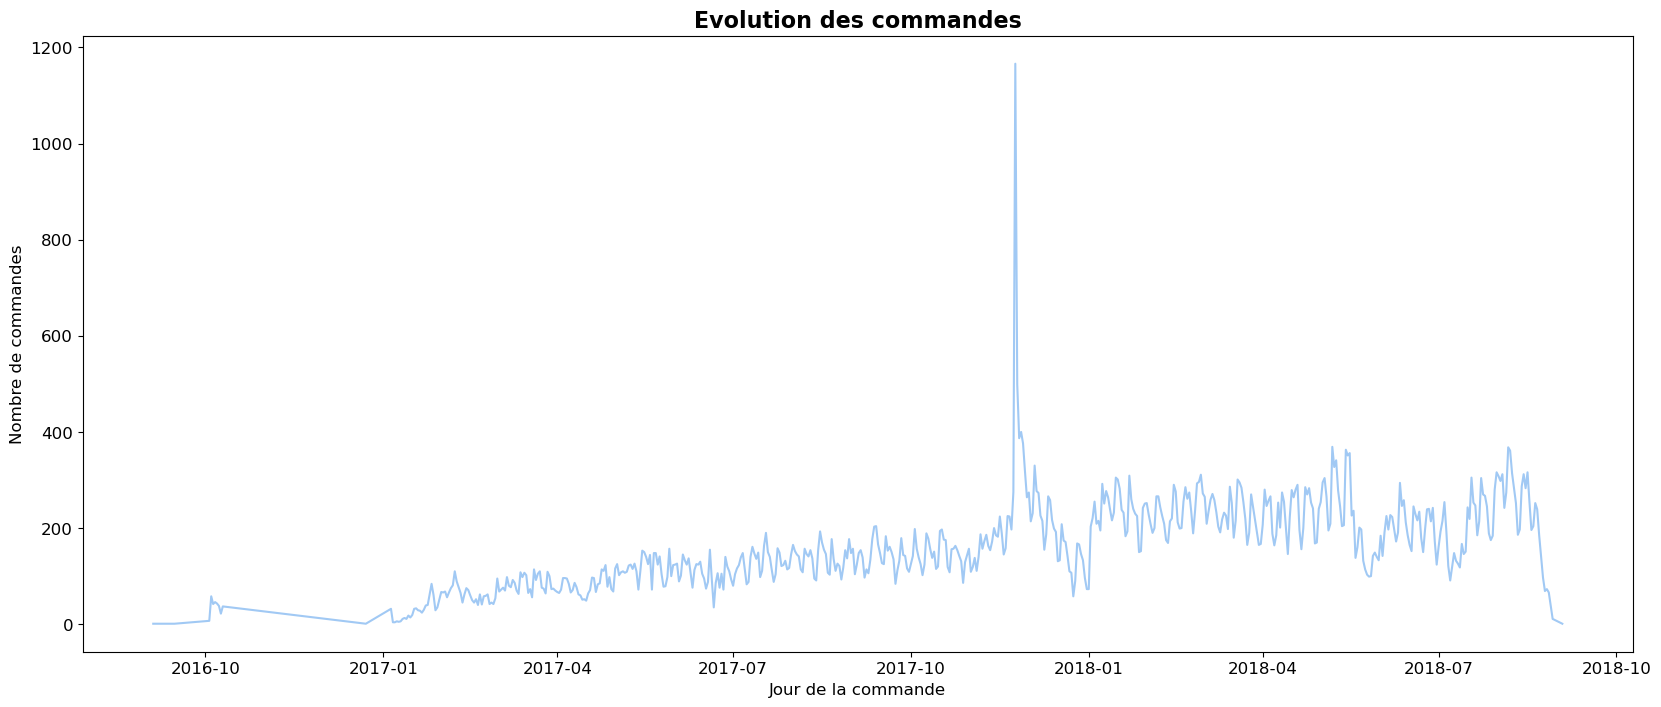

In [186]:
plt.figure(figsize=(20, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":12})
    sns.lineplot(data=commande_evolution, x= "Jour de la commande" , y = "Nombre de commandes")
    plt.title("Evolution des commandes", fontname = 'sans-serif', fontsize= 16, fontweight="bold")

plt.show()

**Nous pouvons tout d'abord observer un pic fin d'année 2017, pouvant correspondre aux cadeaux de fin d'année, pic n'apparaissant pas fin 2016 (site crée le 23 février 2015, donc récent). Ensuite, une chute drastique apparait vers septembre 2018 jusque la fin des données en notre possession.**

**Sur les 3 années présentes dans ce jeu de données, seule l'année 2018 est entièrement présente. De ce fait, je ne trouve pas pertinent d'analyser la répartition des commandes par mois car les données seraient biaisées.**

## 1.5. La table des commentaires 'olist_order_reviews_dataset'

### 1. Informations générales sur le jeu de données

In [187]:
# Ouverture du fichier
df_5 = pd.read_csv("olist_order_reviews_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_5.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [188]:
# Copie du fichier
order_reviews = df_5.copy()

In [189]:
# Vérification de l'absence de doublon
print(f'Cette table contient {order_reviews[["review_id", "order_id", "review_creation_date", "review_answer_timestamp"]].duplicated().sum()} doublon(s).')

Cette table contient 0 doublon(s).


In [190]:
# Dimension du jeu de données
print(f'Cette 5ème table comprend {order_reviews.shape[0]} lignes et {order_reviews.shape[1]} variables.')

Cette 5ème table comprend 99224 lignes et 7 variables.


In [191]:
# Infos sur le jeu de données
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


**Cette table stocke les questionnaires de satisfaction des clients.**

**ATTENTION**
- **Les commnandes annulées et indisponibles ont été précédemment supprimées de la table des commandes. Ainsi, il est préférable de réaliser la jointure entre ces 2 tables avant d'effectuer une analyse et un nettoyage des données.**

## 2. La jointure avec la table des commandes 

**Cette jointure sera réalisée grâce à la clé étrangère 'order_id'.**

**REALISATION DE LA JOINTURE**

In [192]:
order_avis = pd.merge(orders, order_reviews, on="order_id", how='left')
order_avis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


**Informations sur le jeu de données obtenu**

In [193]:
order_avis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98752 entries, 0 to 98751
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98752 non-null  object        
 1   customer_id                    98752 non-null  object        
 2   order_status                   98752 non-null  object        
 3   order_purchase_timestamp       98752 non-null  datetime64[ns]
 4   order_delivered_customer_date  98752 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98752 non-null  datetime64[ns]
 6   delai_livraison                98752 non-null  int64         
 7   ecart_livraison                98752 non-null  int64         
 8   review_id                      98018 non-null  object        
 9   review_score                   98018 non-null  float64       
 10  review_comment_title           11417 non-null  object        
 11  review_comment_

**PREMIERS CONSTATS**
- Toutes les commandes ne sont pas 'notées'.
- Un review_id est crée pour chaque produit d'une commande. Ainsi, la variable 'review_id' renvoie un score pour un produit d'une commande.
- Présence de valeurs manquantes au niveau de 2 variables qui ne présentent aucune utilité pour notre mission et qui plus sont en portugais. Ces dernières seront donc tout de suite supprimées.
- Comme précédemment, nous sommes en présence de dates référencées en type 'object'. Celles-ci seront donc retypées afin de créer une variable delai_reponse puis éliminées du jeu de données.
- Visualisation de la répartition des scores pour les questionnaires remplis.
- Visualisation du délai de réponse pour les questionnaires remplis.
- Gestion des données manquantes:
    - Création d'une variable précisant si le produit a été noté ou non (0 pour non et 1 pour oui)
    - Imputation des valeurs manquantes pour les scores.

### 3. Réalisation des modifications

**ELIMINATION DES 2 VARIABLES**

In [194]:
# Elimination des 2 variables
order_avis = order_avis.drop(["review_comment_title", "review_comment_message"], axis=1)

# Vérification du jeu de données
order_avis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98752 entries, 0 to 98751
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98752 non-null  object        
 1   customer_id                    98752 non-null  object        
 2   order_status                   98752 non-null  object        
 3   order_purchase_timestamp       98752 non-null  datetime64[ns]
 4   order_delivered_customer_date  98752 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98752 non-null  datetime64[ns]
 6   delai_livraison                98752 non-null  int64         
 7   ecart_livraison                98752 non-null  int64         
 8   review_id                      98018 non-null  object        
 9   review_score                   98018 non-null  float64       
 10  review_creation_date           98018 non-null  object        
 11  review_answer_t

**CONVERSION DES DATES**

In [195]:
# Liste des colonnes à convertir
review_date_conversion = ["review_creation_date", "review_answer_timestamp"]

# Conversion en date
for col in review_date_conversion:
    order_avis[col] = pd.to_datetime(order_avis[col], format= "%Y-%m-%d %H:%M:%S")
    
# Vérification de la bonne conversion
order_avis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98752 entries, 0 to 98751
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98752 non-null  object        
 1   customer_id                    98752 non-null  object        
 2   order_status                   98752 non-null  object        
 3   order_purchase_timestamp       98752 non-null  datetime64[ns]
 4   order_delivered_customer_date  98752 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98752 non-null  datetime64[ns]
 6   delai_livraison                98752 non-null  int64         
 7   ecart_livraison                98752 non-null  int64         
 8   review_id                      98018 non-null  object        
 9   review_score                   98018 non-null  float64       
 10  review_creation_date           98018 non-null  datetime64[ns]
 11  review_answer_t

**La conversion a bien été réalisée.**

**VISUALISATION DE LA REPARTITION DES SCORES APRES JOINTURE**

In [196]:
# Création du dataframe 
order_score = order_avis.groupby("review_score")["review_id"].count().reset_index()
order_score

,review_score,review_id
0,1.0,10539
1,2.0,3064
2,3.0,8096
3,4.0,19096
4,5.0,57223


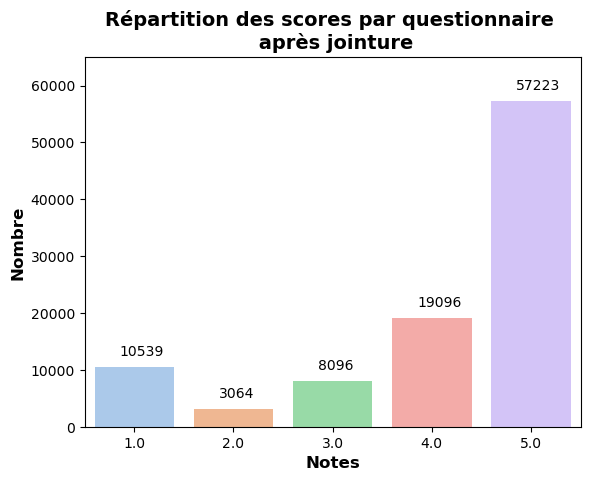

In [197]:
# Visualisation graphique
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=order_score, x="review_score", y="review_id")
    plt.xlabel("Notes", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylim(0,65000)
    plt.ylabel("Nombre", fontname = 'Sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition des scores par questionnaire \n après jointure", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

nb_score = order_score["review_id"]
for i, v in enumerate(nb_score):
    plt.text(i-0.15,v+2000, int(v), fontsize=10, fontname="sans-serif")

plt.show()    

**La majorité des clients ayant répondu au questionnaire sont satisfaits des produits achetés.**

**LE DELAI DE REPONSE**

**Création de la variable**

In [198]:
order_avis["delai_reponse"] = (order_avis["review_answer_timestamp"] - order_avis["review_creation_date"]).dt.round('1d').dt.days
order_avis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_id,review_score,review_creation_date,review_answer_timestamp,delai_reponse
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08,2018-08-08 18:37:50,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18,2018-08-22 19:07:58,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,359d03e676b3c069f62cadba8dd3f6e8,5.0,2017-12-03,2017-12-05 19:21:58,3.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,e50934924e227544ba8246aeb3770dd4,5.0,2018-02-17,2018-02-18 13:02:51,2.0


**Description de la variable**

In [199]:
order_avis["delai_reponse"].describe()

count    98018.000000
mean         3.205697
std          9.752549
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        519.000000
Name: delai_reponse, dtype: float64

**Visualisation graphique du délai de réponse**

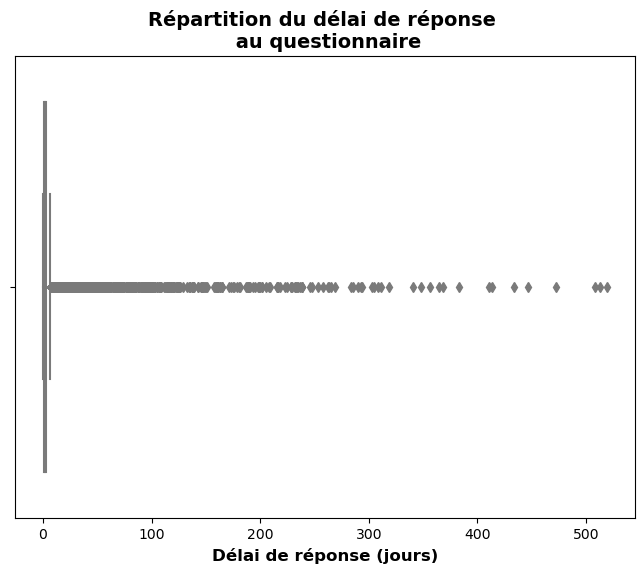

In [200]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=order_avis, x="delai_reponse")
    plt.xlabel('Délai de réponse (jours)', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('')
    plt.title("Répartition du délai de réponse \n au questionnaire", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

**La majeure partie des clients sont réactifs...**

**ELIMINATION DES VARIABLES DEVENUES INUTILES**

In [201]:
order_avis = order_avis.drop(["review_creation_date", "review_answer_timestamp"], axis=1)
order_avis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_id,review_score,delai_reponse
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,a54f0611adc9ed256b57ede6b6eb5114,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,8d5266042046a06655c8db133d120ba5,4.0,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,e73b67b67587f7644d5bd1a52deb1b01,5.0,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,359d03e676b3c069f62cadba8dd3f6e8,5.0,3.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,e50934924e227544ba8246aeb3770dd4,5.0,2.0


In [202]:
# Informations sur le jeu de données
order_avis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98752 entries, 0 to 98751
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98752 non-null  object        
 1   customer_id                    98752 non-null  object        
 2   order_status                   98752 non-null  object        
 3   order_purchase_timestamp       98752 non-null  datetime64[ns]
 4   order_delivered_customer_date  98752 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98752 non-null  datetime64[ns]
 6   delai_livraison                98752 non-null  int64         
 7   ecart_livraison                98752 non-null  int64         
 8   review_id                      98018 non-null  object        
 9   review_score                   98018 non-null  float64       
 10  delai_reponse                  98018 non-null  float64       
dtypes: datetime64[n

**Les données manquantes concernant les variables 'review_id' et 'review_score' seront complétées après quelques visualisations.**

**IMPUTATION DES VALEURS MANQUANTES**

**Imputation pour la variable 'review_id'**

Il s'agit en réalité de créer une sorte de variable 'boléenne', à savoir 1 si le client a répondu au questionnaire et 0 s'il n'a pas répondu.

In [203]:
# Création de la nouvelle variable d
order_avis["avis_donne"] = np.where(order_avis["review_id"].notna(), 1, 0)
order_avis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_id,review_score,delai_reponse,avis_donne
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,a54f0611adc9ed256b57ede6b6eb5114,4.0,1.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,8d5266042046a06655c8db133d120ba5,4.0,1.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,e73b67b67587f7644d5bd1a52deb1b01,5.0,5.0,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,359d03e676b3c069f62cadba8dd3f6e8,5.0,3.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,e50934924e227544ba8246aeb3770dd4,5.0,2.0,1


In [204]:
# Comptage du nombre de 1 et 0 dans la nouvelle variable (attendu 0= 734)
order_avis["avis_donne"].value_counts()

1    98018
0      734
Name: avis_donne, dtype: int64

Seuls 7,4% des produits ne possèdent pas de note

In [205]:
# Elimination de la variable 'review_id' devenue inutile
order_avis = order_avis.drop("review_id", axis=1)
order_avis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1


**Imputation pour le score**

In [206]:
# Description de la variable 'review_score'
order_avis["review_score"].describe()

count    98018.000000
mean         4.116122
std          1.321234
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

Il sera indispensable de combler les valeurs manquantes concernant les scores. Cette imputation sera réalisée lors de l'aggrégation des dataframes ciblée sur le client (imputation par 4).

**INFORMATIONS SUR LE JEU DE DONNEES**

In [207]:
order_avis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98752 entries, 0 to 98751
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98752 non-null  object        
 1   customer_id                    98752 non-null  object        
 2   order_status                   98752 non-null  object        
 3   order_purchase_timestamp       98752 non-null  datetime64[ns]
 4   order_delivered_customer_date  98752 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98752 non-null  datetime64[ns]
 6   delai_livraison                98752 non-null  int64         
 7   ecart_livraison                98752 non-null  int64         
 8   review_score                   98018 non-null  float64       
 9   delai_reponse                  98018 non-null  float64       
 10  avis_donne                     98752 non-null  int32         
dtypes: datetime64[n

In [208]:
commandes_order_avis = order_avis["order_id"].unique().tolist()
len(commandes_order_avis)

98207

**Nous sommes en présence d'un jeu de données comprenant 98207 commandes, présentant uniquement des valeurs manquantes au niveau des variables 'review_score' et 'delai_reponse'.**

## 1.6. La table des produits achetés "olist_order_items_dataset"

### 1. Informations générales sur le jeu de données

In [209]:
# Ouverture du fichier
df_6 = pd.read_csv("olist_order_items_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_6.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [210]:
# Copie du fichier
order_items = df_6.copy()

In [211]:
# Dimension du jeu de données
print(f'Cette 6ème table comprend {order_items.shape[0]} lignes et {order_items.shape[1]} variables.')

Cette 6ème table comprend 112650 lignes et 7 variables.


In [212]:
# Vérification de l'absence de doublon
print(f'Cette 6ème table présente {order_items[["order_id", "order_item_id", "shipping_limit_date"]].duplicated().sum()} doublon(s) au niveau des commandes.')

Cette 6ème table présente 0 doublon(s) au niveau des commandes.


In [213]:
# Infos sur le jeu de données
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Cette table ne présente pas de donnée manquante.

**Conversion immédiate de la variable 'shipping_limit_date' en date**

In [214]:
# Conversion en type date
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], format="%Y-%m-%d %H:%M:%S")

# Vérification de la bonne conversion
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


**EXPLICATION DE CETTE TABLE**
- **'order_id'**:  clé étrangère pour sa mise en relation avec la table 'olist_orders_dataset'.
- **'order_item_id'**: Nombre séquentiel identifiant le nombre d'articles (identiques ou différents) inclus dans une même commande.
- **'product_id'**: Unique pour chaque produit et clé étrangère pour sa mise en relation avec la table 'olist_products_dataset'.
- **'shipping_limit_date', 'price' et 'freight_value'**: informations sur les commandes

**ATTENTION**
- Les commandes indisponibles et annulées ont été retirées. De ce fait, la jointure de cette table avec la table précédente sera immédiatement réalisée.

**MINI-EXPLORATION**
- Analyse du nombre des différents produits achetés.
- Analyse de nombre de commandes présentes.
- Répartition des prix des produits
- Répartition des frais de port.

**A NOTER**: Des analyses plus appronfondies seront réalisées après les différentes jointures.

### 2. Jointure avec la table précédente

**LA JOINTURE EN ELLE-MEME**

In [215]:
jointure_order_item = pd.merge(order_avis, order_items, on='order_id', how = 'left')
jointure_order_item.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


**INFORMATIONS SUR LE JEU DE DONNEES**

In [216]:
jointure_order_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112769 entries, 0 to 112768
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112769 non-null  object        
 1   customer_id                    112769 non-null  object        
 2   order_status                   112769 non-null  object        
 3   order_purchase_timestamp       112769 non-null  datetime64[ns]
 4   order_delivered_customer_date  112769 non-null  datetime64[ns]
 5   order_estimated_delivery_date  112769 non-null  datetime64[ns]
 6   delai_livraison                112769 non-null  int64         
 7   ecart_livraison                112769 non-null  int64         
 8   review_score                   111842 non-null  float64       
 9   delai_reponse                  111842 non-null  float64       
 10  avis_donne                     112769 non-null  int32         
 11  

**Nous sommes en présence d'un jeu incomplet de données suite à cette jointure. En effet, il nous manque 8 données concernant des critères fondamentaux (le produit, le prix, le vendeur), ce qui rend ces 8 lignes inexploitables... Elles seront donc éliminées dès à présent du jeu de données avec tout de même une petite analyse préalable.**

In [217]:
commandes_jointure_order_item = jointure_order_item["order_id"].unique().tolist()
len(commandes_jointure_order_item)

98207

**ANALYSE DES 8 LIGNES MANQUANTES**

In [218]:
produits_mysteres = jointure_order_item[jointure_order_item["product_id"].isna()]
produits_mysteres

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8384,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,2017-12-15 01:07:52,2018-01-11,10,27,1.0,2.0,1,NaN,NaN,NaN,NaT,NaN,NaN
10415,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,2018-02-19 17:21:04,2018-03-07,10,15,NaN,NaN,0,NaN,NaN,NaN,NaT,NaN,NaN
24269,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,2017-12-05 11:10:33,2017-12-12,10,7,1.0,1.0,1,NaN,NaN,NaN,NaT,NaN,NaN
26330,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-15 01:47:40,2016-12-01,10,47,1.0,9.0,1,NaN,NaN,NaN,NaT,NaN,NaN
62390,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,2017-12-15 01:07:58,2018-01-08,10,24,NaN,NaN,0,NaN,NaN,NaN,NaT,NaN,NaN
65204,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-15 21:03:33,2016-11-25,10,40,1.0,7.0,1,NaN,NaN,NaN,NaT,NaN,NaN
66738,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,2017-11-16 13:12:34,2017-12-01,10,14,5.0,0.0,1,NaN,NaN,NaN,NaT,NaN,NaN
79221,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-15 13:22:20,2016-11-29,10,44,1.0,2.0,1,NaN,NaN,NaN,NaT,NaN,NaN


**Il s'agit de commandes créées, envoyées ou facturées et qui peuvent même être notées avant leur livraison (5 scores de 1 et 1 score de 5)!!! Il est donc tout à fait pertinent d'éliminer ces lignes.**

**ELIMINATION DE CES 8 PRODUITS MYSTERES**

In [219]:
# Liste des index des 8 lignes
liste_produits_mysteres = produits_mysteres.index.tolist()

# Elimination du jeu de données
jointure_order_item = jointure_order_item[~jointure_order_item.index.isin(liste_produits_mysteres)]
jointure_order_item.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [220]:
# Vérification du nombre de lignes (attendu 112761)
print(f'Après élimination de ces 8 lignes, le jeu de données en contient désormais {jointure_order_item.shape[0]} lignes.')

Après élimination de ces 8 lignes, le jeu de données en contient désormais 112761 lignes.


### 2. Analyses et visualisations

**ANALYSE DU NOMBRE DES DIFFERENTS PRODUITS ACHETES**

In [221]:
# Liste des différents produits achetés
produits_uniques_achetes = jointure_order_item["product_id"].unique().tolist()

# Longueur de la liste correspondant au nombre des didfférents produis achetés
len(produits_uniques_achetes)

32729

**32729 produits différents ont été achetés.**

**NOMBRE DE COMMANDES PRESENTES**

In [222]:
# Liste du nombre de commandes présentes
commandes_presentes = jointure_order_item["order_id"].unique().tolist()

# Longueur de la liste correspondant au nombre des didfférentes commandes présentes
len(commandes_presentes)

98199

**VISUALISATION DE LA REPARTITION DES PRIX DES PRODUITS**

**Description de la variable 'price'**

In [223]:
jointure_order_item["price"].describe()

count    112761.000000
mean        120.202865
std         182.288221
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

**Visualisation graphique de la répartition des prix**

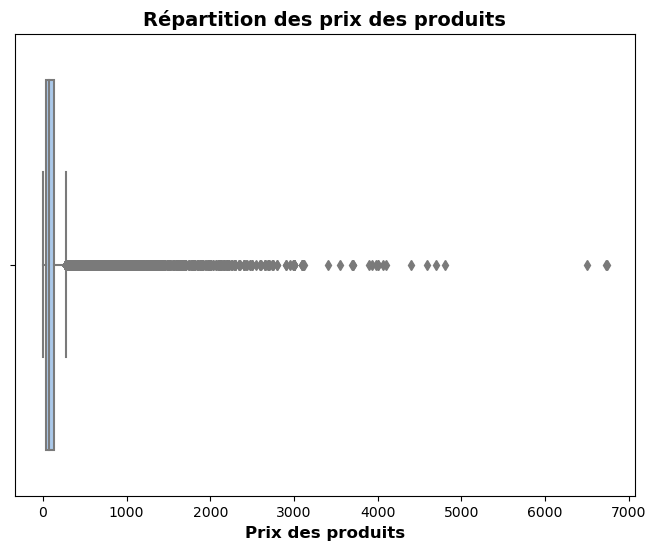

In [224]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=jointure_order_item, x="price")
    plt.xlabel('Prix des produits', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('')
    plt.title("Répartition des prix des produits", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

A NOTER: Nous pouvons remarquer la présence de valeurs à priori atypiques et non aberrantes dans le jeu de données. Néanmoins, il est trop précoce pour déterminer s'il s'agit vraiment de valeurs atypiques. Nous le saurons lors de l'analyse des catégories de produits.

**VISUALISATION DE LA DISTRIBUTION DES FRAIS DE PORT**

**Description de la variable 'freight_value'**

In [225]:
jointure_order_item["freight_value"].describe()

count    112761.000000
mean         19.980315
std          15.773540
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

**Visualisation de la répartition des frais de port par boxplot**

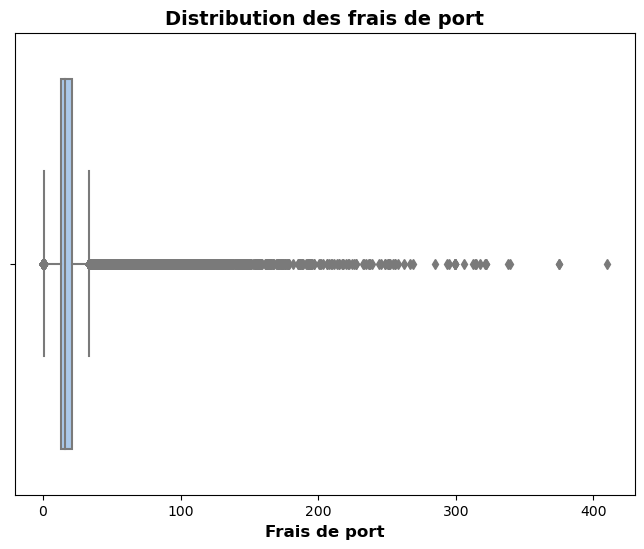

In [226]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=jointure_order_item, x="freight_value")
    plt.xlabel('Frais de port', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('')
    plt.title("Distribution des frais de port", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

Certains frais de port me semble atypique... Néanmoins, il se peut qu'il s'agissent de produits onéreux possédant un gros volume. L'analyse de la prochaine table permettra de répondre à ces questions...

## 1.7. La table des produits 'olist_products_dataset'

### 1. Informations générales sur le jeu de données

In [227]:
# Ouverture du fichier
df_7 = pd.read_csv("olist_products_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_7.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [228]:
# Copie du fichier
products = df_7.copy()

In [229]:
# Dimension du jeu de données
print(f'Cette 7ème table comprend {products.shape[0]} produits et {products.shape[1]} variables.')

Cette 7ème table comprend 32951 produits et 9 variables.


In [230]:
# Vérification de l'absence de doublon au niveau de la variable 'product_id'
products_uniques = products["product_id"].unique().tolist()
len(products_uniques)

32951

**Nous pouvons constater que tous les produits présents sur le site d'olist n'ont pas forcément été achetés (32729 achetés).**

In [231]:
# Informations sur le jeu de données
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Cette table présente des données manquantes au niveau de la description des produits mais aussi de la catégorie.Ceci pourrait être préjudiciable pour leur vente...

**Nombre de catégories présentes**

In [232]:
# Création d'une liste contenant les différentes catégories
categorie_unique = products["product_category_name"].unique().tolist()

# Nombre de catégories
len(categorie_unique)

74

Nous sommes en présence de 74 catégories de produits. Comme ces dernières devront être encodés, un regroupement est envisagé. Néanmoins, ce dernier ne sera pas réalisé dans l'immédiat car ce n'est qu'une possibilité et que ces dernières sont renseignées en portugais dans cette table.

**EXPLICATION DE CETTE TABLE**
- **'product_id'**: Unique pour chaque produit et clé étrangère pour sa mise en relation avec la table 'olist_order_items_dataset'.
- **'product_category_name'**:  Catégories du produit en portugais.
- **'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'**: Détails sur le produit.

**EXPLORATION, NETTOYAGE ET IMPUTATION DES VALEURS MANQUANTES**
- Elimination des variables 'product_name_lenght', 'product_description_lenght' et 'product_photos_qty' n'ayant aucun intérêt dans notre mission.
- Analyse du nombre de catégories.
- Imputation des valeurs manquantes:
    - 'Unknown' pour la variable 'product_category_name'
    - Imputation par la médiane générale pour les variables 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
    
**CREATION D'UNE VARIABLE VOLUME DU PRODUIT**
- Ne sachant pas encore si les variables caractérisant les dimensions du produit et son poids seront conservées, une variable produit_volume sera créée.

**JOINTURE DE CETTE TABLE AVEC LA TABLE PRECEDENTE**
- Cette jointure permettra d'analyser les valeurs atypiques observées au niveau des prix et des fais de port.

### 2. Elimination des 3 variables inutiles

In [233]:
products = products.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], axis=1)
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


### 3. Analyse de la distribution des poids et des dimensions des produits

**ANALYSE DE LA DISTRIBUTION DU POIDS DES PRODUITS**

**1. Description de la variable 'product_weight_g'**

In [234]:
products["product_weight_g"].describe()

count    32949.000000
mean      2276.472488
std       4282.038731
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64

A NOTER: 0 gramme est de mon point de vue une valeur aberrante. Ceci sera vérifié lors de l'analyse des catégories.

**2. Visualisation par histogramme de la répartition des poids des produits**

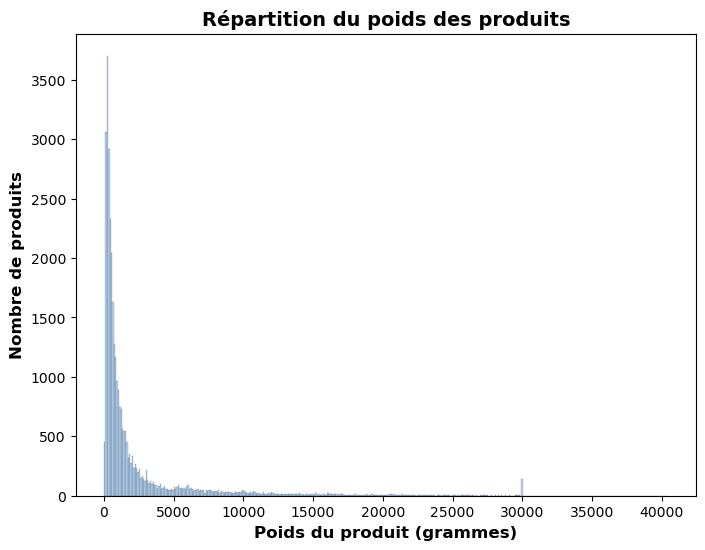

In [235]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=products, x="product_weight_g")
    plt.xlabel('Poids du produit (grammes)', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('Nombre de produits', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition du poids des produits", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

Nous sommes en présence d'une distribution asymétrique avec davantage de produits 'légers'.

**CREATION DE LA VARIABLE VOLUME DU PRODUIT**

In [236]:
products["produit_volume_cm3"] = products["product_length_cm"]*products["product_height_cm"]*products["product_width_cm"]
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0


**Description de cette nouvelle variable**

In [237]:
products["produit_volume_cm3"].describe()

count     32949.000000
mean      16564.096695
std       27057.041650
min         168.000000
25%        2880.000000
50%        6840.000000
75%       18480.000000
max      296208.000000
Name: produit_volume_cm3, dtype: float64

**Visualisation par histogramme de la distribution de volume des produits**

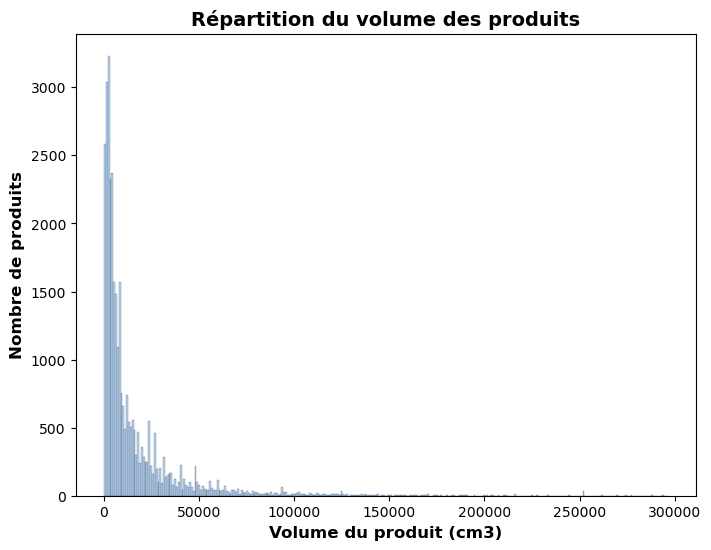

In [238]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=products, x="produit_volume_cm3")
    plt.xlabel('Volume du produit (cm3)', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('Nombre de produits', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition du volume des produits", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

Nous pouvons remarquer la même répartition asymétrique que précédemment, ce qui en soit me semble logique. Cette corrélation linéaire sera analysés via la matrice de corrélation de Pearson. 

**MATRICE DE CORRELATION DE PEARSON**

**1. Création du dataframe**

In [239]:
pearson = products[(products["product_weight_g"].notna()) & (products["product_length_cm"].notna()) & 
                               (products["product_height_cm"].notna()) & (products["product_width_cm"].notna())
                    & (products["produit_volume_cm3"].notna())] 
person = pearson.drop(["product_id", "product_category_name"], axis=1)

pearson.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0


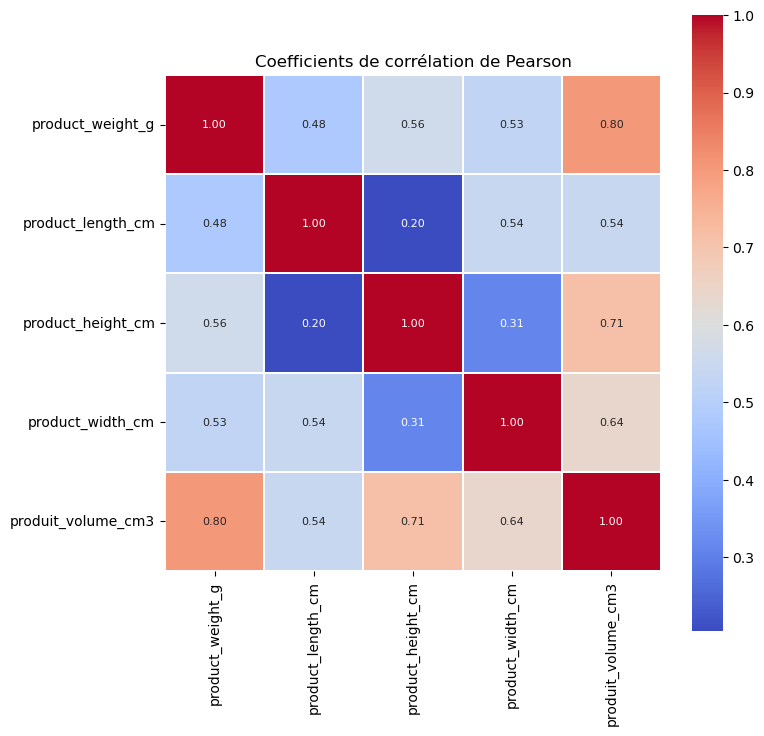

In [240]:
# Matrice des corrélations
corr_mat = pearson.corr()

# heatmap
fig = plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, fmt=".2f", annot_kws={'size':8}, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

Nous avons bien une corrélation de 0.8 entre le poids et le volume...

**A NOTER: L'analyse du poids des produits, ainsi que de leur volume, a été réalisée afin de se familiariser avec le jeu de données. Comme ces données n'ont aucune utilité d'un point de vue profil client, elles ne seront pas utilisées pour le clustering, ces dernières n'entrant pas en compte dans notre mission. Néanmoins, par principe, les données manquantes seront imputées.**

### 4. Imputation des valeurs manquantes

**IMPUTATION POUR LA VARIABLE 'product_category_name'**

In [241]:
# Imputation par Unknwown
products["product_category_name"] = products["product_category_name"].fillna(value="Unknown")

# Vérification de cette table à ce stade
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32951 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
 6   produit_volume_cm3     32949 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.8+ MB


**La première imputation ont été correctement réalisée.**

**IMPUTATION POUR LES VARIABLES 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm' et 'produit_volume_cm3'**

**Création du dataframe pour les 2 produits non renseignés**

In [242]:
# Création du dataframe comprenant les produits non renseignés pour ces variables
produits_incomplets = products[(products["product_weight_g"].isna()) | (products["product_length_cm"].isna()) | 
                               (products["product_height_cm"].isna()) | (products["product_width_cm"].isna()) |
                              (products["produit_volume_cm3"].isna())] 
produits_incomplets

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3
8578,09ff539a621711667c43eba6a3bd8466,bebes,NaN,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,Unknown,NaN,NaN,NaN,NaN,NaN


In [243]:
# Création du dataframe comprenant toutes les catégories
toutes_categories = products[["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm", "produit_volume_cm3"]]

# Description du dataframe
toutes_categories.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3
count,32949.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728,16564.096695
std,4282.038731,16.914458,13.637554,12.079047,27057.041650
min,0.000000,7.000000,2.000000,6.000000,168.000000
25%,300.000000,18.000000,8.000000,15.000000,2880.000000
50%,700.000000,25.000000,13.000000,20.000000,6840.000000
75%,1900.000000,38.000000,21.000000,30.000000,18480.000000
max,40425.000000,105.000000,105.000000,118.000000,296208.000000


**Imputation pour les variables renseignant le poids et la taille du produit**

Sur les 2 produits non renseignés, un seul présente une catégorie... Afin de réaliser une imputation homogène, cette dernière sera réalisée sur la médiane des différentes variables.

In [244]:
# Imputation par la médiane
products["product_weight_g"] = products["product_weight_g"].fillna(value=700.000000)
products["product_length_cm"] = products["product_length_cm"].fillna(value=25.000000)
products["product_height_cm"] = products["product_height_cm"].fillna(value=13.000000)
products["product_width_cm"] = products["product_width_cm"].fillna(value=20.000000)
products["produit_volume_cm3"] = products["produit_volume_cm3"].fillna(value=6840.000000)

# Vérification de la bonne imputation sur un produit
products.iloc[8578, :]

product_id               09ff539a621711667c43eba6a3bd8466
product_category_name                               bebes
product_weight_g                                    700.0
product_length_cm                                    25.0
product_height_cm                                    13.0
product_width_cm                                     20.0
produit_volume_cm3                                 6840.0
Name: 8578, dtype: object

L'imputation s'est correctement réalisée.

## 1.8. La table de correspondance 'product_category_name_translation.csv'

### 1. Informations générales sur le jeu de données

In [245]:
# Ouverture du fichier
df_8 = pd.read_csv("product_category_name_translation.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_8.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [246]:
# Copie du fichier
product_category = df_8.copy()

In [247]:
# Dimension du jeu de données
print(f'Cette 8ème table comprend {product_category.shape[0]} lignes et {product_category.shape[1]} variables.')

Cette 8ème table comprend 71 lignes et 2 variables.


In [248]:
# Infos sur le jeu de données
product_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


**Nous pouvons constater une discordance au niveau du nombre de catégories entre cette table (71) et la table 'olist_products_dataset' qui en référence 74.**

In [249]:
# Différence entre les 2 tables

liste_categorie_correspondance = product_category["product_category_name"].unique().tolist()

difference_1 = set(categorie_unique).difference(set(liste_categorie_correspondance))
difference_2 = set(liste_categorie_correspondance).difference(set(categorie_unique))

liste_difference = list(difference_1.union(difference_2))
print(f"Catégories différentes entre les 2 tables: {liste_difference}")

Catégories différentes entre les 2 tables: [nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos']


In [250]:
# Les catégories en anglais
print(product_category["product_category_name_english"].unique().tolist())

['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table', 'furniture_decor', 'sports_leisure', 'perfumery', 'housewares', 'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery', 'tablets_printing_image', 'toys', 'fixed_telephony', 'garden_tools', 'fashion_bags_accessories', 'small_appliances', 'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff', 'luggage_accessories', 'air_conditioning', 'construction_tools_construction', 'kitchen_dining_laundry_garden_furniture', 'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop', 'office_furniture', 'market_place', 'electronics', 'home_appliances', 'party_supplies', 'home_confort', 'costruction_tools_tools', 'agro_industry_and_commerce', 'furniture_mattress_and_upholstery', 'books_technical', 'home_construction', 'musical_instruments', 'furniture_living_room', 'construction_tools_lights', 'industry_commerce_and_business', 'food', 'art', 'furniture_bedroom', 'books_general_interest', 'construction_tools_safety', 

**JOINTURE AVEC LA TABLE PRECEDENTE A REALISER IMMEDIATEMENT**

**FEATURES ENGINEERING**
- Réduction du nombre de catégories
- Visualisation de la distribution des catégories

**A VERIFIER**
- Catégorie des produits présentant des valeurs atypiques (ou aberrantes).

### 2. Jointures avec la table précédente et le dataframe 'jointure_order_item'

**JOINTURE 1: Jointure avec la table précédente grâce à la clé étrangère 'product_category_name'**

In [251]:
jointure_traduction = pd.merge(products, product_category, on='product_category_name', how='left')
jointure_traduction.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0,housewares


La jointure s'est correctement réalisée.

**JOINTURE 2: Jointure avec le dataframe 'jointure_order_item' via la clé 'étrangère order_id'**

In [252]:
jointure_categorie = pd.merge(jointure_order_item, jointure_traduction, on='product_id', how="left")
jointure_categorie.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,500.0,19.0,8.0,13.0,1976.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,400.0,19.0,13.0,19.0,4693.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,420.0,24.0,19.0,21.0,9576.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,450.0,30.0,10.0,20.0,6000.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,250.0,51.0,15.0,15.0,11475.0,stationery


La jointure s'est correctement réalisée.

**Informations sur le jeu de données obtenu**

In [253]:
jointure_categorie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112761 entries, 0 to 112760
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112761 non-null  object        
 1   customer_id                    112761 non-null  object        
 2   order_status                   112761 non-null  object        
 3   order_purchase_timestamp       112761 non-null  datetime64[ns]
 4   order_delivered_customer_date  112761 non-null  datetime64[ns]
 5   order_estimated_delivery_date  112761 non-null  datetime64[ns]
 6   delai_livraison                112761 non-null  int64         
 7   ecart_livraison                112761 non-null  int64         
 8   review_score                   111836 non-null  float64       
 9   delai_reponse                  111836 non-null  float64       
 10  avis_donne                     112761 non-null  int32         
 11  

Ce dataframe présente des valeurs manquantes uniquement pour les 'review_score',  'delai_reponse' et 'product_category_name_english' ce qui est tout à fait normal.

### 3. Feature engineering: Création d'une nouvelle variable pour la catégorie de produits

Après recherche sur internet, concernant le e-commerce, les produits commercialisés peuvent être groupés de la façon suivante:
- Fashion, clothing and accessories
- Health and Beauty
- Toys and baby equipment
- Books, CDs and other physical media
- Groceries, food and drink
- Technology (including phones and computers)
- Home and furniture
- Flowers, gifts and party

Concernant la société olist, 3 catégories seront ajoutées
- Shops
- Hobbies
- Construction
- Other

In [254]:
# Duplicat de la variable 'product_category_name'
jointure_categorie['categorie_produit'] = jointure_categorie['product_category_name']
jointure_categorie.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,product_category_name_english,categorie_produit
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,500.0,19.0,8.0,13.0,1976.0,housewares,utilidades_domesticas
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,400.0,19.0,13.0,19.0,4693.0,perfumery,perfumaria
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,420.0,24.0,19.0,21.0,9576.0,auto,automotivo
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,450.0,30.0,10.0,20.0,6000.0,pet_shop,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,250.0,51.0,15.0,15.0,11475.0,stationery,papelaria


In [255]:
# Fashion, clothing and accessories

fashion = jointure_categorie[(jointure_categorie["categorie_produit"]== 'fashion_bolsas_e_acessorios') | (jointure_categorie["categorie_produit"]== 'fashion_calcados') | (jointure_categorie["categorie_produit"]== 'fashion_esporte') | (jointure_categorie["categorie_produit"]== 'fashion_roupa_infanto_juvenil') |
                            (jointure_categorie["categorie_produit"]== 'fashion_roupa_masculina') | (jointure_categorie["categorie_produit"]== 'fashion_underwear_e_moda_praia') | (jointure_categorie["categorie_produit"]== 'fashion_roupa_feminina')]

for index in fashion.index:
    jointure_categorie.loc[index, "categorie_produit"] = "mode_habillement_accessoires" 

In [256]:
# Health and Beauty

beauty = jointure_categorie[(jointure_categorie["categorie_produit"]== 'beleza_saude') | (jointure_categorie["categorie_produit"]== 'perfumaria') |
                              (jointure_categorie["categorie_produit"]== 'fraldas_higiene')]

for index in beauty.index:
    jointure_categorie.loc[index, "categorie_produit"] = "sante_beaute" 

In [257]:
# Toys and baby equipment

toys = jointure_categorie[(jointure_categorie["categorie_produit"]== 'cama_mesa_banho')  | (jointure_categorie["categorie_produit"]== 'bebes') |
                            (jointure_categorie["categorie_produit"]== 'brinquedos') | (jointure_categorie["categorie_produit"]== 'moveis_colchao_e_estofado')]

for index in toys.index:
    jointure_categorie.loc[index, "categorie_produit"] = "jouets_equipement_bebes" 

In [258]:
# Books, CDs and other physical media

books = jointure_categorie[(jointure_categorie["categorie_produit"]== 'livros_tecnicos')  | (jointure_categorie["categorie_produit"]== 'cds_dvds_musicais') |
                            (jointure_categorie["categorie_produit"]== 'livros_importados') | (jointure_categorie["categorie_produit"]== 'dvds_blu_ray') | (jointure_categorie["categorie_produit"]== 'livros_interesse_geral')]

for index in books.index:
    jointure_categorie.loc[index, "categorie_produit"] = "livres_cd_dvd" 

In [259]:
# Groceries, food and drink

food = jointure_categorie[(jointure_categorie["categorie_produit"]== 'alimentos_bebidas')  | (jointure_categorie["categorie_produit"]== 'alimentos') |
                            (jointure_categorie["categorie_produit"]== 'bebidas')]

for index in food.index:
    jointure_categorie.loc[index, "categorie_produit"] = "epicerie_nourriture_boissons" 

In [260]:
# Technology (including phones and computers)

technology = jointure_categorie[(jointure_categorie["categorie_produit"]== 'informatica_acessorios') | (jointure_categorie["categorie_produit"]== 'telefonia') |(jointure_categorie["categorie_produit"]== 'audio') |
                            (jointure_categorie["categorie_produit"]== 'tablets_impressao_imagem') | (jointure_categorie["categorie_produit"]== 'telefonia_fixa') | (jointure_categorie["categorie_produit"]== 'consoles_games') |
                            (jointure_categorie["categorie_produit"]== 'eletronicos') | (jointure_categorie["categorie_produit"]== 'pcs') | (jointure_categorie["categorie_produit"]== 'cine_foto') |
                               (jointure_categorie["categorie_produit"]== 'eletroportateis') | (jointure_categorie["categorie_produit"]== 'pc_gamer')]

for index in technology.index:
    jointure_categorie.loc[index, "categorie_produit"] = "technologies" 

In [261]:
# Home and furniture

home = jointure_categorie[(jointure_categorie["categorie_produit"]== 'la_cuisine') | (jointure_categorie["categorie_produit"]== 'moveis_decoracao') |(jointure_categorie["categorie_produit"]== 'utilidades_domesticas') | (jointure_categorie["categorie_produit"]== 'moveis_cozinha_area_de_servico_jantar_e_jardim') |
                            (jointure_categorie["categorie_produit"]== 'portateis_cozinha_e_preparadores_de_alimentos') | (jointure_categorie["categorie_produit"]== 'papelaria') | (jointure_categorie["categorie_produit"]== 'ferramentas_jardim') |
                            (jointure_categorie["categorie_produit"]== 'malas_acessorios') | (jointure_categorie["categorie_produit"]== 'climatizacao') | (jointure_categorie["categorie_produit"]== 'construcao_ferramentas_jardim') | (jointure_categorie["categorie_produit"]== 'moveis_sala') |
                               (jointure_categorie["categorie_produit"]== 'moveis_escritoriov') | (jointure_categorie["categorie_produit"]== 'eletrodomesticos') | (jointure_categorie["categorie_produit"]== 'casa_conforto') | (jointure_categorie["categorie_produit"]== 'moveis_quarto') |
                         (jointure_categorie["categorie_produit"]== 'eletrodomesticos_2') | (jointure_categorie["categorie_produit"]== 'casa_conforto_2') | (jointure_categorie["categorie_produit"]== 'portateis_casa_forno_e_cafe') | (jointure_categorie["categorie_produit"]== 'moveis_escritorio')]

for index in home.index:
    jointure_categorie.loc[index, "categorie_produit"] = "maison_fournitures" 

In [262]:
# Flowers, gifts and party

gifts = jointure_categorie[(jointure_categorie["categorie_produit"]== 'relogios_presentes')  | (jointure_categorie["categorie_produit"]== 'flores') |
                            (jointure_categorie["categorie_produit"]== 'artigos_de_natal') | (jointure_categorie["categorie_produit"]== 'cool_stuff') |
                          (jointure_categorie["categorie_produit"]== 'artigos_de_festas')]

for index in gifts.index:
    jointure_categorie.loc[index, "categorie_produit"] = "cadeaux_fetes" 

In [263]:
# Shops

shops = jointure_categorie[(jointure_categorie["categorie_produit"]== 'automotivo')  | (jointure_categorie["categorie_produit"]== 'market_place') |
                            (jointure_categorie["categorie_produit"]== 'pet_shop') | (jointure_categorie["categorie_produit"]== 'agro_industria_e_comercio') |
                          (jointure_categorie["categorie_produit"]== 'industria_comercio_e_negocios')]

for index in shops.index:
    jointure_categorie.loc[index, "categorie_produit"] = "boutiques" 

In [264]:
# Hobbies

hobbies = jointure_categorie[(jointure_categorie["categorie_produit"]== 'artes')  | (jointure_categorie["categorie_produit"]== 'instrumentos_musicais') | (jointure_categorie["categorie_produit"]== 'musica') |
                            (jointure_categorie["categorie_produit"]== 'artes_e_artesanato') | (jointure_categorie["categorie_produit"]== 'esporte_lazer')]

for index in hobbies.index:
    jointure_categorie.loc[index, "categorie_produit"] = "loisirs" 

In [265]:
# Construction

construction = jointure_categorie[(jointure_categorie["categorie_produit"]== 'construcao_ferramentas_construcao')  | (jointure_categorie["categorie_produit"]== 'construcao_ferramentas_ferramentas') | (jointure_categorie["categorie_produit"]== 'casa_construcao') |
                            (jointure_categorie["categorie_produit"]== 'casa_construcao,construcao_ferramentas_iluminacao') | (jointure_categorie["categorie_produit"]== 'construcao_ferramentas_seguranca') | (jointure_categorie["categorie_produit"]== 'construcao_ferramentas_iluminacao')]

for index in construction.index:
    jointure_categorie.loc[index, "categorie_produit"] = "construction" 

In [266]:
# Other

other = jointure_categorie[(jointure_categorie["categorie_produit"]== 'seguros_e_servicos')  | (jointure_categorie["categorie_produit"]== 'Unknown') |
                            (jointure_categorie["categorie_produit"]== 'sinalizacao_e_seguranca')]

for index in other.index:
    jointure_categorie.loc[index, "categorie_produit"] = "autres" 

In [267]:
# Vérification du contenu de la nouvelle variable
print(jointure_categorie["categorie_produit"].unique().tolist())

['maison_fournitures', 'sante_beaute', 'boutiques', 'autres', 'technologies', 'jouets_equipement_bebes', 'construction', 'cadeaux_fetes', 'loisirs', 'livres_cd_dvd', 'epicerie_nourriture_boissons', 'mode_habillement_accessoires']


### 4. Elimination des 2 variables initiales du jeu de données

In [268]:
# Elimination des variables du jeu de données
jointure_categorie = jointure_categorie.drop(["product_category_name", "product_category_name_english"], axis = 1)
jointure_categorie.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,6000.0,boutiques
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,11475.0,maison_fournitures


In [269]:
# Informations sur le nouveau jeu de données
jointure_categorie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112761 entries, 0 to 112760
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112761 non-null  object        
 1   customer_id                    112761 non-null  object        
 2   order_status                   112761 non-null  object        
 3   order_purchase_timestamp       112761 non-null  datetime64[ns]
 4   order_delivered_customer_date  112761 non-null  datetime64[ns]
 5   order_estimated_delivery_date  112761 non-null  datetime64[ns]
 6   delai_livraison                112761 non-null  int64         
 7   ecart_livraison                112761 non-null  int64         
 8   review_score                   111836 non-null  float64       
 9   delai_reponse                  111836 non-null  float64       
 10  avis_donne                     112761 non-null  int32         
 11  

### 5. La répartition des produits par catégorie

**CREATION DU DATAFRAME**

In [270]:
# Création d'un dataframe
produit_par_categorie = jointure_categorie.groupby("categorie_produit")["product_id"].count()
produit_par_categorie = produit_par_categorie.reset_index()

# Renommage des colonnes
produit_par_categorie.columns = ["Catégorie", "Nombre de produits"]
produit_par_categorie.head()

,Catégorie,Nombre de produits
0,autres,1799
1,boutiques,6958
2,cadeaux_fetes,9997
3,construction,2128
4,epicerie_nourriture_boissons,1169


**VISUALISATION PAR HISTOGRAMME**

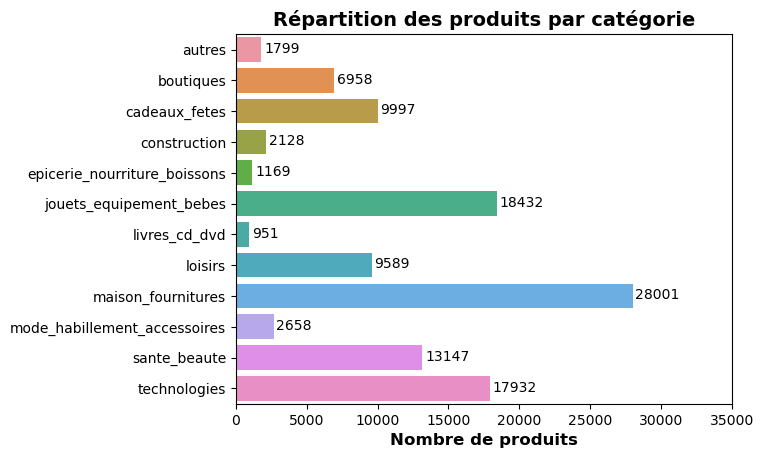

In [271]:
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=produit_par_categorie, x="Nombre de produits", y="Catégorie")
    plt.xlabel("Nombre de produits", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.xlim(0, 35000)
    plt.ylabel('')
    plt.title("Répartition des produits par catégorie", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

nb_produit = produit_par_categorie["Nombre de produits"]
for i, v in enumerate(nb_produit):
    plt.text(v+200, i+0.1, int(v), fontsize=10, fontname="sans-serif")

plt.show()      

**Les produits commandés font principalement parti de la catégorie maison_fournitures, suivi respectivement des catégories jouets_equipements bébés et technologies.**

### 6. Vérification de la catégorie des produits présentant des valeurs atypiques

**Il s'agit principalement des produits dont le prix est supérieur à 5000, les frais de port supérieurs à 350 ou le poids de 0 gramme.**

**CREATION D'UN DATRAFRAME SPECIFIQUE POUR CETTE ANALYSE**

In [272]:
produits_atypiques = jointure_categorie[(jointure_categorie["price"] > 5000) | (jointure_categorie["freight_value"] > 350) |
                                       (jointure_categorie["product_weight_g"] == 0)]

produits_atypiques

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit
3932,f5136e38d1a14a4dbd87dff67da82701,3fd6777bbce08a352fddd04e4a7cc8f6,delivered,2017-05-24 18:14:34,2017-06-05 17:09:48,2017-06-28,12,22,5.0,2.0,1,1.0,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17,6499.00,227.66,7400.0,47.0,25.0,25.0,29375.0,loisirs
5787,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.90,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
5788,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,2.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.90,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
14470,4abc7b5330425bcf9c2f7f48151a88c0,d1568f1104d2015dc70bdf7d9ab88dd2,delivered,2018-07-31 21:05:49,2018-08-07 23:56:48,2018-08-17,7,9,5.0,3.0,1,1.0,8038040ee2a71048d4bdbbdc985b69ab,b39d7fe263ef469605dbb32608aee0af,2018-08-09 21:31:33,129.90,14.49,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
25101,0812eb902a67711a1cb742b3cdaa65ae,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12 20:37:36,2017-03-03 14:23:18,2017-03-09,19,5,5.0,1.0,1,1.0,489ae2aa008f021502940f251d4cce7f,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36,6735.00,194.31,30000.0,60.0,61.0,33.0,120780.0,maison_fournitures
32093,fefacc66af859508bf1a7934eab1e97f,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,2018-08-15 14:57:50,2018-08-10,21,-6,NaN,NaN,0,1.0,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,5660.0,54.0,18.0,47.0,45684.0,technologies
44464,200b121c28e10ef638131a7c76753327,26bcca10e5c9679c306d8333bf527929,delivered,2018-08-04 15:55:59,2018-08-23 18:21:59,2018-08-30,19,6,5.0,4.0,1,1.0,81781c0fed9fe1ad6e8c81fca1e1cb08,b39d7fe263ef469605dbb32608aee0af,2018-08-14 16:10:16,100.00,19.89,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
57125,a77e1550db865202c56b19ddc6dc4d53,4eed76c1aafeceac4250e202ca9b1a5a,delivered,2018-04-16 14:57:21,2018-04-27 19:45:00,2018-05-17,11,19,5.0,3.0,1,1.0,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,2018-04-25 06:55:13,979.00,409.68,14675.0,55.0,64.0,52.0,183040.0,jouets_equipement_bebes
73921,476b812a7e4fc972646eb390517bddcb,18a1176652a9344ba489fa4ccaa3c20f,delivered,2018-08-18 11:09:12,2018-08-30 16:56:44,2018-09-12,12,12,5.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-22 11:30:42,129.90,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
84990,076d1555fb53a89b0ef4d529e527a0f6,f08306b95370e8d5f0d97b71229284b6,delivered,2018-07-30 10:04:21,2018-08-08 00:46:43,2018-08-14,9,6,4.0,6.0,1,1.0,a3cd9517ebf5a50dca25acce54f3b171,6fa9202c10491e472dffd59a3e82b2a3,2018-08-07 04:35:22,2338.08,375.28,30000.0,75.0,58.0,65.0,282750.0,maison_fournitures


**Lorsque nous regardons ce dataframe, nous sommes bien en présence de valeurs atypiques concernant les prix et les frais de port. Par contre, concernant les produits avec un poids de 0, il s'agit bien d'une anomalie au vu du volume du produit et les 3 produits concernés proviennent du même vendeur!!! Pour ces 3 produits, il serait donc intéréssant de modifier le poids en prenant en compte la catégorie du produit et le volume.**

**RECHERCHE DE PRODUITS SIMILAIRES POSSEDANT UN POIDS**

In [273]:
produits_sosies = jointure_categorie[(jointure_categorie["categorie_produit"] == "jouets_equipement_bebes") & (jointure_categorie["produit_volume_cm3"] == 22500.0)]
produits_sosies.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit
5787,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
5788,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,2.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
7995,c9c47f859e747812a921562c2f874229,6425d1369b270b096dfcbce176e3c59c,delivered,2018-05-14 17:04:59,2018-05-21 18:12:17,2018-06-01,7,10,4.0,1.0,1,2.0,4f130a13e2dd77a6f88f31e7addcec0c,4a3ca9315b744ce9f8e9374361493884,2018-05-18 17:30:12,59.9,13.89,500.0,50.0,10.0,45.0,22500.0,jouets_equipement_bebes
9369,2d0da8435c6493de84783c21578638aa,c5c571939091a3ed365ad5d8d89602d2,delivered,2017-08-07 08:56:15,2017-08-22 19:38:16,2017-08-29,15,6,5.0,2.0,1,1.0,4f130a13e2dd77a6f88f31e7addcec0c,4a3ca9315b744ce9f8e9374361493884,2017-08-11 09:10:18,59.9,16.18,500.0,50.0,10.0,45.0,22500.0,jouets_equipement_bebes
14470,4abc7b5330425bcf9c2f7f48151a88c0,d1568f1104d2015dc70bdf7d9ab88dd2,delivered,2018-07-31 21:05:49,2018-08-07 23:56:48,2018-08-17,7,9,5.0,3.0,1,1.0,8038040ee2a71048d4bdbbdc985b69ab,b39d7fe263ef469605dbb32608aee0af,2018-08-09 21:31:33,129.9,14.49,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes


Un produit de la même catégorie et de même volume présente un poids de 500 grammes. Par conséquent, pour ces 3 produits, une rectification à 500 grammes sera effectuée (la médiane englobant l'ensemble des produits étant de 700 grammes).

**MODIFICATION DU POIDS DES 3 PRODUITS**

**Création d'un dataframe pour la récupération des index**

In [274]:
produits_erreurs_poids = jointure_categorie[(jointure_categorie["product_weight_g"] == 0)]
produits_erreurs_poids

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit
5787,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
5788,06afc1144eb9f51ef2aa90ec9223c7f4,e8be078dee76002545a9c5f10b7d7c4e,delivered,2018-08-15 17:13:07,2018-08-24 22:54:42,2018-09-20,9,26,3.0,3.0,1,2.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-23 17:25:20,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
14470,4abc7b5330425bcf9c2f7f48151a88c0,d1568f1104d2015dc70bdf7d9ab88dd2,delivered,2018-07-31 21:05:49,2018-08-07 23:56:48,2018-08-17,7,9,5.0,3.0,1,1.0,8038040ee2a71048d4bdbbdc985b69ab,b39d7fe263ef469605dbb32608aee0af,2018-08-09 21:31:33,129.9,14.49,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
44464,200b121c28e10ef638131a7c76753327,26bcca10e5c9679c306d8333bf527929,delivered,2018-08-04 15:55:59,2018-08-23 18:21:59,2018-08-30,19,6,5.0,4.0,1,1.0,81781c0fed9fe1ad6e8c81fca1e1cb08,b39d7fe263ef469605dbb32608aee0af,2018-08-14 16:10:16,100.0,19.89,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
73921,476b812a7e4fc972646eb390517bddcb,18a1176652a9344ba489fa4ccaa3c20f,delivered,2018-08-18 11:09:12,2018-08-30 16:56:44,2018-09-12,12,12,5.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-22 11:30:42,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
103710,b489f7ae130ba3fd26b0a20f8cc81c61,99411e9599f8b7a90f2a362b874b66ca,delivered,2018-08-18 20:37:22,2018-08-27 14:52:02,2018-09-04,9,7,5.0,3.0,1,1.0,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,2018-08-22 20:49:57,129.9,23.71,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
111205,06d9e69034388abf6da64378e10737b8,afef0047e43944e8c6630ec0d0f7de2e,delivered,2018-07-30 10:42:40,2018-08-09 22:18:29,2018-09-10,10,31,3.0,3.0,1,1.0,36ba42dd187055e1fbe943b2d11430ca,b39d7fe263ef469605dbb32608aee0af,2018-08-10 09:10:11,100.0,23.85,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes
111206,06d9e69034388abf6da64378e10737b8,afef0047e43944e8c6630ec0d0f7de2e,delivered,2018-07-30 10:42:40,2018-08-09 22:18:29,2018-09-10,10,31,3.0,3.0,1,2.0,36ba42dd187055e1fbe943b2d11430ca,b39d7fe263ef469605dbb32608aee0af,2018-08-10 09:10:11,100.0,23.85,0.0,30.0,25.0,30.0,22500.0,jouets_equipement_bebes


**Récupération des index sous forme de liste et rectification de la valeur**

In [275]:
# Création de la liste des index
liste_produits_erreurs_poids = produits_erreurs_poids.index.tolist()

# Modification du poids
for idx in liste_produits_erreurs_poids:
    jointure_categorie.loc[idx, "product_weight_g"] = 500
    
# Vérification de la bonne attribution sur une commande
jointure_categorie.iloc[5788, -6]

500.0

**Description de la variable "product_weight_g"**

In [276]:
jointure_categorie["product_weight_g"].describe()

count    112761.000000
mean       2091.534768
std        3749.221304
min           2.000000
25%         300.000000
50%         700.000000
75%        1800.000000
max       40425.000000
Name: product_weight_g, dtype: float64

Nous n'avons plus de poids à 0, le minimum étant maintenant de 2 grammes (ce qui est vraiment atypique).

**A NOTER: Avant d'analyser la table des paiements, la jointure avec la table des vendeurs sera réalisée.**

### 7. Jointure avec la table des vendeurs

**Cette jointure sera réalisée grâce à la clé étrangère 'seller_id'**

In [277]:
jointure_vendeurs = pd.merge(jointure_categorie, jointure_1, on="seller_id", how = "left")
jointure_vendeurs.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13,13,5.0,3.0,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,6000.0,boutiques,31842,belo horizonte,MG,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,11475.0,maison_fournitures,8752,mogi das cruzes,SP,-23.543395,-46.262086


**Informations sur le nouveau jeu de données**

In [278]:
jointure_vendeurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112761 entries, 0 to 112760
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112761 non-null  object        
 1   customer_id                    112761 non-null  object        
 2   order_status                   112761 non-null  object        
 3   order_purchase_timestamp       112761 non-null  datetime64[ns]
 4   order_delivered_customer_date  112761 non-null  datetime64[ns]
 5   order_estimated_delivery_date  112761 non-null  datetime64[ns]
 6   delai_livraison                112761 non-null  int64         
 7   ecart_livraison                112761 non-null  int64         
 8   review_score                   111836 non-null  float64       
 9   delai_reponse                  111836 non-null  float64       
 10  avis_donne                     112761 non-null  int32         
 11  

L'analyse de la localisation des vendeurs ayant déjà été réalisée, aucune autre analyse n'est prévue sur ces derniers qui ne sont pas le sujet de notre mission.

## 1.9. La table de paiement 'olist_order_payments_dataset'

### 1. Informations générales sur le jeu de données

In [279]:
# Ouverture du fichier
df_9 = pd.read_csv("olist_order_payments_dataset.csv", sep=',')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_9.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [280]:
# Copie du fichier
payments = df_9.copy()

In [281]:
# Dimension du jeu de données
print(f'Cette 9ème table comprend {payments.shape[0]} lignes et {payments.shape[1]} variables.')

Cette 9ème table comprend 103886 lignes et 5 variables.


In [282]:
# Infos sur le jeu de données
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Cette table ne présente aucune donnée manquante.

**EXPLICATION DE CETTE TABLE**
- **'payment_sequential'** : Nombre de différents types de paiements pour une commande (1 ligne par type)
- **'payment_type'**: Mode de paiement
- **'payment_installments'**: Indique en combien de fois le paiement est réalisé.
- **'payment_value'**: Montant du paiement.

**ATTENTION**: Des commandes ayant été supprimées, il est indispensable de réaliser la jointure avant toute analyse.
    
**ANALYSE DU CONTENU DES DIFFERENTES VARIABLES**

### 2. Jointure avec notre dataframe précédent

**Cette jointure sera réalisée grâce à la clé étrangère 'order_id'.**

**REALISATION DE LA JOINTURE**

In [283]:
jointure_paiement= pd.merge(jointure_vendeurs, payments, on="order_id", how='left')
jointure_paiement.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12


**INFORMATIONS SUR LE NOUVEAU JEU DE DONNEES**

In [284]:
jointure_paiement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117733 entries, 0 to 117732
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117733 non-null  object        
 1   customer_id                    117733 non-null  object        
 2   order_status                   117733 non-null  object        
 3   order_purchase_timestamp       117733 non-null  datetime64[ns]
 4   order_delivered_customer_date  117733 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117733 non-null  datetime64[ns]
 6   delai_livraison                117733 non-null  int64         
 7   ecart_livraison                117733 non-null  int64         
 8   review_score                   116772 non-null  float64       
 9   delai_reponse                  116772 non-null  float64       
 10  avis_donne                     117733 non-null  int32         
 11  

### 2. Analyse du contenu des différentes variables

**NOMBRE DE PRODUITS REFERENCES**

In [285]:
order_payments = jointure_paiement["order_id"].unique().tolist()
len(order_payments)

98199

Ce chiffre est bien le chiffre attendu.

**VARIABLE 'payment_sequential'**

In [286]:
# Liste des différents modes de paiement utilisés pour une commande
sequential_payments = jointure_paiement["payment_sequential"].unique().tolist()
print(sequential_payments)

[1.0, 3.0, 2.0, 4.0, 8.0, 5.0, 7.0, 9.0, 6.0, 14.0, 17.0, 22.0, 11.0, 16.0, 13.0, 18.0, 12.0, 19.0, 21.0, 20.0, 10.0, 15.0, 27.0, 25.0, 29.0, 28.0, 26.0, 23.0, 24.0, nan]


29 modes de paiements peuvent être utilisés pour une même commande!!! De plus, nous sommes en présence de nan. Il est donc nécessaire d'analyse les commandes concernées.

In [287]:
sequential_payments_absent = jointure_paiement[(jointure_paiement["payment_sequential"].isna())]
sequential_payments_absent

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
36434,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,NaN,NaN,NaN,NaN
36435,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,NaN,NaN,NaN,NaN
36436,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,NaN,NaN,NaN,NaN


Il s'agit d'une commande délivrée possédant 3 articles identiques dont nous ne disposons d'aucun renseignement sur le paiement. L'imputation des valeurs manquantes pour ces 4 variables se fera progressivement:
- **Variable 'payment_sequentiel' et 'payment_installments'**: Imputation par les valeurs les plus fréquentes.
- **Variable 'payment_value'**: Disposant du prix et des frais de port, une simple addition permettra de remplir la valeur manquante.
- **Variable 'payment_type'**: Imputation en fonction du contenu de la variable. 

**Description de la variable 'payment_sequential'**

In [288]:
jointure_paiement["payment_sequential"].describe()

count    117730.000000
mean          1.094080
std           0.729093
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          29.000000
Name: payment_sequential, dtype: float64

Au vu de ces données, l'imputation sera réalisée par la valeur 1.

**Imputation pour les données manquantes**

In [289]:
# Création de la liste des index
liste_sequential_payments_absent = sequential_payments_absent.index.tolist()

# Imputation
for idx in liste_sequential_payments_absent:
    jointure_paiement.loc[idx, "payment_sequential"] = 1
    
# Vérification sur les 3 lignes
jointure_paiement.iloc[36436, -4]

1.0

L'imputation s'est bien réalisée.

**Visualisation par boxplot de la distribution du nombre de paiements différents par commande**

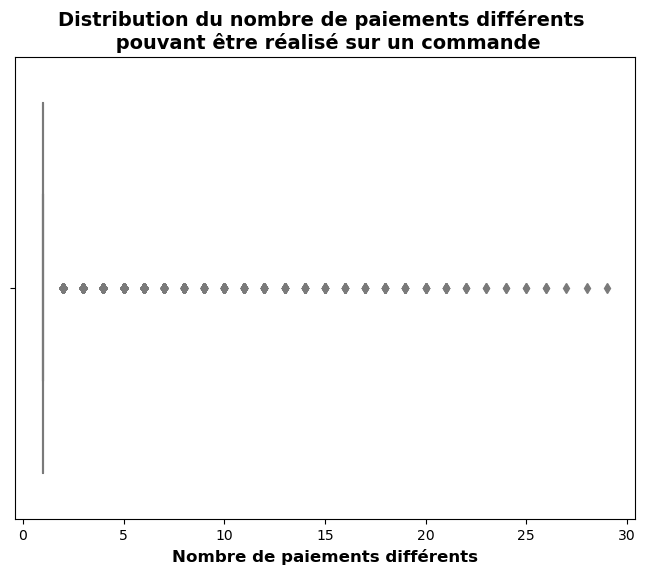

In [290]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=jointure_paiement, x="payment_sequential")
    plt.xlabel('Nombre de paiements différents', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('')
    plt.title("Distribution du nombre de paiements différents \n pouvant être réalisé sur un commande", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

**VARIABLE 'payment_type'**

In [291]:
# Liste des modes de paiement utilisés pour une commande
type_payments = jointure_paiement["payment_type"].unique().tolist()
print(type_payments)

['credit_card', 'voucher', 'boleto', 'debit_card', nan]


Concernant le boleto et le voucher, il s'agit respectivement d'espèce et de bons.

**Description de la variable 'payment-type'**

In [292]:
jointure_paiement["payment_type"].describe()

count          117730
unique              4
top       credit_card
freq            86812
Name: payment_type, dtype: object

Le moyen de paiement le plus utilisé est la carte bancaire. Les données manquantes seront donc remplacées par credit_card. 

**Imputation pour les données manquantes**

In [293]:
# Imputation via les index de la liste liste_sequential_payments_absent précédemment créée
for idx in liste_sequential_payments_absent:
    jointure_paiement.loc[idx, "payment_type"] = "credit_card"
    
# Vérification sur une ligne
jointure_paiement.iloc[36436, -3]

'credit_card'

L'imputation s'est correctement réalisée.

**Visualisation par histogramme de la distribution du mode de paiement**

Sachant qu'une commande peut-être payée avec plusieurs types de paiement, l'analyse ne sera pas faite sur le nombre réel de commandes mais sur l'ensemble des produits.

In [294]:
# Création du dataframe
moyen_paiement = jointure_paiement.groupby("payment_type")["order_id"].count().reset_index()

# Renommage des colonnes
moyen_paiement.columns = ["Type de paiement", "Nombre"]
moyen_paiement

,Type de paiement,Nombre
0,boleto,22922
1,credit_card,86815
2,debit_card,1693
3,voucher,6303


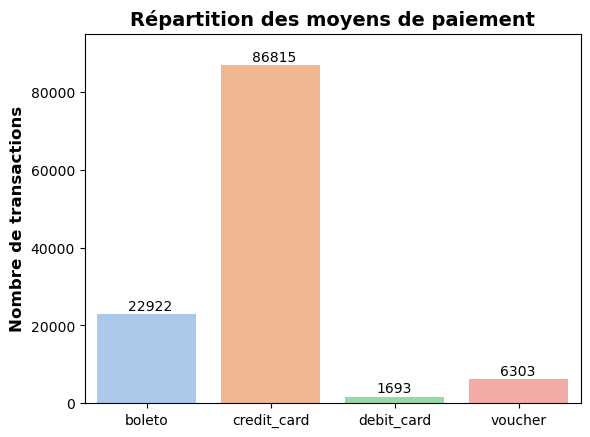

In [295]:
# Visualisation par histogramme

plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=moyen_paiement, x="Type de paiement", y="Nombre")
    plt.xlabel("")
    plt.ylim(0, 95000)
    plt.ylabel("Nombre de transactions", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition des moyens de paiement", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

nb_type_paiment = moyen_paiement["Nombre"]
for i, v in enumerate(nb_type_paiment):
    plt.text(i-0.15, v+1000, int(v), fontsize=10, fontname="sans-serif")

plt.show()      

**VARIABLE 'payment_installments'**

In [296]:
# Liste de l'étalement des paiements
payment_installments = jointure_paiement["payment_installments"].unique().tolist()
print(payment_installments)

[1.0, 3.0, 6.0, 10.0, 4.0, 2.0, 8.0, 9.0, 7.0, 5.0, 13.0, 12.0, 15.0, 14.0, 21.0, 18.0, 24.0, 17.0, 11.0, 20.0, 23.0, 16.0, nan, 22.0, 0.0]


Le paiement d'une commande peut s'effectuer en 24 fois!!! De plus, un paiement peut avoir eu lieu en 0 fois ce qui est impossible et nous sommes également en présence de valeurs manquantes. Une modification sera donc réalisée sur les lignes impactées après la description de cette variable.

In [297]:
# Recherche des 'order_id anormaux'
payment_installments_nul = jointure_paiement[jointure_paiement["payment_installments"]==0]
payment_installments_nul

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
75312,744bade1fcf9ff3f31d860ace076d422,5e5794daaa13f73e2f1cdb4114529843,delivered,2018-04-22 11:34:42,2018-04-27 20:55:28,2018-05-16,5,18,5.0,2.0,1,1.0,0cf573090c66bb30ac5e53c82bdb0403,7202e2ba20579a9bd1acb29e61fe71f6,2018-04-26 12:31:06,45.90,12.79,128.0,15.0,8.0,13.0,1560.0,technologies,14401,franca,SP,-20.528619,-47.387410,2.0,credit_card,0.0,58.69
78424,1a57108394169c0b47d8f876acc9ba2d,48ebb06cf56dba9d009230cc751bb195,delivered,2018-05-15 16:25:14,2018-05-24 15:45:41,2018-06-06,9,12,5.0,1.0,1,1.0,db35a562fb6ba63e19fa42a15349dc04,282f23a9769b2690c5dda22e316f9941,2018-05-18 16:31:54,41.69,23.28,500.0,23.0,11.0,23.0,5819.0,maison_fournitures,31573,belo horizonte,MG,-19.810952,-43.989987,2.0,credit_card,0.0,129.94
78425,1a57108394169c0b47d8f876acc9ba2d,48ebb06cf56dba9d009230cc751bb195,delivered,2018-05-15 16:25:14,2018-05-24 15:45:41,2018-06-06,9,12,5.0,1.0,1,2.0,db35a562fb6ba63e19fa42a15349dc04,282f23a9769b2690c5dda22e316f9941,2018-05-18 16:31:54,41.69,23.28,500.0,23.0,11.0,23.0,5819.0,maison_fournitures,31573,belo horizonte,MG,-19.810952,-43.989987,2.0,credit_card,0.0,129.94


**Description de la variable 'payment_installments'**

In [298]:
payments["payment_installments"].describe()

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

L'imputation des valeurs manquantes ou nulles sera réalisée par la médiane donc 1.

In [299]:
# Liste des index contenant les lignes à imputer
liste_payment_installments = [36434, 36435, 36436, 75312, 78424, 78425]

# Imputation
for idx in liste_payment_installments:
    jointure_paiement.loc[idx, "payment_installments"] = 1

# Vérification sur une ligne
jointure_paiement.iloc[36436, -2]

1.0

**VARIABLE 'payment_value'**

L'imputation s'est correctement réalisée.

**Description de la variable**

In [300]:
jointure_paiement["payment_value"].describe()

count    117730.000000
mean        172.121748
std         265.601854
min           0.000000
25%          60.850000
50%         108.190000
75%         189.070000
max       13664.080000
Name: payment_value, dtype: float64

Tout d'abord, la valeur maximale me semble atypique voire aberrante. Cette commande sera donc vérifiée. Il en sera de même pour les montants de 0. Quelques modifications préalables seront réalisées.

**Vérification préalable que les frais de port ne dépassent pas le montant total de la commande**

In [301]:
# Création du dataframe
chose_impossible = jointure_paiement[jointure_paiement["freight_value"]>=jointure_paiement["payment_value"]]
chose_impossible.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00
12,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-08-16 17:14:30,2017-08-23,18,6,5.0,1.0,1,1.0,9a78fb9862b10749a117f7fc3c31f051,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,9750.0,42.0,41.0,42.0,72324.0,maison_fournitures,8577,itaquaquecetuba,SP,-23.486111,-46.366721,1.0,credit_card,1.0,8.34
25,83018ec114eee8641c97e08f7b4e926f,7f8c8b9c2ae27bf3300f670c3d478be8,delivered,2017-10-26 15:54:26,2017-11-08 22:22:00,2017-11-23,13,14,4.0,1.0,1,1.0,c35498fbb4358837ae16850f50c3fd22,70a12e78e608ac31179aea7f8422044b,2017-11-01 16:07:35,76.00,16.97,325.0,19.0,8.0,22.0,3344.0,technologies,12327,jacarei,SP,-23.302318,-45.971888,1.0,credit_card,1.0,5.96
97,634e8f4c0f6744a626f77f39770ac6aa,05e996469a2bf9559c7122b87e156724,delivered,2017-08-09 18:32:47,2017-08-16 18:17:54,2017-08-31,7,14,1.0,1.0,1,1.0,69d980b4120a76616d7b237d731d6156,744dac408745240a2c2528fb1b6028f3,2017-08-15 18:45:18,219.00,15.28,600.0,16.0,11.0,12.0,2112.0,cadeaux_fetes,83408,colombo,PR,-25.367475,-49.184199,1.0,credit_card,1.0,7.08
120,f7959f8385f34c4f645327465a1c9fc4,0bf19317b1830a69e55b40710576aa7a,delivered,2017-03-30 07:50:33,2017-04-10 02:59:52,2017-04-26,11,16,5.0,1.0,1,1.0,c1234c80dafde7ef3311b3eabd5069ed,dc4a0fc896dc34b0d5bfec8438291c80,2017-04-11 08:05:08,17.90,10.96,300.0,20.0,2.0,15.0,600.0,jouets_equipement_bebes,14940,ibitinga,SP,-21.757321,-48.829744,1.0,credit_card,1.0,6.83


In [302]:
# Nombre de lignes concernées
print(f'Cette anomalie est présente sur {chose_impossible.shape[0]} lignes!!!')

Cette anomalie est présente sur 2571 lignes!!!


In [303]:
# Les 5 dernières lignes
chose_impossible.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
117262,6bc3c200db7e637a78b05d8984dcf66f,49c01eb0774fa3c20b2b4aa1b1682b4b,delivered,2017-02-03 11:05:24,2017-02-13 11:38:52,2017-03-22,10,37,5.0,7.0,1,1.0,7cb189885a8c492d7fe0ebad09449b3c,4aba391bc3b88717ce08eb11e44937b2,2017-02-07 11:05:24,119.00,21.28,600.0,28.0,25.0,25.0,17500.0,loisirs,45816,arraial d'ajuda (porto seguro),BA,-16.400187,-39.262747,1.0,credit_card,1.0,13.99
117346,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-07-03 13:25:15,2018-07-24,10,20,1.0,0.0,1,1.0,70120d2f9b9193aa0030342072d8adec,92eb0f42c21942b6552362b9b114707d,2018-06-28 13:40:11,34.97,22.97,263.0,19.0,10.0,15.0,2850.0,technologies,3504,sao paulo,SP,-23.537555,-46.538228,1.0,credit_card,1.0,9.31
117452,74d882fe8bdccca5952fbe23321ecfa7,784ea06d707eeb460893a573fa879dc2,delivered,2018-05-20 01:24:02,2018-06-11 13:34:28,2018-06-07,23,-5,1.0,1.0,1,1.0,9e9a222ec8c28d9ab56658263c17f16c,f12ff17ad8bbf01ec5c33b17e506649b,2018-05-23 08:17:29,136.00,23.53,1150.0,20.0,20.0,20.0,8000.0,boutiques,3186,sao paulo,SP,-23.565562,-46.581639,2.0,voucher,1.0,13.21
117622,4bafa54db6b060da198f23f810835969,48094f58f03bec9519bd0e004ce460df,delivered,2018-04-05 14:46:51,2018-04-30 21:41:07,2018-05-14,25,13,5.0,1.0,1,1.0,5ac4f7986643a944501c66a2257bdd73,3df020b72d3d44b3af9d110fa3940b65,2018-04-11 15:09:52,49.90,35.71,600.0,17.0,17.0,17.0,4913.0,maison_fournitures,15704,jales,SP,-20.280018,-50.551435,1.0,credit_card,2.0,28.16
117624,4bafa54db6b060da198f23f810835969,48094f58f03bec9519bd0e004ce460df,delivered,2018-04-05 14:46:51,2018-04-30 21:41:07,2018-05-14,25,13,5.0,1.0,1,1.0,5ac4f7986643a944501c66a2257bdd73,3df020b72d3d44b3af9d110fa3940b65,2018-04-11 15:09:52,49.90,35.71,600.0,17.0,17.0,17.0,4913.0,maison_fournitures,15704,jales,SP,-20.280018,-50.551435,3.0,voucher,1.0,8.13


In [304]:
# La prise de 10 lignes au hasard
chose_impossible.sample(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
8221,8ce09fabe89667119f813bcaa531e675,86a86095c835b9ad8633982e96fd84bf,delivered,2018-08-04 17:54:31,2018-08-16 19:34:23,2018-08-09,12,-8,1.0,1.0,1,1.0,7052c556fc966a2321d570f3c5a8790f,99a54764c341d5dc80b4a8fac4eba3fb,2018-08-07 18:15:12,7.50,7.39,9800.0,25.0,10.0,20.0,5000.0,maison_fournitures,3273,sao paulo,SP,-23.577347,-46.559955,1.0,credit_card,1.0,1.97
16398,eb92f6fdb8dcd9a9ab21c341b4a3ca5f,78a0a4fe355394a8f2ab9efd5fa38206,delivered,2018-02-09 02:14:32,2018-02-22 14:37:50,2018-02-23,14,0,4.0,2.0,1,1.0,e791e580a2421e4471aebb0629c705c1,9f505651f4a6abe901a56cdc21508025,2018-02-15 02:10:23,13.99,7.78,200.0,16.0,4.0,14.0,896.0,technologies,4102,sao paulo,SP,-23.589847,-46.632614,1.0,credit_card,1.0,1.77
80087,aa4634ff761133d98df37cc039021823,7a0a62073458a64b47eefca7f10df997,delivered,2017-11-21 23:18:44,2017-11-27 19:47:41,2017-12-01,6,3,5.0,1.0,1,1.0,8418c7eadd4164f7b60fa91f6a5c3461,76d5af76d0271110f9af36c92573f765,2017-11-28 23:26:17,13.60,8.72,700.0,16.0,16.0,16.0,4096.0,boutiques,3194,sao paulo,SP,-23.567890,-46.573948,1.0,voucher,1.0,0.78
93253,6d58638e32674bebee793a47ac4cbadc,2ba91e12e5e4c9f56b82b86d9031d329,delivered,2017-11-25 13:54:39,2017-11-30 14:59:18,2017-12-11,5,10,1.0,2.0,1,1.0,eea3e07f864a0a1389726d8a5f31c3f6,3c7c4a49ec3c6550809089c6a2ca9370,2017-11-30 14:16:34,99.90,7.95,125.0,16.0,11.0,14.0,2464.0,sante_beaute,3804,sao paulo,SP,-23.499143,-46.483299,3.0,voucher,1.0,2.87
89550,2cbcb371aee438c59b722a21d83597e0,559885225f11e9c1af7436a3fa2b58f2,delivered,2018-06-26 22:33:55,2018-07-03 06:57:53,2018-07-17,6,14,5.0,1.0,1,1.0,1a758361b1c10b3ffe3d3373332de319,8d956fec2e4337affcb520f56fd8cbfd,2018-07-02 00:30:51,46.99,12.99,175.0,17.0,10.0,13.0,2210.0,loisirs,9780,sao bernardo do campo,SP,-23.715050,-46.537268,2.0,voucher,1.0,7.80
114773,8bcbe01d44d147f901cd3192671144db,f2def7f64f36952f2f5a9791f0285f34,delivered,2018-01-24 23:24:14,2018-02-02 21:26:42,2018-02-21,9,18,4.0,9.0,1,1.0,85d4c1a46f08f730de651ea6f6645313,3d871de0142ce09b7081e2b9d1733cb1,2018-01-30 23:37:20,59.00,15.16,500.0,20.0,30.0,20.0,12000.0,maison_fournitures,13232,campo limpo paulista,SP,-23.211746,-46.762875,4.0,voucher,1.0,0.00
49119,d41f1036712e18ee525939d08b7a1c98,099197f5b3af6c03f208f70f62df794e,delivered,2018-01-06 11:37:12,2018-01-11 18:10:44,2018-01-26,5,14,5.0,1.0,1,1.0,d2c277a6bd8e9119fa1a84c70f3eab5d,e62b2d6ac10570a035a30bafcf01d263,2018-01-12 11:47:34,79.90,9.37,2750.0,60.0,15.0,30.0,27000.0,maison_fournitures,5767,sao paulo,SP,-23.632114,-46.760770,1.0,credit_card,1.0,3.57
110107,9b692faed4adf2e5efb7c98de308aad0,0941cc6c82ccb3ad29471a38e6a8dc04,delivered,2018-04-10 15:53:39,2018-04-14 15:52:12,2018-04-30,4,15,3.0,3.0,1,1.0,7945bb528c42095fccdf46321742afce,0adac9fbd9a2b63cccaac4f8756c1ca8,2018-04-16 16:11:27,44.90,13.71,775.0,44.0,3.0,34.0,4488.0,maison_fournitures,13290,louveira,SP,-23.085505,-46.959541,1.0,credit_card,1.0,7.90
9059,285c2e15bebd4ac83635ccc563dc71f4,b246eeed30b362c09d867b9e598bee51,delivered,2017-12-08 12:00:04,2017-12-21 16:33:10,2018-01-03,13,12,5.0,1.0,1,1.0,bdc3291ab242ec1effc8eb0987850268,dbd66278cbfe1aa1000f90a217ca4695,2017-12-14 11:55:17,29.00,11.85,541.0,19.0,12.0,16.0,3648.0,technologies,5588,sao paulo,SP,-23.576017,-46.741186,16.0,voucher,1.0,1.96
86899,d0bff47153ef056bb4f884a2ec2f0691,5bbd3f38fe696e4bc73a9f914a6716e6,delivered,2017-11-23 15:05:54,2017-12-05 00:37:37,2017-12-20,11,15,5.0,1.0,1,1.0,553e0e7590d3116a072507a3635d2877,1c129092bf23f28a5930387c980c0dfc,2017-11-29 15:30:04,39.50,15.11,800.0,20.0,20.0,20.0,8000.

Lorsque nous regardons ces lignes prises au hasard, il semble que par moment les frais de port semblent être très importants par rapport au montant de la commande. De plus, nous ne sommes pas en mesure de savoir s'il s'agit de promotion, car le montant total et les prix/fraits de port proviennent de 2 datasets différents... Au regard de ce constat, une vérification de la correspondance entre le montant total et la somme des prix et frais de port sera réalisée.

**Recherche d'anomalies entre la somme prix/frais de port du produit et montant de la commande**

In [305]:
incoherence_montant = jointure_paiement[((jointure_paiement["price"]+jointure_paiement["freight_value"]) != jointure_paiement["payment_value"])]
incoherence_montant.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59
6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,9,5.0,2.0,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,11475.0,maison_fournitures,8752,mogi das cruzes,SP,-23.543395,-46.262086,1.0,credit_card,1.0,28.62
11,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-08-16 17:14:30,2017-08-23,18,6,5.0,1.0,1,1.0,9a78fb9862b10749a117f7fc3c31f051,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,9750.0,42.0,41.0,42.0,72324.0,maison_fournitures,8577,itaquaquecetuba,SP,-23.486111,-46.366721,2.0,voucher,1.0,161.42


In [306]:
# Nombre de lignes concernées
print(f'Cette anomalie concerne {incoherence_montant.shape[0]} lignes.')

Cette anomalie concerne 48051 lignes.


In [307]:
incoherence_montant.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
117723,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-20 20:25:45,2017-11-07,16,17,5.0,3.0,1,2.0,49d2e2460386273b195e7e59b43587c3,1caf283236cd69af44cbc09a0a1e7d32,2017-10-10 20:07:14,26.90,36.98,750.0,26.0,15.0,26.0,10140.0,jouets_equipement_bebes,26020,nova iguacu,RJ,-22.733078,-43.449614,2.0,voucher,1.0,64.37
117724,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-02-07 13:15:25,2017-03-17,12,37,5.0,4.0,1,1.0,9fc063fd34fed29ccc57b7f8e8d03388,ccc4bbb5f32a6ab2b7066a4130f114e3,2017-02-03 00:30:03,370.00,19.43,750.0,38.0,12.0,25.0,11400.0,sante_beaute,80310,curitiba,PR,-25.456934,-49.309455,2.0,voucher,1.0,250.00
117725,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-02-07 13:15:25,2017-03-17,12,37,5.0,4.0,1,1.0,9fc063fd34fed29ccc57b7f8e8d03388,ccc4bbb5f32a6ab2b7066a4130f114e3,2017-02-03 00:30:03,370.00,19.43,750.0,38.0,12.0,25.0,11400.0,sante_beaute,80310,curitiba,PR,-25.456934,-49.309455,1.0,credit_card,5.0,139.43
117730,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,17,20,2.0,1.0,1,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,6550.0,20.0,20.0,20.0,8000.0,technologies,37175,ilicinea,MG,-20.940578,-45.827237,1.0,credit_card,4.0,441.16
117731,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,17,20,2.0,1.0,1,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,6550.0,20.0,20.0,20.0,8000.0,technologies,37175,ilicinea,MG,-20.940578,-45.827237,1.0,credit_card,4.0,441.16


Cette incohérence concerne 40% du dataframe. Même si dans certains cas, nous pourrions nous dire qu'il s'agit de promotions, celles-ci semblent vraiment importantes... De plus,  les frais de port peuvent être supérieurs aux produits. Enfin, certains produits sont facturés plus que la réalité. Par conséquent, il y a une totale incohérence entre les 2 tables entraînant un choix à faire entre:
- la modification du montant total facturé
- la non prise en compte des prix et frais de port présents dans la table des vendeurs

Aucun solution n'étant parfaite, de mon point de vue, il me semble judicieux de ne pas prendre en compte la table des 'order_item' et de faire confiance aux services financiers d'Olist (exception faite pour les 9 lignes d'un montant nul...).

**Recherche de la commande possédant un montant suspect**

In [308]:
commande_suspecte = jointure_paiement[jointure_paiement["payment_value"] == 13664.08]
commande_suspecte

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
15739,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,1.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15740,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,2.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15741,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,3.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15742,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,4.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15743,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,5.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15744,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,6.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15745,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,7.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08
15746,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-17 18:22:29,2017-10-23,18,5,1.0,2.0,1,8.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,750.0,16.0,16.0,16.0,4096.0,technologies,3667,sao paulo,SP,-23.531307,-46.494795,1.0,credit_card,1.0,13664.08


Concernant cette commande, bien que je me suis fixée de me fier au montant facturé, le montant de la commande est 8 fois plus importants, conduisant à un outlier... Par conséquent, je trouve plus pertinent d'éliminer cette commande.

In [309]:
# Récupération de l'index des lignes concernées
liste_commandes_suspecte = commande_suspecte.index.tolist()

# Elimination de la commande
jointure_paiement = jointure_paiement[~jointure_paiement.index.isin(liste_commandes_suspecte)]

In [310]:
# Description du jeu de données
jointure_paiement["payment_value"].describe()

count    117722.000000
mean        171.204879
std         241.200815
min           0.000000
25%          60.850000
50%         108.180000
75%         189.060000
max        7274.880000
Name: payment_value, dtype: float64

**Recherche des commandes dont le montant est égal à 0**

In [311]:
commande_nulle = jointure_paiement[(jointure_paiement["payment_value"] == 0) | (jointure_paiement["payment_value"].isna())]
commande_nulle

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value
502,45ed6e85398a87c253db47c2d9f48216,8eab8f9b3c744b76b65f7a2c0c8f2d6c,delivered,2017-06-08 21:18:45,2017-06-22 17:44:53,2017-07-10,14,17,1.0,5.0,1,1.0,75d6b6963340c6063f7f4cfcccfe6a30,cc419e0650a3c5ba77189a1882b7556a,2017-06-15 21:30:18,56.99,14.15,400.0,18.0,11.0,20.0,3960.0,sante_beaute,9015,santo andre,SP,-23.659364,-46.523183,3.0,voucher,1.0,0.0
30692,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,shipped,2017-04-20 12:45:34,2017-04-30 12:45:34,2017-05-18,10,17,1.0,4.0,1,1.0,1aecdb5fa3add74e385f25c6c527a462,06532f10282704ef4c69168b914b77be,2017-04-27 09:10:13,392.55,65.44,16400.0,100.0,30.0,30.0,90000.0,maison_fournitures,87140,paincandu,PR,-23.456821,-52.039905,14.0,voucher,1.0,0.0
30701,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,shipped,2017-04-20 12:45:34,2017-04-30 12:45:34,2017-05-18,10,17,1.0,4.0,1,1.0,1aecdb5fa3add74e385f25c6c527a462,06532f10282704ef4c69168b914b77be,2017-04-27 09:10:13,392.55,65.44,16400.0,100.0,30.0,30.0,90000.0,maison_fournitures,87140,paincandu,PR,-23.456821,-52.039905,13.0,voucher,1.0,0.0
36434,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN
36435,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN
36436,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN
38299,6ccb433e00daae1283ccc956189c82ae,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-11-08 18:47:00,2017-11-22,13,13,4.0,98.0,1,1.0,2ee4be9805f228255a38a6f9b03fff1a,da20530872245d6cd9d2f5725613c430,2017-11-03 00:46:58,94.00,28.04,3300.0,22.0,22.0,22.0,10648.0,loisirs,95650,igrejinha,RS,-29.571978,-50.794730,4.0,voucher,1.0,0.0
101406,b23878b3e8eb4d25a158f57d96331b18,648121b599d98c420ef93f6135f8c80c,delivered,2017-05-27 19:20:24,2017-06-07 08:53:10,2017-06-29,11,22,5.0,3.0,1,1.0,e306ca54c91b21392317d5b4632c9fe3,e49c26c3edfa46d227d5121a6b6e4d37,2017-06-01 19:35:17,135.30,36.27,700.0,26.0,12.0,18.0,5616.0,technologies,55325,brejao,PE,-9.024839,-36.570200,4.0,voucher,1.0,0.0
114773,8bcbe01d44d147f901cd3192671144db,f2def7f64f36952f2f5a9791f0285f34,delivered,2018-01-24 23:24:14,2018-02-02 21:26:42,2018-02-21,9,18,4.0,9.0,1,1.0,85d4c1a46f08f730de651ea6f6645313,3d871de0142ce09b7081e2b9d1733cb1,2018-01-30 23:37:20,59.00,15.16,500.0,20.0,30.0,20.0,12000.0,maison_fournitures,13232,campo limpo paulista,SP,-23.211746,-46.762875,4.0,voucher,1.0,0.0


Comme précédemment stipulé, disposant des prix et des frais de port, nous imputerons les montants pour ces 9 lignes en tenant compte de ces données même si ces derniers semblent peu fiables.

**Imputation des valeurs manquantes**

In [312]:
# Imputation
jointure_paiement.iloc[502, -1] = 71.14
jointure_paiement.iloc[30692, -1] = 457.99
jointure_paiement.iloc[30701, -1] = 457.99
jointure_paiement.iloc[36434, -1] = 47.82
jointure_paiement.iloc[36435, -1] = 47.82
jointure_paiement.iloc[36436, -1] = 47.82
jointure_paiement.iloc[38299, -1] = 122.04
jointure_paiement.iloc[101406, -1] = 171.57
jointure_paiement.iloc[114773, -1] = 74.16

# Vérification sur une ligne
jointure_paiement.iloc[36434, -1]

47.82

**Visualisation de la répartition du montant des commandes par histogramme**

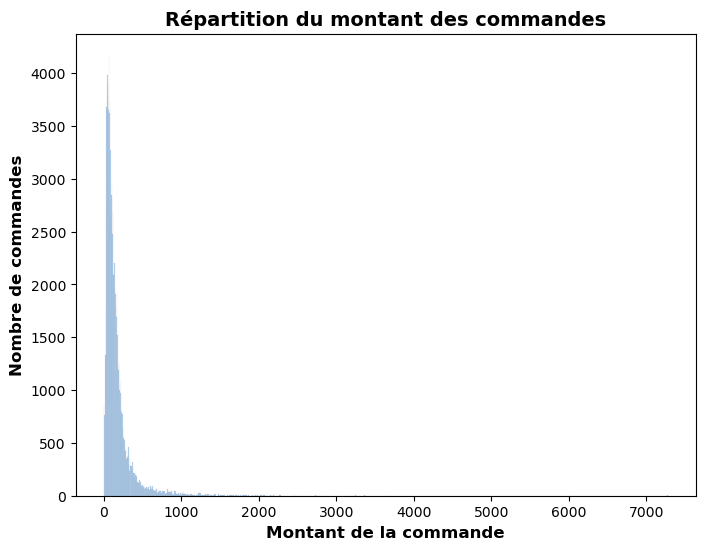

In [313]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=jointure_paiement, x="payment_value")
    plt.xlabel('Montant de la commande', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel('Nombre de commandes', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition du montant des commandes", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

**Visualisation de la répartition du montant des commandes par boxplot**

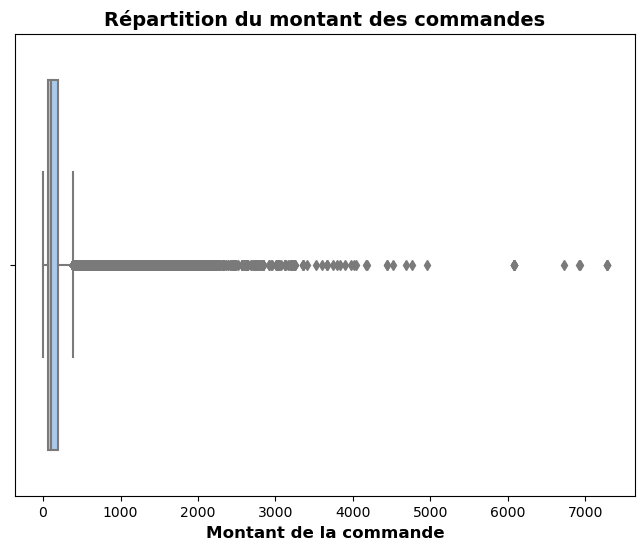

In [314]:
plt.figure(figsize=(8, 6))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=jointure_paiement, x="payment_value")
    plt.xlabel('Montant de la commande', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel("")
    plt.title("Répartition du montant des commandes", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    
plt.show()

### 3. Création de 3 nouvelles variables pour la réalisation du dataset clients

**CREATION DU DATAFRAME POUR LES 2 PREMIERES VARIABLES**

In [315]:
nouvelles_variables = payments.groupby(by="order_id").agg({"payment_sequential": 'count', "payment_installments": 'sum'}).reset_index()
nouvelles_variables.columns = ["order_id", "nb_paiements_differents", "nb_echeances"]
nouvelles_variables.head()

,order_id,nb_paiements_differents,nb_echeances
0,00010242fe8c5a6d1ba2dd792cb16214,1,2
1,00018f77f2f0320c557190d7a144bdd3,1,3
2,000229ec398224ef6ca0657da4fc703e,1,5
3,00024acbcdf0a6daa1e931b038114c75,1,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,3


In [316]:
# Vérification de l'absence de donnée manquante
nouvelles_variables_nan = nouvelles_variables[(nouvelles_variables["nb_paiements_differents"].isna()) | (nouvelles_variables["nb_echeances"].isna())]
nouvelles_variables_nan

,order_id,nb_paiements_differents,nb_echeances


**JOINTURE AVEC LE DATAFRAME "jointure_paiement"**

In [317]:
jointure_paiement = pd.merge(jointure_paiement, nouvelles_variables, on="order_id", how = 'left')
jointure_paiement.head()                             

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0


**INFORMATIONS SUR LE JEU DE DONNEES A CE STADE**

In [318]:
jointure_paiement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   116764 non-null  float64       
 9   delai_reponse                  116764 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

**Nous sommes en présence de 3 valeurs manquantes concernant les variables 'payment_value', 'nb_paiements_differents' et 'nb_echeances', ce qui est surprenant.**

In [319]:
jointure_paiement_na = jointure_paiement[(jointure_paiement["nb_paiements_differents"].isna()) | (jointure_paiement["nb_echeances"].isna())]
jointure_paiement_na

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances
36426,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN,NaN,NaN
36427,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN,NaN,NaN
36428,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,55,-36,1.0,2.0,1,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,1000.0,16.0,16.0,16.0,4096.0,sante_beaute,81810,curitiba,PR,-25.507014,-49.275963,1.0,credit_card,1.0,NaN,NaN,NaN


Il s'agit d'une commande pour laquelle des modifications ont été réalisées précédemment !!! Afin d'obtenir un jeu de données complet, les valeurs seront de nouveau ré-imputées par 1.

In [320]:
# Imputation des valeurs
jointure_paiement.iloc[36426, -3] = 47.82
jointure_paiement.iloc[36426, -2] = 1
jointure_paiement.iloc[36426, -1] = 1
jointure_paiement.iloc[36427, -3] = 47.82
jointure_paiement.iloc[36427, -2] = 1
jointure_paiement.iloc[36427, -1] = 1
jointure_paiement.iloc[36428, -3] = 47.82
jointure_paiement.iloc[36428, -2] = 1
jointure_paiement.iloc[36428, -1] = 1

# Vérification de la bonne imputation sur une ligne
jointure_paiement.iloc[36428, -3]

47.82

**INFORMATIONS SUR LE JEU DE DONNEES**

In [321]:
jointure_paiement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   116764 non-null  float64       
 9   delai_reponse                  116764 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

**Exception faite des variables 'review_score' et 'delai_reponse', le jeu de données est enfin complet!!!**

## 1.10. La jointure finale avec la table des clients

### 1. Jointure via la clé étrangère 'customer_id'

In [322]:
jointure_finale = pd.merge(jointure_paiement, jointure_2, on='customer_id', how='left')
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783


**Informations sur le jeu de données**

In [323]:
jointure_finale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   116764 non-null  float64       
 9   delai_reponse                  116764 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

### 2. Brèves analyses en fonction du client

**ANALYSE DU NOMBRE DE CLIENTS RESTANTS**

In [324]:
clients_restants = jointure_finale["customer_unique_id"].unique().tolist()
len(clients_restants)

94982

Sur les 96096 clients présents initialement, les divers éliminations de données inexploitables (notamment commandes annulées ou indisponibles) ont conduit à une perte de 1113 clients, soit 1.16%. Cela sous-entend que ces clients perdus n'ont réalisé qu'un achat donc ne sont pas de bons clients pour olist.

**REPARTITION DES CLIENTS PAR ETAT**

In [325]:
# Création d'un dataframe
client_par_etat = jointure_finale.groupby("etat_client").agg({"customer_unique_id": "nunique"})
client_par_etat = client_par_etat.reset_index()

# Renommage des colonnes
client_par_etat.columns = ["Etat", "Nombre de clients"]

# Visualisation des 5 premières lignes
client_par_etat.head()

,Etat,Nombre de clients
0,AC,77
1,AL,399
2,AM,142
3,AP,67
4,BA,3244


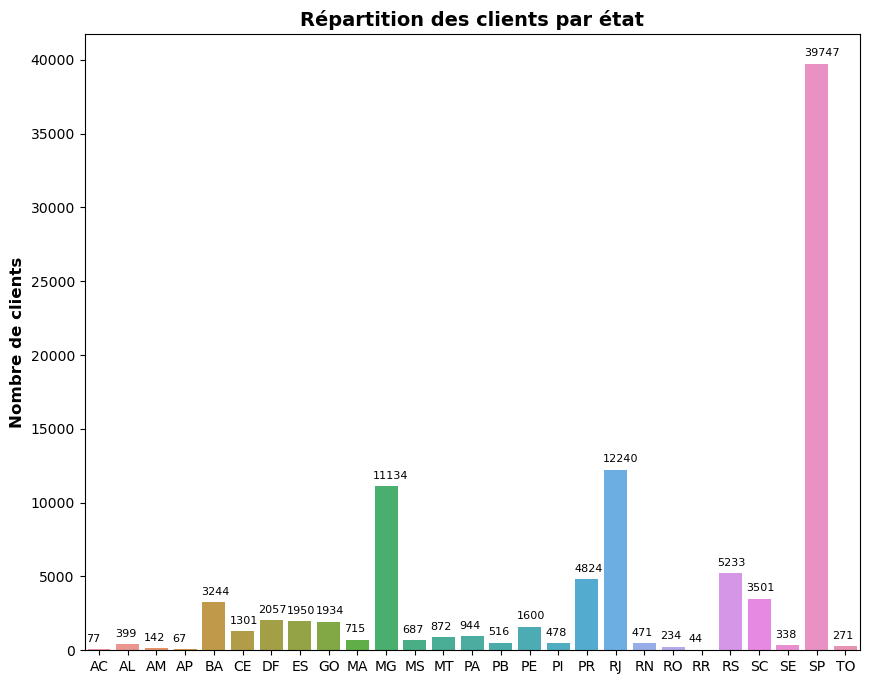

In [326]:
# Visualisation par histogramme

plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.barplot(data=client_par_etat, x="Etat", y="Nombre de clients")
    plt.xlabel('')
    plt.ylabel('Nombre de clients', fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition des clients par état", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

nb = client_par_etat["Nombre de clients"]
for i, v in enumerate(nb):
    plt.text(i-0.45,v+500, int(v), fontsize=8, fontname="sans-serif")

plt.show()      

**La majorité des clients proviennent respectivement des états de Sao Paulo (comme pour les vendeurs), de Rio de Janeiro et de Minas Gerais.**

**NOMBRE DE COMMANDES PAR CLIENT**

In [327]:
# Création d'un dataframe
commande_par_client = jointure_finale.groupby("customer_unique_id").agg({"order_id": "nunique"})
commande_par_client = commande_par_client.reset_index()

# Renommage des colonnes
commande_par_client.columns = ["Client", "Nombre de commandes"]
commande_par_client.head()

,Client,Nombre de commandes
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [328]:
# Description de la colonne 'Nombre de commandes'
commande_par_client["Nombre de commandes"].describe()

count    94982.000000
mean         1.033859
std          0.210812
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Nombre de commandes, dtype: float64

Nous pouvons tout de suite remarquer qu'au moins 75% des clients n'ont passé qu'une seule commande!!! Au moins un client a passé 16 commandes.

In [329]:
# Nombre de clients pour chaque nombre de commande
commande_par_client["Nombre de commandes"].value_counts(normalize=True)

1     0.969605
2     0.027911
3     0.001979
4     0.000305
5     0.000095
6     0.000053
7     0.000032
9     0.000011
16    0.000011
Name: Nombre de commandes, dtype: float64

Seuls 3% de clients ont passé plus d'une commande. Ces derniers seront potentiellement les clients les plus intérressants pour Olist.

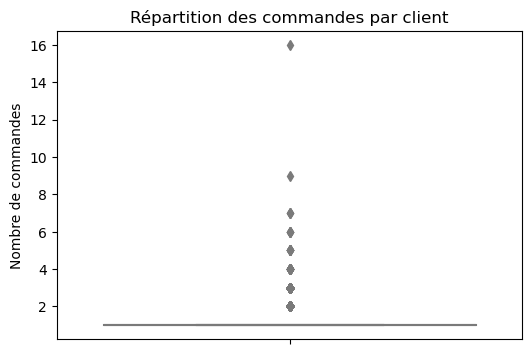

In [330]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=commande_par_client, y = "Nombre de commandes")
    plt.title("Répartition des commandes par client")
    plt.show()

### 3. Création des variables 'montant_total' et "nb_commandes" par client

**Il est à noter que les variables 'nb_commandes' et  'montant total' correspondront respectivement à la fréquence (F) au Montant (M) pour la segmentation RFM.** 

**CREATION DU DATAFRAME**

In [331]:
info_commandes = jointure_finale.groupby(by="customer_unique_id").agg({"order_id": "nunique", "payment_value":"sum"}).reset_index()
info_commandes.columns = ["customer_unique_id", "nb_achats", "montant_total"]
info_commandes.head()

,customer_unique_id,nb_achats,montant_total
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89


**JOINTURE AVEC LE DATAFRAME "jointure_finale"**

**Cette jointure sera réalisée grâce à la clé étrangère 'customer_unique_id'**

In [332]:
jointure_finale = pd.merge(jointure_finale, info_commandes, on="customer_unique_id", how= 'left')
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12


### 4. Création de la variable 'date_dernier_achat' et 'delai_moyen_livraison' par client

**La variable 'date_dernier_achat' correspond à la récence (R), dernier élement de la segmentation RFM**

**CREATION DES 2 VARIABLES**

In [333]:
# Création d'une variable 'temps_ecoule_achat'
jointure_finale["temps_ecoule_achat"] = (jointure_finale["order_purchase_timestamp"].max() - jointure_finale["order_purchase_timestamp"]).dt.round('1d').dt.days
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46,41
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12,26


In [334]:
# Création du dataframe comprenant les 2 variables
temps_delais = jointure_finale.groupby(by="customer_unique_id").agg({"temps_ecoule_achat": "min", "delai_livraison": "mean"}).reset_index()
temps_delais.columns = ["customer_unique_id", "recence", "delai_livraison_moyen"]
temps_delais.head()

,customer_unique_id,recence,delai_livraison_moyen
0,0000366f3b9a7992bf8c76cfdf3221e2,116,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3.0
2,0000f46a3911fa3c0805444483337064,542,26.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,20.0
4,0004aac84e0df4da2b147fca70cf8255,293,13.0


**JOINTURE AVEC LE DATAFRAME 'jointure_finale'**

Cette jointure sera réalisée grâce à la clé étrangère 'customer_unique_id'

**La jointure**

In [335]:
jointure_finale = pd.merge(jointure_finale, temps_delais, on='customer_unique_id', how='left')
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat,recence,delai_livraison_moyen
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46,41,41,14.00
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12,26,26,9.00


### 5. Information sur le jeu de données à ce stade

In [336]:
jointure_finale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   116764 non-null  float64       
 9   delai_reponse                  116764 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

## Conclusion à la suite de ces jointures

### Principaux points à retenir
- **Nettoyage des données conduisant à une perte de très peu de clients (environ 1,16%) étant certainement des clients n'ayant passé qu'une seule commande donc 'mauvais clients'.**
- **Imputation des données manquantes réalisée sur la quasi-totalité des variables.**
- **Création de certaines variables déjà réalisées pour la segmentation des clients.**

### Etapes suivantes: Ciblage sur le clients
- **Features engineering avant la création du dataset clients**
- **Analyse et choix des variables pertinentes pour la segmentation des clients**
- **Ciblage sur le client (1 ligne = 1 client).**

# 2. Le ciblage sur le client

## 2.1. Création d'une variable score_moyen par commande

**Création du dataframe score_moyen_commande**

In [337]:
score_moyen_commande = jointure_finale.groupby(by='order_id').agg({"review_score":"mean"}).reset_index() 
score_moyen_commande = score_moyen_commande.rename(columns={"review_score": "score_moyen"})
score_moyen_commande.head()

,order_id,score_moyen
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


**Jointure avec le dataframe jointure_finale via la clé étrangère order_id**

In [338]:
jointure_finale = pd.merge(jointure_finale, score_moyen_commande, on="order_id", how='left')
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat,recence,delai_livraison_moyen,score_moyen
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46,41,41,14.00,4.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12,26,26,9.00,5.0


**Informations sur le jeu de données**

In [339]:
jointure_finale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   116764 non-null  float64       
 9   delai_reponse                  116764 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

**Imputation des données manquantes pour les clients n'ayant pas répondu au questionnaire**

*La note*

In [340]:
# Les clients n'ayant pas donné les avis
clients_sans_note = jointure_finale[jointure_finale["review_score"].isna()]
clients_sans_note.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat,recence,delai_livraison_moyen,score_moyen
20,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-20 01:38:59,2018-02-06,17,17,NaN,NaN,0,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,20850.0,100.0,25.0,50.0,125000.0,construction,8840,mogi das cruzes,SP,-23.482178,-46.138049,1.0,credit_card,10.0,1376.45,1.0,10.0,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,-22.879075,-43.314672,2,1441.62,244,244,15.0,NaN
192,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-20 11:33:07,2018-02-07,10,18,NaN,NaN,0,1.0,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,2018-01-18 02:32:30,53.99,15.13,200.0,16.0,16.0,13.0,3328.0,sante_beaute,9015,santo andre,SP,-23.659364,-46.523183,1.0,boleto,1.0,69.12,1.0,1.0,528b011eb7fab3d59c336cc7248eed3a,38600,paracatu,MG,-17.224179,-46.874265,1,69.12,236,236,10.0,NaN
370,4906eeadde5f70b308c20c4a8f20be02,4e7656e34357b93f14b40c6400ca3f6e,delivered,2017-12-08 04:45:26,2018-01-09 18:04:58,2018-01-03,33,-7,NaN,NaN,0,1.0,ee406bf28024d97771c4b1e8b7e8e219,7a67c85e85bb2ce8582c35f2203ad736,2017-12-18 03:50:30,144.99,17.26,1050.0,36.0,24.0,22.0,19008.0,cadeaux_fetes,3426,sao paulo,SP,-23.552336,-46.536869,1.0,boleto,1.0,162.25,1.0,1.0,ea870f4fdfd85ac98ab775b76efe3143,23065,rio de janeiro,RJ,-22.882938,-43.625086,1,162.25,269,269,33.0,NaN
454,b7a4a9ecb1cd3ef6a3e36a48e200e3be,c3d8fc500d86b1c961ee144395c13a57,delivered,2017-05-19 18:13:54,2017-06-08 07:53:42,2017-06-16,20,8,NaN,NaN,0,1.0,41171e11f920c47deb1809edda2bf09d,c42fd8e4d47dfb18ce5222f2dd7752f9,2017-05-30 11:35:41,26.00,15.10,200.0,16.0,16.0,16.0,4096.0,maison_fournitures,6246,osasco,SP,-23.498859,-46.807066,1.0,credit_card,4.0,41.10,1.0,4.0,367f4686d7112d69feed92b02a1775ed,88501,lages,SC,-27.817724,-50.330752,2,698.70,472,472,51.2,NaN
462,59b32faedc12322c672e95ec3716d614,5baa82a2c45fa3220cb57d9881db3211,delivered,2018-06-27 11:10:11,2018-07-06 16:37:36,2018-07-26,9,19,NaN,NaN,0,1.0,040f34fe061b6024771f641fe922e782,850f4f8af5ea87287ac68de36e29107f,2018-07-02 02:15:51,69.00,18.58,750.0,18.0,10.0,15.0,2700.0,cadeaux_fetes,4367,sao paulo,SP,-23.651458,-46.667265,1.0,boleto,1.0,87.58,1.0,1.0,c56d066e503008b8d0bf4204857c588d,97110,santa maria,RS,-29.699989,-53.732680,1,87.58,68,68,9.0,NaN


In [341]:
# Nombre de commandes pour ces clients sans avis
commande_clients_sans_note = clients_sans_note.groupby("customer_unique_id").agg({"order_id": "nunique"})
commande_clients_sans_note = commande_clients_sans_note.reset_index()

# Renommage des colonnes
commande_clients_sans_note.columns = ["Client", "Nombre de commandes"]
commande_clients_sans_note.head()

,Client,Nombre de commandes
0,001ae44fa04911a9e9577356dce6c63c,1
1,00bee19e1199bc5cede1c674177b9e22,1
2,00fb9cc86736fe3782dbc828a2eea4a6,1
3,025cf7c2f32536f0be1ab412bb6602d2,1
4,030fde5155e0240c5d3c55206fdadd6e,1


In [342]:
# Description de la colonne 'Nombre de commandes'
commande_clients_sans_note["Nombre de commandes"].describe()

count    721.000000
mean       1.015257
std        0.122657
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: Nombre de commandes, dtype: float64

In [343]:
# Client(s) ayant passé 2 commandes
client_2_commandes = commande_clients_sans_note[commande_clients_sans_note["Nombre de commandes"]==2]
client_2_commandes

,Client,Nombre de commandes
115,2ca8ef8560c5cd0f9ddb65d1b1b51380,2
140,367f4686d7112d69feed92b02a1775ed,2
167,3db6e5afa8e8178a29afc729855315e2,2
333,79f227df52caf2b68d36e990ff3fc652,2
500,b525fc8cce07342fb00ab3b2667c8eb9,2
502,b59e4bb4efe81ba0f7d30cff6734f9a2,2
519,bd8ee6a65c4d647953792da821444580,2
546,c55821f6a2a59a93d4cde13a2ec14661,2
570,cb4f48aa5b4657435b012a65f2a122eb,2
632,e2226f481eef03f2876d1a27f0f4b1b0,2


**Après une petite recherche, seuls 2 clients ayant passé 2 commandes ont donné 1 avis sur l'autre commande (1 ou 5). Il est important de noter que le client insatisfait l'était sur sa première commande passé sur le site. Ainsi, l'ensemble des données manquantes seront imputées par la moyenne à savoir 4 (output 205).** 

In [344]:
# Liste des index sans note
liste_clients_sans_note = clients_sans_note.index.tolist()

# Imputation par la moyenne
for idx in liste_clients_sans_note:
    jointure_finale.loc[idx, "score_moyen"] = 4
    jointure_finale.loc[idx, "review_score"] = 4
    
# Vérification sur une ligne
jointure_finale.iloc[20,:]

order_id                         403b97836b0c04a622354cf531062e5f
customer_id                      738b086814c6fcc74b8cc583f8516ee3
order_status                                            delivered
order_purchase_timestamp                      2018-01-02 19:00:43
order_delivered_customer_date                 2018-01-20 01:38:59
order_estimated_delivery_date                 2018-02-06 00:00:00
delai_livraison                                                17
ecart_livraison                                                17
review_score                                                  4.0
delai_reponse                                                 NaN
avis_donne                                                      0
order_item_id                                                 1.0
product_id                       638bbb2a5e4f360b71f332ddfebfd672
seller_id                        c4af86330efa7a2620772227d2d670c9
shipping_limit_date                           2018-01-12 19:09:04
price     

Bonne attribution

*Le délai de réponse*

In [345]:
jointure_finale["delai_reponse"].describe()

count    116764.000000
mean          3.215931
std           9.752912
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         519.000000
Name: delai_reponse, dtype: float64

L'imputation sera réalisée sur la moyenne arrondie (3).

In [346]:
# Liste des index sans note
liste_clients_sans_note = clients_sans_note.index.tolist()

# Imputation par la moyenne
for idx in liste_clients_sans_note:
    jointure_finale.loc[idx, "delai_reponse"] = 3.0
    
# Vérification sur une ligne
jointure_finale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117725 entries, 0 to 117724
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117725 non-null  object        
 1   customer_id                    117725 non-null  object        
 2   order_status                   117725 non-null  object        
 3   order_purchase_timestamp       117725 non-null  datetime64[ns]
 4   order_delivered_customer_date  117725 non-null  datetime64[ns]
 5   order_estimated_delivery_date  117725 non-null  datetime64[ns]
 6   delai_livraison                117725 non-null  int64         
 7   ecart_livraison                117725 non-null  int64         
 8   review_score                   117725 non-null  float64       
 9   delai_reponse                  117725 non-null  float64       
 10  avis_donne                     117725 non-null  int32         
 11  

## 2.2. Features engineering sur les commandes

### 1. Nombre moyen de produits achetés par commande pour chaque client

**Création du dataframe**

In [347]:
# Comptage du nombre d'articles par commande pour chaque client
nombre_produits_commande_clients = jointure_finale.groupby(["customer_unique_id", "order_id"]).agg({"order_item_id": "count"})

# Nombre moyen d'article pour les commandes passées par un client
moyenne_produits_commande_clients = nombre_produits_commande_clients.groupby("customer_unique_id").agg({"order_item_id": "mean"}).reset_index()
moyenne_produits_commande_clients = moyenne_produits_commande_clients.rename(columns= {"order_item_id": "nb_moyen_produits"})
moyenne_produits_commande_clients.head()

,customer_unique_id,nb_moyen_produits
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.0
4,0004aac84e0df4da2b147fca70cf8255,1.0


**Description de la colonne 'nb_moyen_produits'**

In [348]:
moyenne_produits_commande_clients["nb_moyen_produits"].describe()

count    94982.000000
mean         1.192431
std          0.714182
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         38.000000
Name: nb_moyen_produits, dtype: float64

**Visualisation par boxplot**

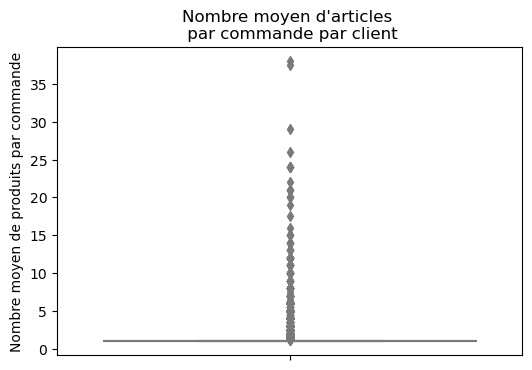

In [349]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=moyenne_produits_commande_clients, y = "nb_moyen_produits")
    plt.ylabel("Nombre moyen de produits par commande")
    plt.title("Nombre moyen d'articles \n par commande par client")
    
plt.show()

**Jointure avec le dataframe jointure_finale via la clé étrangère 'customer_unique_id'**

In [350]:
jointure_finale = pd.merge(jointure_finale, moyenne_produits_commande_clients, on="customer_unique_id", how='left')
jointure_finale.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat,recence,delai_livraison_moyen,score_moyen,nb_moyen_produits
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46,41,41,14.00,4.0,1.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12,26,26,9.00,5.0,1.0


### 3. Encodage manuel pour les catégories de produits

**Les algorithmes tels que le KMeans ou le DBSCAN ne sont pas adaptés pour le traitement de variables catégorielles. Afin d'effectuer les campagnes de communication, je pense qu'il serait intéressant de conserver les catégories de produits... De ce fait, un encodage manuel sera réalisé, ce dernier consistant à référencer le nombre de produits par catégorie pour chaque commande.**

In [351]:
# Comptage de chaque produit acheté par chaque client dans une catégorie
categories_clients = jointure_finale.groupby(["customer_unique_id", "categorie_produit"]).agg({"order_item_id": "count"}).unstack() # unstack = pivot: clients en lignes et catégorie en colonnes
categories_clients.columns = categories_clients.columns.droplevel(0) # Drop de order_item_id
categories_clients.fillna(0, inplace=True)
categories_clients["nb_total_produits"] = categories_clients.sum(axis=1)

# Pourcentage du nombre de produits par catégorie sur le nombre total de produits
for col in categories_clients.columns:
    if (col != "nb_total_produits"):
        categories_clients[col] = (categories_clients[col]/categories_clients["nb_total_produits"])

categories_clients.reset_index(inplace=True) 
categories_clients.head()

categorie_produit,customer_unique_id,autres,boutiques,cadeaux_fetes,construction,epicerie_nourriture_boissons,jouets_equipement_bebes,livres_cd_dvd,loisirs,maison_fournitures,mode_habillement_accessoires,sante_beaute,technologies,nb_total_produits
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [352]:
categories_clients["nb_total_produits"].describe()

count    94982.000000
mean         1.239445
std          0.851729
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: nb_total_produits, dtype: float64

In [353]:
# Vérification du nombre de lignes donc du nombre de clients (attendu 94983)
print(f'Ce jeu de données comprend {categories_clients.shape[0]} clients.')

Ce jeu de données comprend 94982 clients.


## 2.3. Sauvegarde du jeu de données avec la création du dataset Client

In [354]:
jointure_finale = jointure_finale.to_csv("jointure_csv", index=False)

# 3. Le dataset Client 

**Pour le moment, nous sommes en présence d'un jeu de données comprenant énormément de variables, dont certaines inutiles pour notre segmentation. En effet, certaines variables existantes ou créées nous ont permis soit de joindre les différentes tables, soit d'obtenir une meilleure visualisation du jeu de données.**

**Par conséquent, il est désormais indispensable de créer un dataset Client pour la segmentation des clients. Ce dernier comprendra une ligne par client et les variables utiles pour la segmentation.**

**Il sera réalisé en plusieurs étapes:**
- **Création et sauvegarde d'un dataset comprenant certaines variables qui ne seront probablement pas utilisées par la suite dans la modélisation mais qui pourront tout de même être utiles si nous souhaitons analyser plus précisément les clients de chaque cluster:**
    - **Les variables de localisation du client**
    - **Les variables sur les catégories de produits**
    - **Les variables sur les modalités de paiement**
- **Première élimination de variables inutiles**
- **Création avec les variables dont nous sommes déjà en possession**
- **Analyse exploratoire pouvant entraîner l'élimination de certaines variables**

In [355]:
file = pd.read_csv("jointure_csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
file.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delai_livraison,ecart_livraison,review_score,delai_reponse,avis_donne,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,produit_volume_cm3,categorie_produit,zip_vendeur,ville_vendeur,etat_vendeur,lat_vendeur,lng_vendeur,payment_sequential,payment_type,payment_installments,payment_value,nb_paiements_differents,nb_echeances,customer_unique_id,zip_client,ville_client,etat_client,lat_client,lng_client,nb_achats,montant_total,temps_ecoule_achat,recence,delai_livraison_moyen,score_moyen,nb_moyen_produits
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,1.0,credit_card,1.0,18.12,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,3.0,voucher,1.0,2.00,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,7,4.0,1.0,1,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,maison_fournitures,9350,maua,SP,-23.680729,-46.444238,2.0,voucher,1.0,18.59,3.0,3.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,82.82,336,336,6.25,4.0,2.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,5,4.0,1.0,1,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,sante_beaute,31570,belo horizonte,SP,-19.807681,-43.980427,1.0,boleto,1.0,141.46,1.0,1.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1,141.46,41,41,14.00,4.0,1.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,17,5.0,5.0,1,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,boutiques,14840,guariba,SP,-21.363502,-48.229601,1.0,credit_card,3.0,179.12,1.0,3.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1,179.12,26,26,9.00,5.0,1.0


In [356]:
# Copie du fichier
data = file.copy()

### 3.1. Création du dataset

**LES JOINTURES HORS LOCALISATION CLIENTS ET CATEGORIES DE PRODUITS**

In [357]:
# Données facultatives?
segmentation_client = data.groupby("customer_unique_id").agg({"nb_paiements_differents":"mean",
                                                            "nb_echeances": "mean",
                                                             "review_score": "mean",
                                                             "delai_reponse": "mean",
                                                             "ecart_livraison":"mean",
                                                             "order_item_id": "count"}).reset_index()
segmentation_client.columns = ["customer_unique_id", "nb_paiements_differents", "nb_echeances", "score_moyen", "delai_reponse", "ecart_livraison", "nb_produits"]

# Jointure avec les variables 'nb_achats' et 'montant_total'
segmentation_client = pd.merge(segmentation_client, info_commandes, on='customer_unique_id', how="left")
segmentation_client.columns = ["customer_unique_id", "nb_paiements_differents", "nb_echeances", "score_moyen", "delai_reponse", "ecart_livraison", "nb_produits", "frequence", "montant"]

# Jointure avec les variables 'recence' et 'delai_livraison_moyen'
segmentation_client = pd.merge(segmentation_client, temps_delais, on= 'customer_unique_id', how= "left")

# Jointure avec la variable 'moyenne_produits_commande_clients'
segmentation_client = pd.merge(segmentation_client, moyenne_produits_commande_clients, on='customer_unique_id', how = 'left')

segmentation_client = segmentation_client.reindex(columns=["customer_unique_id", "recence", "frequence", "montant", "score_moyen", "delai_livraison_moyen", "delai_reponse", "ecart_livraison", "nb_produits", "nb_moyen_produits", "nb_paiements_differents", "nb_echeances"])

segmentation_client.head()

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,5.0,4.0,1,1.0,1.0,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,1.0,4.0,1,1.0,1.0,1.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,26.0,1.0,1.0,1,1.0,1.0,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,1.0,11.0,1,1.0,1.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,5.0,7.0,1,1.0,1.0,6.0


**Ajout du prix moyen par commande**

In [358]:
segmentation_client["prix_moyen_commande"] = round(segmentation_client["montant"]/segmentation_client["frequence"], 2)
segmentation_client.head()

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances,prix_moyen_commande
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,5.0,4.0,1,1.0,1.0,8.0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,1.0,4.0,1,1.0,1.0,1.0,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,26.0,1.0,1.0,1,1.0,1.0,8.0,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,1.0,11.0,1,1.0,1.0,4.0,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,5.0,7.0,1,1.0,1.0,6.0,196.89


**LES INFORMATIONS SUR LES CATEGORIES DE PRODUITS**

In [359]:
segmentation_client = pd.merge(segmentation_client, categories_clients, on='customer_unique_id', how ='left')
segmentation_client.head()

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances,prix_moyen_commande,autres,boutiques,cadeaux_fetes,construction,epicerie_nourriture_boissons,jouets_equipement_bebes,livres_cd_dvd,loisirs,maison_fournitures,mode_habillement_accessoires,sante_beaute,technologies,nb_total_produits
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,5.0,4.0,1,1.0,1.0,8.0,141.90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,1.0,4.0,1,1.0,1.0,1.0,27.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,26.0,1.0,1.0,1,1.0,1.0,8.0,86.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,1.0,11.0,1,1.0,1.0,4.0,43.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,5.0,7.0,1,1.0,1.0,6.0,196.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


**LES INFORMATIONS DE LOCALISATION DES CLIENTS**

In [360]:
# Selection des données les plus fréquentes pour chaque client
info_clients = jointure_2.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
segmentation_client = pd.merge(segmentation_client, info_clients, on ='customer_unique_id', how="left")

segmentation_client.head()

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances,prix_moyen_commande,autres,boutiques,cadeaux_fetes,construction,epicerie_nourriture_boissons,jouets_equipement_bebes,livres_cd_dvd,loisirs,maison_fournitures,mode_habillement_accessoires,sante_beaute,technologies,nb_total_produits,customer_id,zip_client,ville_client,etat_client,lat_client,lng_client
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,5.0,4.0,1,1.0,1.0,8.0,141.90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,-23.340235,-46.830140
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,1.0,4.0,1,1.0,1.0,1.0,27.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,-23.559115,-46.787626
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,26.0,1.0,1.0,1,1.0,1.0,8.0,86.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,-27.542880,-48.633426
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,1.0,11.0,1,1.0,1.0,4.0,43.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,-1.312214,-48.483159
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,5.0,7.0,1,1.0,1.0,6.0,196.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,-23.505548,-47.469705


In [361]:
# Informations sur le jeu de données pour la segmentation
segmentation_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94982 entries, 0 to 94981
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            94982 non-null  object 
 1   recence                       94982 non-null  int64  
 2   frequence                     94982 non-null  int64  
 3   montant                       94982 non-null  float64
 4   score_moyen                   94982 non-null  float64
 5   delai_livraison_moyen         94982 non-null  float64
 6   delai_reponse                 94982 non-null  float64
 7   ecart_livraison               94982 non-null  float64
 8   nb_produits                   94982 non-null  int64  
 9   nb_moyen_produits             94982 non-null  float64
 10  nb_paiements_differents       94982 non-null  float64
 11  nb_echeances                  94982 non-null  float64
 12  prix_moyen_commande           94982 non-null  float64
 13  a

### 3.2. Analyse exploratoire du jeu de données pour la segmentation

**LA RECENCE**

**Description de la variable**

In [362]:
segmentation_client['recence'].describe()

count    94982.000000
mean       243.176865
std        152.979723
min          0.000000
25%        119.000000
50%        224.000000
75%        352.000000
max        728.000000
Name: recence, dtype: float64

**Visualisation par histogramme**

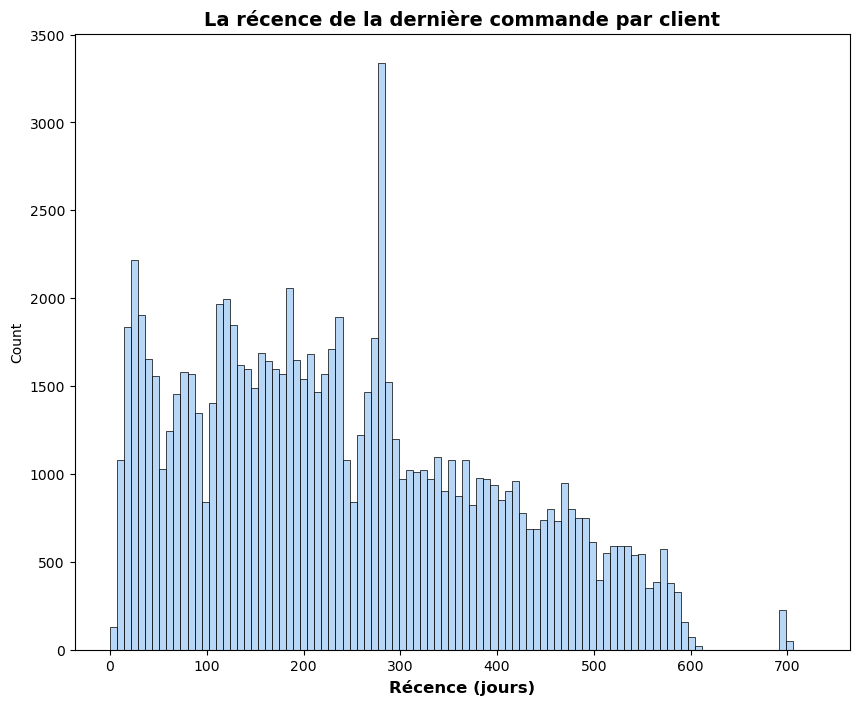

In [363]:
plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=segmentation_client, x="recence", bins=100)
    plt.xlabel("Récence (jours)", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("La récence de la dernière commande par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

plt.show()     

Globlablement, le jour de la dernière commande s'étale du jour même jusqu'à 700 jours, avec peu de clients ayant commandés dans les 3 derniers mois...

**Visualisation par boxplot**

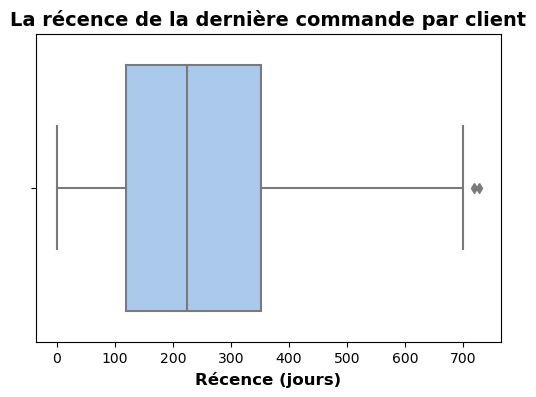

In [364]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x = "recence")
    plt.xlabel("Récence (jours)", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("La récence de la dernière commande par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    plt.show()

**LA FREQUENCE**

**Description de la variable**

In [365]:
segmentation_client['frequence'].describe()

count    94982.000000
mean         1.033859
std          0.210812
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequence, dtype: float64

**Visualisation par histogramme**

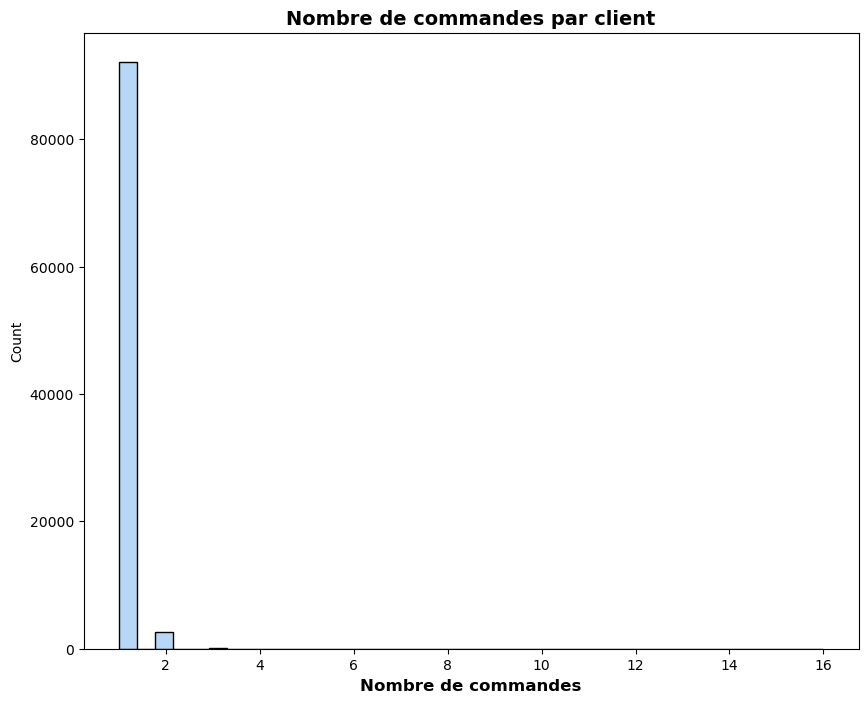

In [366]:
plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=segmentation_client, x="frequence", bins=39)
    plt.xlabel("Nombre de commandes", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Nombre de commandes par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

plt.show()      

Cette analyse avait déjà été réalisée et il n'est donc pas surprenant de se retrouver avec la quasi-totalité des clients n'ayant passé qu'une seule commande dans ce nouveau jeu de données.

**Visualisation par boxplot**

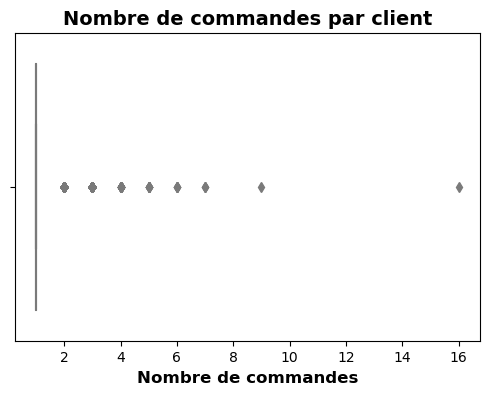

In [367]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x = "frequence")
    plt.xlabel("Nombre de commandes", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Nombre de commandes par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    plt.show()

**LE MONTANT**

**Description de la variable**

In [368]:
segmentation_client['montant'].describe()

count    94982.000000
mean       212.205887
std        537.731331
min          9.590000
25%         63.990000
50%        113.310000
75%        203.080000
max      45256.000000
Name: montant, dtype: float64

**Visualisation par histogramme**

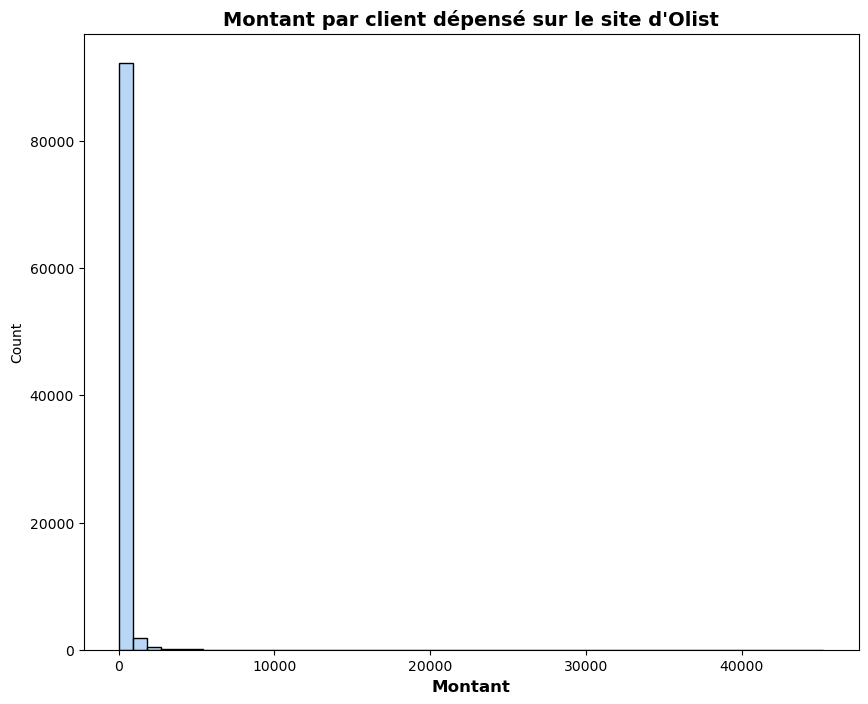

In [369]:
plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.histplot(data=segmentation_client, x="montant", bins=50)
    plt.xlabel("Montant", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Montant par client dépensé sur le site d\'Olist", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

plt.show()      

75% des clients n'ont dépensé pas  plus de 203 RS... Un client a dépensé plus de 100000 RS!!!

**Visualisation par boxplot**

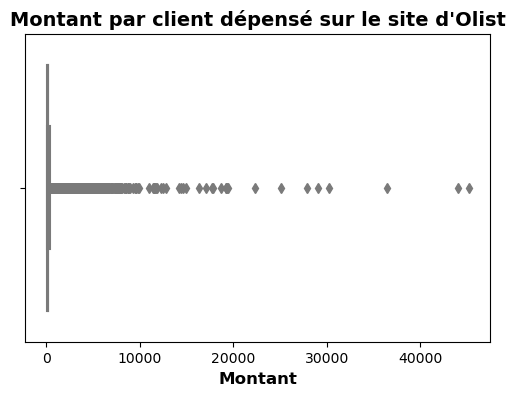

In [370]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x = "montant")
    plt.xlabel("Montant", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Montant par client dépensé sur le site d\'Olist", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    plt.show()

**LE SCORE MOYEN**

**Visualisation par boxplot**

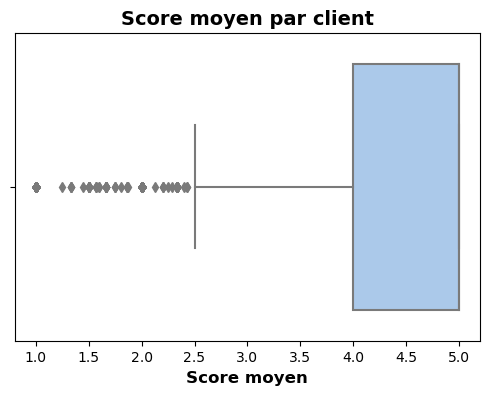

In [371]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x = "score_moyen")
    plt.xlabel("Score moyen", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Score moyen par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
    plt.show()

Cette visualisation est très intéressante car elle met déjà en évidence au moins un groupe de clients très satisfaits et un groupe insatisfait.

**LE DELAI MOYEN DE LIVRAISON**

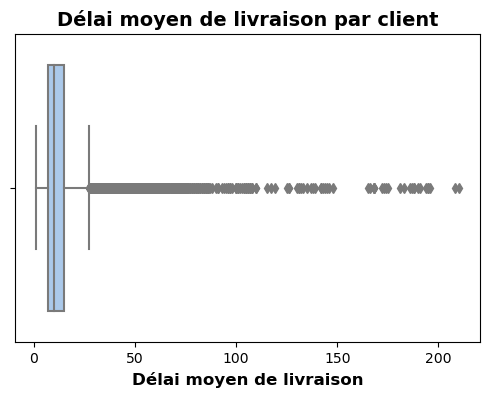

In [372]:
plt.figure(figsize=(6,4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x = "delai_livraison_moyen")
    plt.xlabel("Délai moyen de livraison", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Délai moyen de livraison par client", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
plt.show()

**LA REPARTITION DU NOMBRE MOYEN D'ARTICLES PAR COMMANDE POUR CHAQUE CLIENT**

**Description de la variable**

In [373]:
segmentation_client['nb_moyen_produits'].describe()

count    94982.000000
mean         1.192431
std          0.714182
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         38.000000
Name: nb_moyen_produits, dtype: float64

**Visualisation par histogramme**

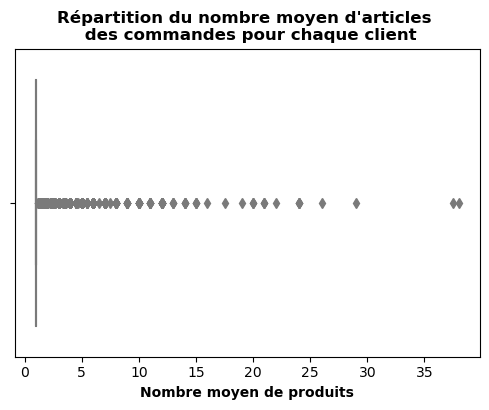

In [374]:
plt.figure(figsize=(6, 4))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x="nb_moyen_produits")
    plt.xlabel("Nombre moyen de produits", fontname = 'sans-serif', fontsize= 10, fontweight="bold")
    plt.title("Répartition du nombre moyen d\'articles \n des commandes pour chaque client", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
plt.show()      

Nous pouvons remarquer que la majorité des commandes réalisées pour chaque client ne comporte en moyenne qu'un seul article.

**LA REPARTITION DU MONTANT TOTAL EN FONCTION DE NOMBRE MOYEN D'ARTICLES**

**Visualisation graphique**

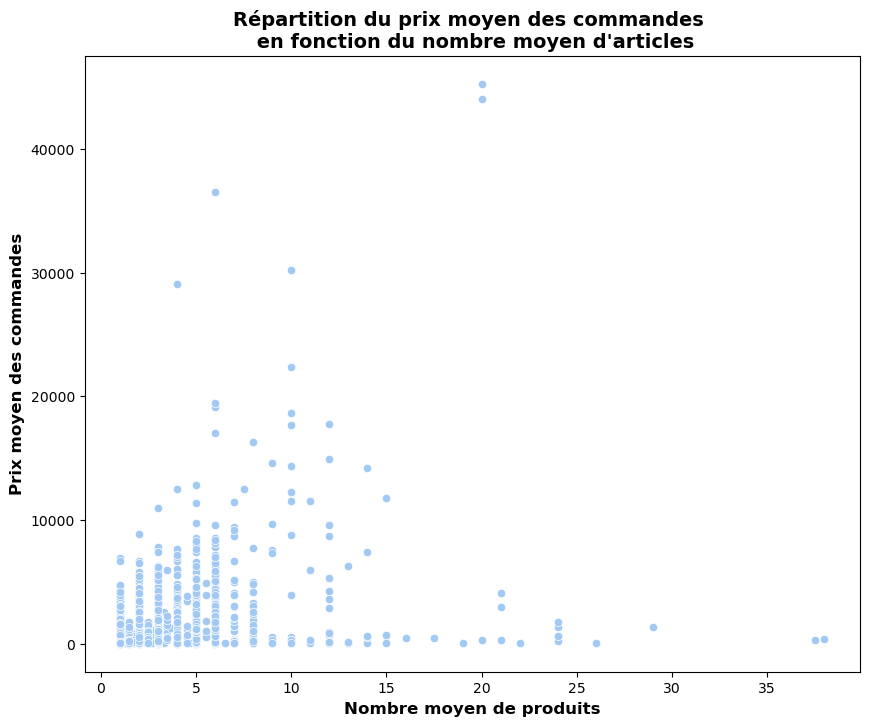

In [375]:
plt.figure(figsize=(10, 8))
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.scatterplot(data=segmentation_client, x="nb_moyen_produits", y="prix_moyen_commande")
    plt.xlabel("Nombre moyen de produits", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel("Prix moyen des commandes", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Répartition du prix moyen des commandes \n en fonction du nombre moyen d\'articles", fontname = 'sans-serif', fontsize= 14, fontweight="bold")

plt.show()      

Il ne semble pas y avoir de corrélation entre le nombre moyen d'articles et le montant moyen des commandes. Néanmoins, il est à noter que des commandes comportant plus de 10 articles présentent des prix plus bas... Nous allons donc regarder ces commandes atypiques...

**Commandes aberrantes ou atypiques?**

In [376]:
commandes_atypiques = segmentation_client[(segmentation_client["nb_moyen_produits"]>=25)]
commandes_atypiques

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances,prix_moyen_commande,autres,boutiques,cadeaux_fetes,construction,epicerie_nourriture_boissons,jouets_equipement_bebes,livres_cd_dvd,loisirs,maison_fournitures,mode_habillement_accessoires,sante_beaute,technologies,nb_total_produits,customer_id,zip_client,ville_client,etat_client,lat_client,lng_client
32226,569aa12b73b5f7edeaa6f2a01603e381,453,1,62.68,5.0,15.00,6.00,5.00,26,26.0,26.00,26.00,62.68,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,0.0,0.0,26.0,92cd3ec6e2d643d4ebd0e3d6238f69e2,3266,sao paulo,SP,-23.598386,-46.536700
41548,6fbc7cdadbb522125f4b27ae9dee4060,345,1,411.48,5.0,25.00,1.00,4.00,38,38.0,19.00,19.00,411.48,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,38.0,13aa59158da63ba0e93ec6ac2c07aacb,23070,rio de janeiro,RJ,-22.896408,-43.577510
51562,8af7ac63b2efbcbd88e5b11505e8098a,501,1,1368.53,1.0,10.00,4.00,17.00,29,29.0,29.00,29.00,1368.53,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,29.0,9af2372a1e49340278e7c1ef8d749f34,78065,cuiaba,MT,-15.617234,-56.077693
57360,9a736b248f67d166d2fbb006bcb877c3,391,2,556.13,5.0,5.84,2.68,14.84,75,37.5,19.56,19.56,278.06,0.0,0.0,0.0,0.0,0.0,0.56,0.0,0.0,0.44,0.0,0.0,0.0,75.0,270c23a11d024a44c896d1894b261a83,3227,sao paulo,SP,-23.586366,-46.571079


Au vue des catégories, il s'agit plus de commandes atypiques que de commandes aberrantes. De plus, comme nous l'avions précédemment mentionné, des produits peuvent être soldés...

**LA REPARTITION DU MONTANT TOTAL DES COMMANDES PAR ETAT**

**Visualisation graphique**

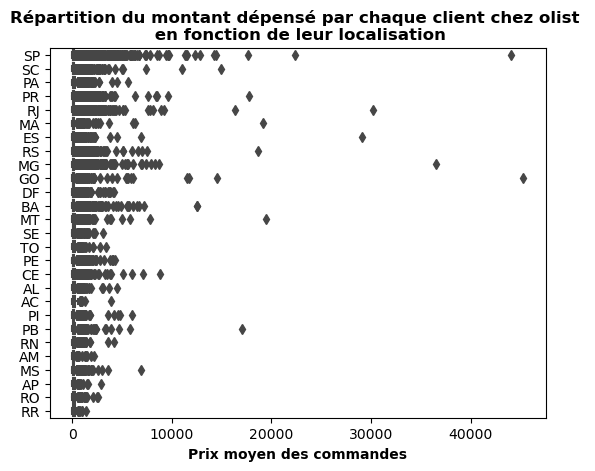

In [377]:
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=segmentation_client, x="prix_moyen_commande", y="etat_client")
    plt.xlabel("Prix moyen des commandes", fontname = 'sans-serif', fontsize= 10, fontweight="bold")
    plt.ylabel("")
    plt.title("Répartition du montant dépensé par chaque client chez olist \n en fonction de leur localisation", fontname = 'sans-serif', fontsize= 12, fontweight="bold")

plt.show()      

Cette visualisation est très difficilement interprétable due à la présence de quelques gros montants de dépenses. Comme nous avons précédemment vu que plus de 75% des commandes ne dépassaient pas un montant moyen de 200 RS et au vu de ce graphique, il parait pertinent de seuiller à 2000 afin d'avoir une meilleure vue d'ensemble.

**Visualisation avec seuillage**

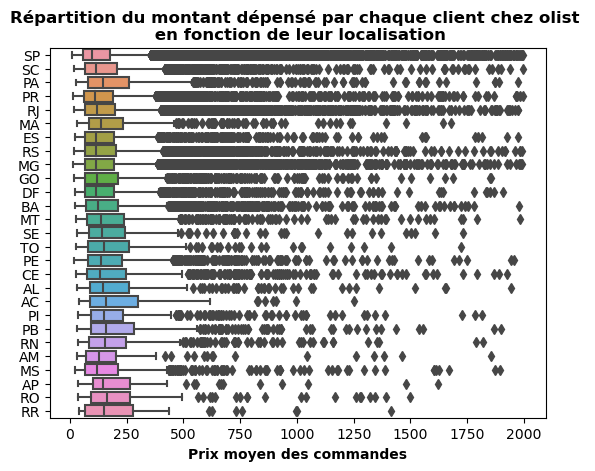

In [378]:
# Création du dataframe
commandes_seuillage = segmentation_client[segmentation_client["prix_moyen_commande"]<=2000]

# Visualisation par histogramme
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.boxplot(data=commandes_seuillage, x="prix_moyen_commande", y="etat_client")
    plt.xlabel("Prix moyen des commandes", fontname = 'sans-serif', fontsize= 10, fontweight="bold")
    plt.ylabel("")
    plt.title("Répartition du montant dépensé par chaque client chez olist \n en fonction de leur localisation", fontname = 'sans-serif', fontsize= 12, fontweight="bold")

plt.show()  

Il ne semble pas y avoir d'influence sur la localisation du client par rapport aux dépenses effectuées chez Olist... Afin de confirmer cette hypothèse, des tests statistiques seront réalisés.

In [379]:
from scipy import stats

**Test de normalité**

Dans un premier temps, même si cela est visible que la distribution des montants ne suit pas une loi normal, le test de normalité sera réalisée sur les 5 premiers états. S'il s'avère qu'au moins un état ne suit pas une loi normale, il sera indispensable d'utiliser le test de Kruskall-Wallis et non un anova.

In [380]:
# Création des 6 dataframes
sp = segmentation_client[segmentation_client["etat_client"]=="SP"]
sc = segmentation_client[segmentation_client["etat_client"]=="SC"]
pa = segmentation_client[segmentation_client["etat_client"]=="PA"]
pr = segmentation_client[segmentation_client["etat_client"]=="PR"]
rj = segmentation_client[segmentation_client["etat_client"]=="RJ"]
ma = segmentation_client[segmentation_client["etat_client"]=="MA"]

In [381]:
# Création des 6 variables
sp_montant = sp["prix_moyen_commande"]
sc_montant = sc["prix_moyen_commande"]
pa_montant = pa["prix_moyen_commande"]
pr_montant = pr["prix_moyen_commande"]
rj_montant = rj["prix_moyen_commande"]
ma_montant = ma["prix_moyen_commande"]

In [382]:
# Test de normalité
sp_montant_shapiro = stats.shapiro(sp_montant)
print(sp_montant_shapiro)
sc_montant_shapiro = stats.shapiro(sc_montant)
print(sc_montant_shapiro)
pa_montant_shapiro = stats.shapiro(pa_montant)
print(pa_montant_shapiro)
pr_montant_shapiro = stats.shapiro(pr_montant)
print(pr_montant_shapiro)
rj_montant_shapiro = stats.shapiro(rj_montant)
print(rj_montant_shapiro)
ma_montant_shapiro = stats.shapiro(ma_montant)
print(ma_montant_shapiro)

ShapiroResult(statistic=0.22549724578857422, pvalue=0.0)
ShapiroResult(statistic=0.28689008951187134, pvalue=0.0)
ShapiroResult(statistic=0.4963230490684509, pvalue=1.401298464324817e-45)
ShapiroResult(statistic=0.2721971273422241, pvalue=0.0)
ShapiroResult(statistic=0.2522544860839844, pvalue=0.0)
ShapiroResult(statistic=0.17166298627853394, pvalue=0.0)


C:\Users\colin\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Comme nous sommes en présence d'un grand nombre de données, la p-value peut-être biaisée... Néanmoins, pour un des états testés (PA), la p-value est bien inférieure à 0.05, siginifiant donc une distribution non normale... Le test de Kruskall-Wallis sera donc réalisé sur l'ensemble des états.

**Test de Kruskall-Wallis**

In [383]:
from pingouin import kruskal

kruskal_montant = kruskal(dv='prix_moyen_commande', between='etat_client', data=segmentation_client)
kruskal_montant

,Source,ddof1,H,p-unc
Kruskal,etat_client,26,1660.317358,0.0


D'après ce test, il semblerait qu'il puisse exister des différences entre les états au niveau des montants des commandes. De ce fait, afin de déterminer les différences statistiquement significatives entre l'état et le montant des dépenses d'un client, le test de Dunn sera réalisé.

In [384]:
import scikit_posthocs as sp

dunn_montant = sp.posthoc_dunn(segmentation_client, 'prix_moyen_commande', 'etat_client', p_adjust='bonferroni')
dunn_montant

,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
AC,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,9.411033e-02,5.244593e-02,6.267543e-01,1.000000e+00,7.554989e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.521408e-02,2.572407e-01,1.000000e+00,1.000000e+00,1.0,1.375066e-01,1.823984e-01,1.000000e+00,9.389698e-05,1.000000e+00
AL,1.000000,1.000000e+00,1.000000,1.000000,3.961931e-03,1.000000e+00,9.615237e-07,1.531616e-07,4.954748e-04,1.000000e+00,5.883307e-08,3.279434e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.221031e-10,5.067427e-06,1.000000e+00,1.000000e+00,1.0,9.076360e-07,3.798668e-06,1.000000e+00,8.032116e-20,1.000000e+00
AM,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.689056e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,4.751410e-01,1.000000e+00
AP,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.274395e-01,7.449170e-02,7.287403e-01,1.000000e+00,1.060208e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.443169e-02,3.256007e-01,1.000000e+00,1.000000e+00,1.0,1.825914e-01,2.357102e-01,1.000000e+00,2.468462e-04,1.000000e+00
BA,1.000000,3.961931e-03,1.000000,1.000000,1.000000e+00,2.985350e-02,3.734213e-01,4.444138e-02,1.000000e+00,3.456169e-03,1.275230e-03,1.000000e+00,8.104992e-01,1.509382e-04,1.367623e-10,2.929928e-02,6.562194e-04,3.318815e-07,1.000000e+00,4.062903e-02,4.605875e-03,1.0,2.254531e-01,1.000000e+00,2.483085e-01,3.780549e-42,5.577911e-01
CE,1.000000,1.000000e+00,1.000000,1.000000,2.985350e-02,1.000000e+00,1.497212e-07,9.003282e-09,2.435889e-03,1.000000e+00,1.493823e-11,9.122710e-01,1.000000e+00,1.000000e+00,1.262214e-02,1.000000e+00,1.000000e+00,3.551893e-15,9.352127e-08,1.000000e+00,1.000000e+00,1.0,1.233576e-08,3.789245e-07,1.000000e+00,6.062759e-40,1.000000e+00
DF,0.094110,9.615237e-07,1.000000,0.127439,3.734213e-01,1.497212e-07,1.000000e+00,1.000000e+00,1.000000e+00,8.550587e-08,1.000000e+00,1.000000e+00,8.720152e-05,4.313014e-10,2.770982e-16,6.577489e-08,4.889110e-08,1.000000e+00,1.000000e+00,1.140668e-05,7.062591e-06,1.0,1.000000e+00,1.000000e+00,3.950463e-04,1.507606e-10,2.194847e-03
ES,0.052446,1.531616e-07,1.000000,0.074492,4.444138e-02,9.003282e-09,1.000000e+00,1.000000e+00,1.000000e+00,7.907313e-09,1.000000e+00,1.000000e+00,1.010320e-05,2.511694e-11,1.687094e-17,3.261519e-09,6.028883e-09,1.000000e+00,1.000000e+00,1.812233e-06,1.735646e-06,1.0,1.000000e+00,1.000000e+00,9.257201e-05,1.005263e-07,6.323411e-04
GO,0.626754,4.954748e-04,1.000000,0.728740,1.000000e+00,2.435889e-03,1.000000e+00,1.000000e+00,1.000000e+00,3.209525e-04,1.000000e+00,1.000000e+00,9.565445e-02,1.186954e-05,1.087666e-11,2.272780e-03,6.861083e-05,2.610934e-02,1.000000e+00,5.305348e-03,7.978414e-04,1.0,1.000000e+00,1.000000e+00,4.496975e-02,2.546464e-19,1.225415e-01
MA,1.000000,1.000000e+00,1.000000,1.000000,3.456169e-03,1.000000e+00,8.550587e-08,7.907313e-09,3.209525e-04,1.000000e+00,3.590656e-10,8.744932e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.645569e-13,2.207472e-07,1.000000e+00,1.000000e+00,1.0,2.965733e-08,3.047999e-07,1.000000e+00,1.096824e-28,1.000000e+00


Au vu de ces résultats, nous sommes bien en présence de différences statistiquement significatives entre différents états... Ainsi, dans certains cas, la localisation du client présenterait un impact sur le montant moyen des dépenses. Toutefois, ce résultats est à prendre avec précaution car la majorité des clients n'ont passé qu'une seule commande...

**MATRICE DE CORRELATION**

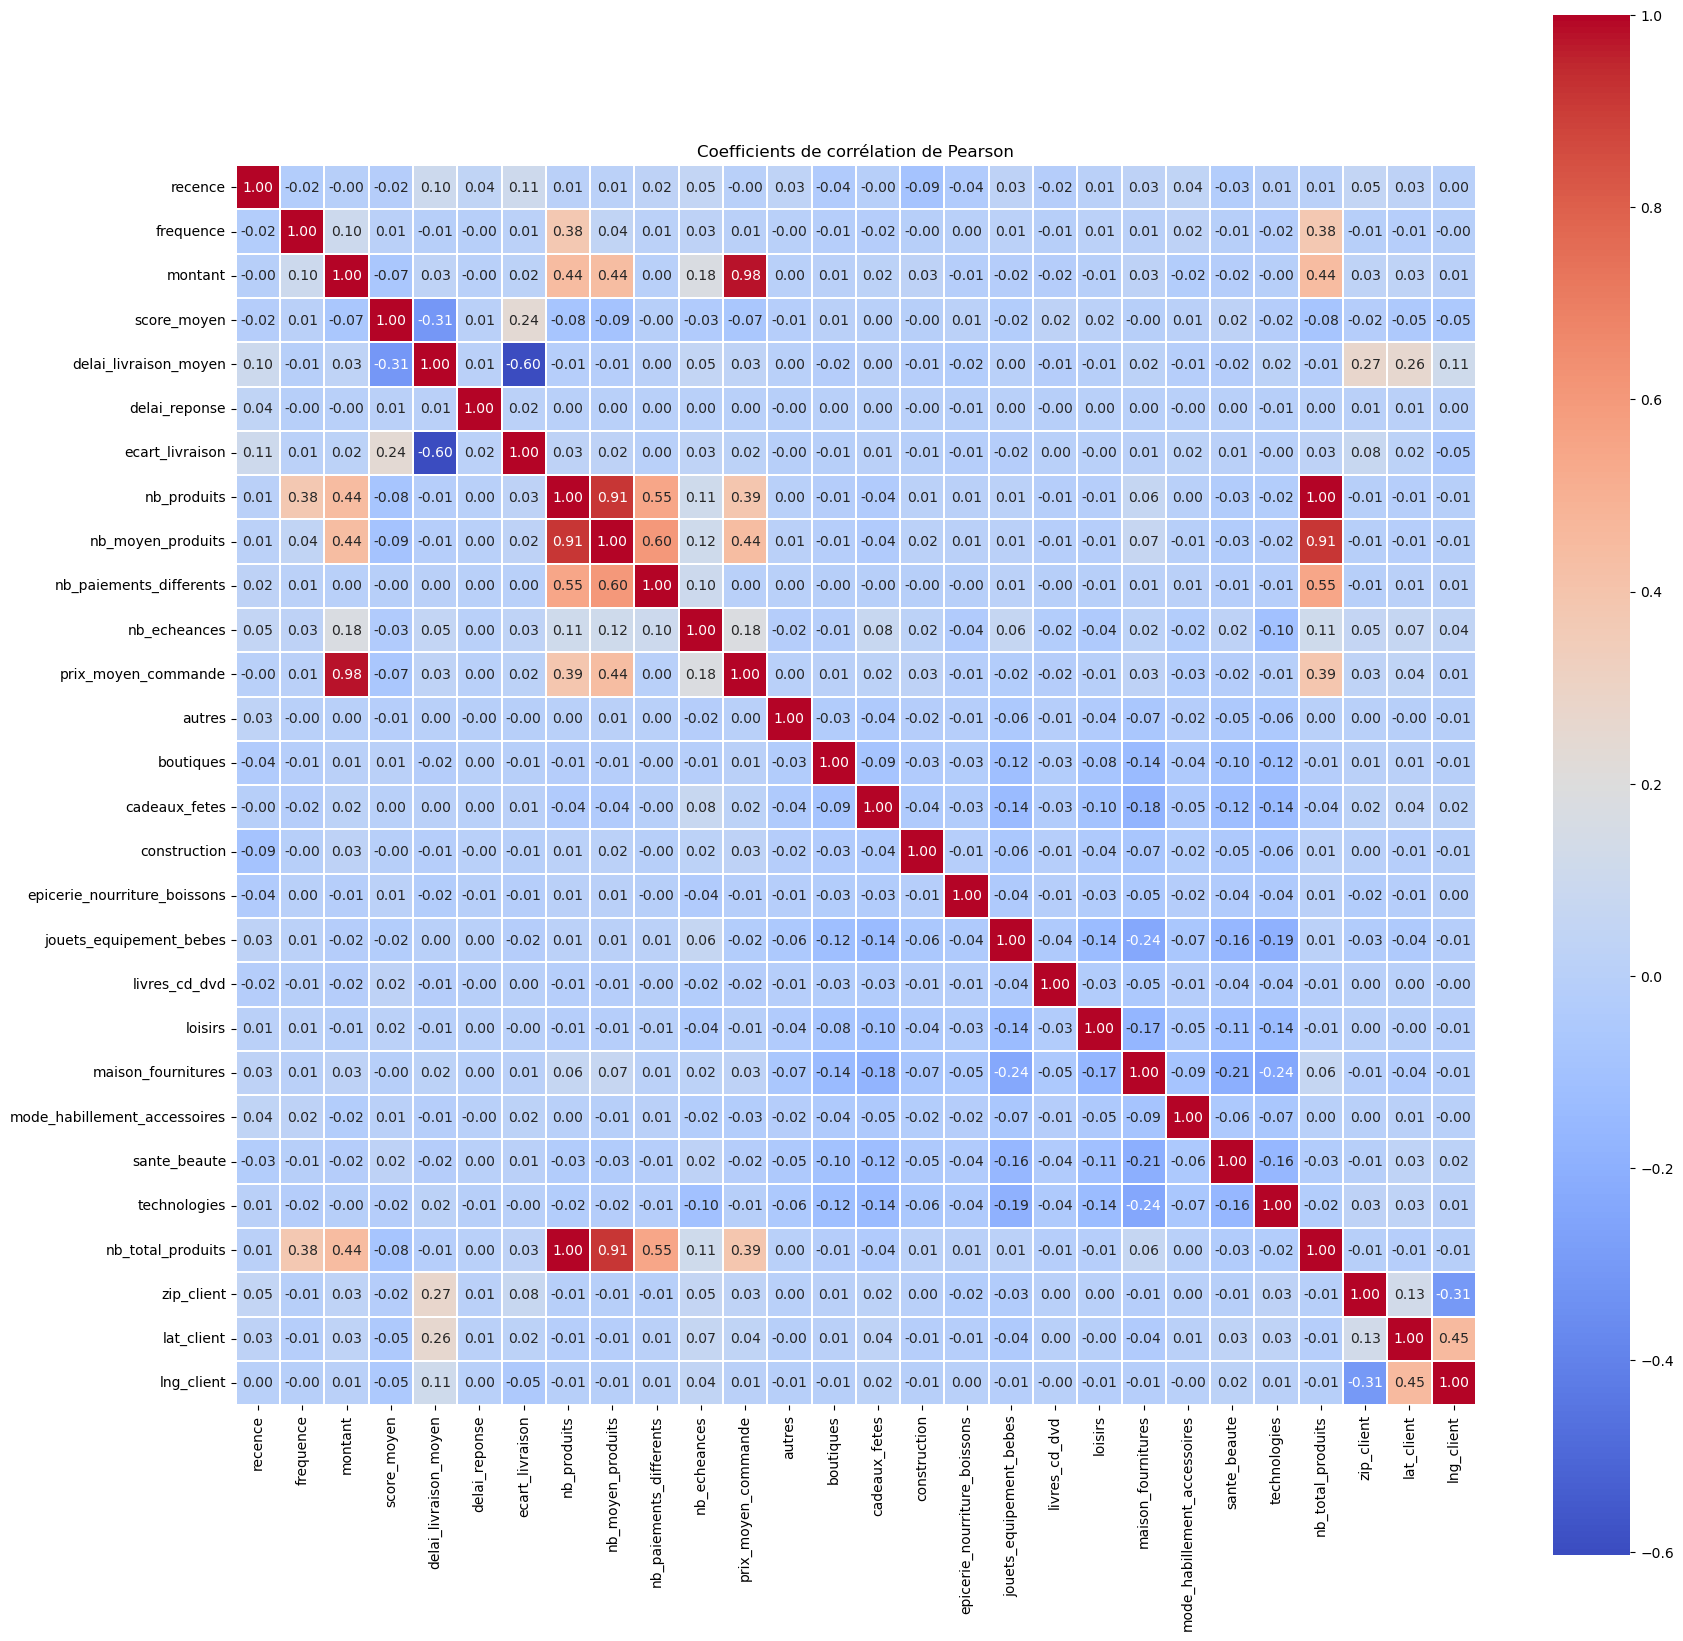

In [385]:
# Matrice des corrélations
corr_mat_client = segmentation_client.corr()

# heatmap
fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_mat_client, square=True, linewidths=0.01, annot=True, fmt=".2f", annot_kws={'size':10}, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

Nous pouvons remarquer une très forte corrélation entre le montant total et le prix moyen par commande. Cette dernière est tout à fait logique puisque 97% des clients n'ont passé qu'une commande. De plus, une variable est présente en double 'nb_produits' et "nb_total_produits". Les 2 variables fortement corrélées seront tout de même conservées par précaution, alors que l'une des 2 variables présentes en double sera éliminée.

Le customer_id, devenu totalement inutile sera aussi éliminé du jeu de données pour la segmentation.

Concernant la localisation du client, cette dernière ne sera pas prise en compte dans les modélisations mais dans les visualisations. Tout d'abord, les variables catégorielles ne sont pas appropriées pour les algorithmes de clustering. De plus, bien qu'étant des variables numériques, les variables longitude et latitude ne formant en réalité qu'une seule variable, elles devraient être traitées pour obtenir une distance vis-à-vis d'un point de repère. Dans notre cas, je ne vois pas de point de repère... Ces dernières, ainsi que le code postal, seront éliminées du jeu de données. Les états et les villes seront conservés pour des visualisations sur les segments. 

In [386]:
segmentation_client = segmentation_client.drop(["nb_total_produits", "customer_id", "zip_client", "lat_client", "lng_client"], axis=1)
segmentation_client.head()

,customer_unique_id,recence,frequence,montant,score_moyen,delai_livraison_moyen,delai_reponse,ecart_livraison,nb_produits,nb_moyen_produits,nb_paiements_differents,nb_echeances,prix_moyen_commande,autres,boutiques,cadeaux_fetes,construction,epicerie_nourriture_boissons,jouets_equipement_bebes,livres_cd_dvd,loisirs,maison_fournitures,mode_habillement_accessoires,sante_beaute,technologies,ville_client,etat_client
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,5.0,4.0,1,1.0,1.0,8.0,141.90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,1.0,4.0,1,1.0,1.0,1.0,27.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,osasco,SP
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,26.0,1.0,1.0,1,1.0,1.0,8.0,86.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,1.0,11.0,1,1.0,1.0,4.0,43.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,5.0,7.0,1,1.0,1.0,6.0,196.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sorocaba,SP


**SAUVEGARDE DU JEU DE DONNEES**

In [387]:
segmentation_client = segmentation_client.to_csv("segmentation_clients.csv", index= False)

## Conclusion sur le fichier créé pour la segmentation/clustering des clients

### Préparation des variables indispensables pour la réalisation d'une segmentation RFM classique
- **La segmentation RFM est une technique intéressante pour la segmentation des clients dans le e-commerce.  Cette dernière permet d’analyser le comportement d’achats des clients et de les segmenter à partir de trois variables : Récence (R), Fréquence (F) et Montant (M).**
    - **Récence**: Nombre de jours écoulés depuis le dernier achat.
    - **Fréquence**: Nombre d'achats sur une période donnée (ici nous prendrons en compte l'ensemble du jeu de données).
    - **Montant**: Montant des commandes passées par le client au cours de la période de référence.
- **Le premier essai dans le prochain notebook sera cette approche**
- **Comme seuls 3% des clients ont passé plus d'une commande, la réalisation d'une segmentation des clients m'interpelle.**

### Résultats de l'analyse exploratoire des données
- **La majorité des clients paient par carte bancaire et généralement en une fois.**
- **La majorité des clients sont localisés dans l'état de Sao Paulo, suivi des états de Rio de Janeiro et de Minas Gerais.**
- **Beaucoup de clients répondent au questionnaire de satisfaction.**
- **Les catégories d'articles les plus prisés sont respectivement 'maison_fournitures', 'jouets_equipement_bebes' et 'technologie'.**
- **La majorité des clients n'achète en moyenne qu'un produit par commande.**
- **L'état d'appartenance du client impacte sur le montant des commandes d'un point de vue statistique. Néanmoins, il est indispensable de prendre ce résultat avec 'des pincettes' car 97% des clients n'ont effectué qu'un seul achat. Par conséquent, de mon point de vue, cette variable ne doit pas être prise en compte.**

### A noter
**Je suis consciente d'avoir fait beaucoup de nettoyage au niveau des villes, des créations de variables certainement inutiles vu le jeu de données fourni (3% seulement de clients ont passé plus d'une commande). Par conséquent, j'ai réalisé ce notebook plutôt comme si nous avions un jeu de données permettant un bon clustering. De mon point de vue, ceci était primordial pour bien me former.**